## `multi_autocorr`: An autocorrelation function for multiple trajectories of different lengths

For these tests, we will use a recent data set generated by Starwing Chen (https://github.com/starwingc) for the omega angles (the dihedral angle across an amide bond) for a peptoid trimer.

A set of 742 trajectories of three omega angles (in degrees) are stored with snapshots every 0.01 ns = 10 ps in the file `data/data.pkl`.

This file is too large to store in the repo, so we reduced it to 0/1 *BOOLEANS* representing 0=cis and 1=trans, in the file `data/all_cistrans.pkl`.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

# Define a helper function to load and save pickles of lists of arrays

class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

## Compute average and stddev over the 0=cis/1=trans trajectories 

In [2]:
all_cistrans = Data.load(f"data/all_cistrans.pkl").array_list 
# This a list of 742 (N_i, 3) np.arrays, where N_i is the size of the i^{th} trajectory
ntraj = len(all_cistrans)

# convert to floats for downstream operations
for i in range(ntraj):
    all_cistrans[i] = all_cistrans[i].astype(float)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
minlength = min( [ len(all_cistrans[i]) for i in range(ntraj) ])
ns_per_step = 0.01
print(f'minlength = {minlength} snapshots ({minlength*ns_per_step:.3f} ns)')
print(f'maxlength = {maxlength} snapshots ({maxlength*ns_per_step:.3f} ns)')

# Make an array to store all the trajectories
arr_cistrans = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    arr_cistrans[i, 0:n, :] = all_cistrans[i]

arr_cistrans.shape

minlength = 1001 snapshots (10.010 ns)
maxlength = 142011 snapshots (1420.110 ns)


(742, 142011, 3)

In [3]:
# Compute the average over all trajectories for non-nan entries

n_included = np.sum(np.where(np.isnan(arr_cistrans[:,:,:]), 0, 1), axis=0)
print('n_included', n_included, 'n_included.shape', n_included.shape)

p_trans = np.nanmean(arr_cistrans, axis=0)
p_trans_std = ((np.nanvar(arr_cistrans, axis=0)) / (n_included-0.9999))**0.5    # 0.9999 ~ 1 designed to avoid dividing by zero

print('p_trans', p_trans)
print('p_trans_std', p_trans_std)


n_included [[742 742 742]
 [742 742 742]
 [742 742 742]
 ...
 [  1   1   1]
 [  1   1   1]
 [  1   1   1]] n_included.shape (142011, 3)
p_trans [[0.63342318 0.45552561 0.48921833]
 [0.63342318 0.45552561 0.48787062]
 [0.63342318 0.45552561 0.48787062]
 ...
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [0.         0.         1.        ]]
p_trans_std [[0.01770192 0.01829515 0.01836369]
 [0.01770192 0.01829515 0.01836255]
 [0.01770192 0.01829515 0.01836255]
 ...
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


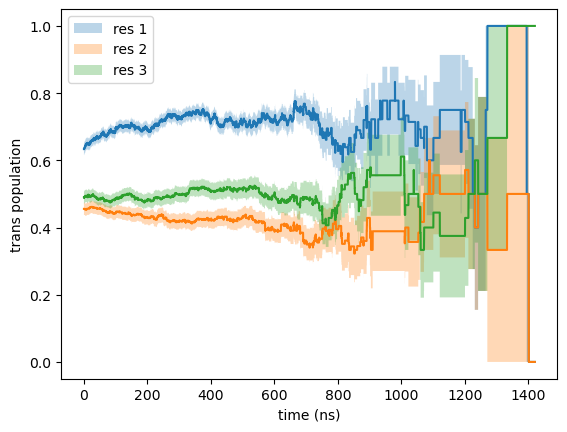

In [4]:
plt.figure()

ns_per_step = 0.01
time_in_ns = np.arange(maxlength)*ns_per_step

plt.plot(time_in_ns, p_trans) # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,0], (p_trans-p_trans_std)[:,0], alpha=0.3, lw=1, label='res 1') # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,1], (p_trans-p_trans_std)[:,1], alpha=0.3, lw=1, label='res 2') # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,2], (p_trans-p_trans_std)[:,2], alpha=0.3, lw=1, label='res 3') # all three residues
plt.xlabel('time (ns)')
plt.ylabel('trans population')
plt.legend(loc='best')

## The averages *seem* to converge, but let's calculate a `multi_autocorr` autocorrelation function...
## .. THIS time with 5-split bootstrapping


In [5]:
np.random.permutation([1,2,3,5])

array([2, 3, 5, 1])

In [16]:
from autocorrel import *

# Make five partitions of the trajectories at random
ntraj = len(all_cistrans)
ntrials = 5

Ind = np.random.permutation(np.arange(ntraj)).astype(int)
nchunk =  int(ntraj/ntrials)  # the number of trajs in each trial

Ind_trials = [ Ind[(i*nchunk) : ((i+1)*nchunk)].astype(int) for i in range(ntrials)]
all_cistrans_trials = []
for trial in range(ntrials):
    all_cistrans_trials.append( [all_cistrans[i] for i in Ind_trials[trial]] )

if ntraj > nchunk*ntrials:
    # add the remaining trajs to the first group
    for i in range(nchunk*ntrials, ntraj):
        all_cistrans_trials[0].append( all_cistrans[i] )

## Calculate multi_autocorr for each resiue, for each trial

for trial in range(ntrials):

    ntraj_this_trial = len(all_cistrans_trials[trial])
    all_cistrans_res0 = [ all_cistrans_trials[trial][i][:,0] for i in range(ntraj_this_trial) ]
    all_cistrans_res1 = [ all_cistrans_trials[trial][i][:,1] for i in range(ntraj_this_trial) ]
    all_cistrans_res2 = [ all_cistrans_trials[trial][i][:,2] for i in range(ntraj_this_trial) ]
    
    max_tau = 100000
    stride = 1
    result_res0 = multi_autocorr(all_cistrans_res0[0::stride], max_tau=max_tau)
    result_res1 = multi_autocorr(all_cistrans_res1[0::stride], max_tau=max_tau)
    result_res2 = multi_autocorr(all_cistrans_res2[0::stride], max_tau=max_tau)

    # Save the autocorrel functions!
    Data_autocorrel = Data([result_res0, result_res1, result_res2])
    Data_autocorrel.save(f'autocorrel_res012_1us_trial{trial}.pkl')


  0%|                                                                                                                                  | 0/150 [00:00<?, ?it/s]

Analyzing traj 0 of 150 (26032 frames)...


  1%|▊                                                                                                                         | 1/150 [00:00<01:15,  1.98it/s]

Analyzing traj 1 of 150 (8001 frames)...
Analyzing traj 2 of 150 (5001 frames)...
Analyzing traj 3 of 150 (6011 frames)...
Analyzing traj 4 of 150 (16048 frames)...


  3%|████                                                                                                                      | 5/150 [00:00<00:17,  8.25it/s]

Analyzing traj 5 of 150 (17048 frames)...
Analyzing traj 6 of 150 (65013 frames)...


  5%|█████▋                                                                                                                    | 7/150 [00:02<01:05,  2.17it/s]

Analyzing traj 7 of 150 (71072 frames)...


  5%|██████▌                                                                                                                   | 8/150 [00:04<01:52,  1.26it/s]

Analyzing traj 8 of 150 (49001 frames)...


  6%|███████▎                                                                                                                  | 9/150 [00:06<02:06,  1.11it/s]

Analyzing traj 9 of 150 (62011 frames)...


  7%|████████                                                                                                                 | 10/150 [00:07<02:33,  1.10s/it]

Analyzing traj 10 of 150 (29029 frames)...


  7%|████████▊                                                                                                                | 11/150 [00:08<02:14,  1.03it/s]

Analyzing traj 11 of 150 (37001 frames)...


  8%|█████████▋                                                                                                               | 12/150 [00:09<02:09,  1.06it/s]

Analyzing traj 12 of 150 (23041 frames)...


  9%|██████████▍                                                                                                              | 13/150 [00:09<01:48,  1.26it/s]

Analyzing traj 13 of 150 (58147 frames)...


  9%|███████████▎                                                                                                             | 14/150 [00:11<02:18,  1.02s/it]

Analyzing traj 14 of 150 (47016 frames)...


 10%|████████████                                                                                                             | 15/150 [00:12<02:24,  1.07s/it]

Analyzing traj 15 of 150 (44001 frames)...


 11%|████████████▉                                                                                                            | 16/150 [00:13<02:24,  1.08s/it]

Analyzing traj 16 of 150 (11010 frames)...
Analyzing traj 17 of 150 (34001 frames)...


 12%|██████████████▌                                                                                                          | 18/150 [00:14<01:41,  1.30it/s]

Analyzing traj 18 of 150 (77033 frames)...


 13%|███████████████▎                                                                                                         | 19/150 [00:16<02:28,  1.13s/it]

Analyzing traj 19 of 150 (61001 frames)...


 13%|████████████████▏                                                                                                        | 20/150 [00:18<02:45,  1.27s/it]

Analyzing traj 20 of 150 (142011 frames)...


 14%|████████████████▉                                                                                                        | 21/150 [00:22<04:44,  2.21s/it]

Analyzing traj 21 of 150 (49001 frames)...


 15%|█████████████████▋                                                                                                       | 22/150 [00:24<04:08,  1.94s/it]

Analyzing traj 22 of 150 (36001 frames)...


 15%|██████████████████▌                                                                                                      | 23/150 [00:25<03:26,  1.63s/it]

Analyzing traj 23 of 150 (26001 frames)...


 17%|████████████████████▏                                                                                                    | 25/150 [00:25<01:59,  1.04it/s]

Analyzing traj 24 of 150 (14001 frames)...
Analyzing traj 25 of 150 (52029 frames)...


 17%|████████████████████▉                                                                                                    | 26/150 [00:27<02:13,  1.08s/it]

Analyzing traj 26 of 150 (22001 frames)...


 18%|█████████████████████▊                                                                                                   | 27/150 [00:27<01:47,  1.15it/s]

Analyzing traj 27 of 150 (66121 frames)...


 20%|████████████████████████▏                                                                                                | 30/150 [00:29<01:19,  1.52it/s]

Analyzing traj 28 of 150 (11001 frames)...
Analyzing traj 29 of 150 (12001 frames)...
Analyzing traj 30 of 150 (22001 frames)...


 21%|█████████████████████████                                                                                                | 31/150 [00:29<01:10,  1.69it/s]

Analyzing traj 31 of 150 (10116 frames)...
Analyzing traj 32 of 150 (36001 frames)...


 22%|██████████████████████████▌                                                                                              | 33/150 [00:30<01:01,  1.92it/s]

Analyzing traj 33 of 150 (10001 frames)...
Analyzing traj 34 of 150 (45022 frames)...


 23%|████████████████████████████▏                                                                                            | 35/150 [00:31<01:02,  1.84it/s]

Analyzing traj 35 of 150 (75076 frames)...


 24%|█████████████████████████████                                                                                            | 36/150 [00:33<01:40,  1.13it/s]

Analyzing traj 36 of 150 (10001 frames)...
Analyzing traj 37 of 150 (8001 frames)...
Analyzing traj 38 of 150 (17025 frames)...


 26%|███████████████████████████████▍                                                                                         | 39/150 [00:34<00:56,  1.98it/s]

Analyzing traj 39 of 150 (6001 frames)...
Analyzing traj 40 of 150 (53075 frames)...


 27%|█████████████████████████████████                                                                                        | 41/150 [00:35<01:01,  1.77it/s]

Analyzing traj 41 of 150 (12001 frames)...
Analyzing traj 42 of 150 (59052 frames)...


 29%|███████████████████████████████████▍                                                                                     | 44/150 [00:37<00:58,  1.81it/s]

Analyzing traj 43 of 150 (13058 frames)...
Analyzing traj 44 of 150 (3001 frames)...
Analyzing traj 45 of 150 (68072 frames)...


 31%|█████████████████████████████████████                                                                                    | 46/150 [00:39<01:11,  1.45it/s]

Analyzing traj 46 of 150 (47001 frames)...


 31%|█████████████████████████████████████▉                                                                                   | 47/150 [00:40<01:21,  1.27it/s]

Analyzing traj 47 of 150 (44097 frames)...


 32%|██████████████████████████████████████▋                                                                                  | 48/150 [00:41<01:27,  1.17it/s]

Analyzing traj 48 of 150 (12010 frames)...
Analyzing traj 49 of 150 (68063 frames)...


 33%|████████████████████████████████████████▎                                                                                | 50/150 [00:43<01:31,  1.09it/s]

Analyzing traj 50 of 150 (5015 frames)...
Analyzing traj 51 of 150 (10001 frames)...
Analyzing traj 52 of 150 (6006 frames)...
Analyzing traj 53 of 150 (69030 frames)...


 36%|███████████████████████████████████████████▌                                                                             | 54/150 [00:45<01:07,  1.43it/s]

Analyzing traj 54 of 150 (32001 frames)...


 37%|████████████████████████████████████████████▎                                                                            | 55/150 [00:46<01:08,  1.40it/s]

Analyzing traj 55 of 150 (9001 frames)...
Analyzing traj 56 of 150 (18025 frames)...


 38%|█████████████████████████████████████████████▉                                                                           | 57/150 [00:46<00:49,  1.87it/s]

Analyzing traj 57 of 150 (67086 frames)...


 39%|██████████████████████████████████████████████▊                                                                          | 58/150 [00:48<01:11,  1.28it/s]

Analyzing traj 58 of 150 (62133 frames)...


 39%|███████████████████████████████████████████████▌                                                                         | 59/150 [00:50<01:28,  1.03it/s]

Analyzing traj 59 of 150 (47015 frames)...


 40%|████████████████████████████████████████████████▍                                                                        | 60/150 [00:51<01:31,  1.01s/it]

Analyzing traj 60 of 150 (71208 frames)...


 41%|█████████████████████████████████████████████████▏                                                                       | 61/150 [00:53<01:51,  1.25s/it]

Analyzing traj 61 of 150 (47068 frames)...


 41%|██████████████████████████████████████████████████                                                                       | 62/150 [00:54<01:49,  1.24s/it]

Analyzing traj 62 of 150 (54057 frames)...


 42%|██████████████████████████████████████████████████▊                                                                      | 63/150 [00:56<01:52,  1.30s/it]

Analyzing traj 63 of 150 (36037 frames)...


 43%|████████████████████████████████████████████████████▍                                                                    | 65/150 [00:57<01:14,  1.14it/s]

Analyzing traj 64 of 150 (14001 frames)...
Analyzing traj 65 of 150 (112064 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 66/150 [01:00<02:17,  1.64s/it]

Analyzing traj 66 of 150 (43011 frames)...


 45%|██████████████████████████████████████████████████████                                                                   | 67/150 [01:01<02:02,  1.47s/it]

Analyzing traj 67 of 150 (57095 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 68/150 [01:03<02:02,  1.49s/it]

Analyzing traj 68 of 150 (55053 frames)...


 46%|███████████████████████████████████████████████████████▋                                                                 | 69/150 [01:04<02:00,  1.49s/it]

Analyzing traj 69 of 150 (40001 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 70/150 [01:05<01:46,  1.33s/it]

Analyzing traj 70 of 150 (75133 frames)...


 47%|█████████████████████████████████████████████████████████▎                                                               | 71/150 [01:07<02:05,  1.58s/it]

Analyzing traj 71 of 150 (63139 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 72/150 [01:09<02:07,  1.63s/it]

Analyzing traj 72 of 150 (42031 frames)...


 49%|██████████████████████████████████████████████████████████▉                                                              | 73/150 [01:10<01:50,  1.44s/it]

Analyzing traj 73 of 150 (66157 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 74/150 [01:12<01:58,  1.56s/it]

Analyzing traj 74 of 150 (34001 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 75/150 [01:13<01:39,  1.32s/it]

Analyzing traj 75 of 150 (56230 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 76/150 [01:14<01:42,  1.39s/it]

Analyzing traj 76 of 150 (10001 frames)...
Analyzing traj 77 of 150 (65042 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 78/150 [01:16<01:24,  1.17s/it]

Analyzing traj 78 of 150 (42020 frames)...


 53%|███████████████████████████████████████████████████████████████▋                                                         | 79/150 [01:17<01:20,  1.14s/it]

Analyzing traj 79 of 150 (46139 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 80/150 [01:18<01:20,  1.14s/it]

Analyzing traj 80 of 150 (47219 frames)...


 54%|█████████████████████████████████████████████████████████████████▎                                                       | 81/150 [01:19<01:20,  1.17s/it]

Analyzing traj 81 of 150 (48002 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 82/150 [01:21<01:20,  1.18s/it]

Analyzing traj 82 of 150 (11001 frames)...
Analyzing traj 83 of 150 (75001 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 84/150 [01:23<01:15,  1.15s/it]

Analyzing traj 84 of 150 (12001 frames)...
Analyzing traj 85 of 150 (31001 frames)...


 57%|█████████████████████████████████████████████████████████████████████▎                                                   | 86/150 [01:24<00:54,  1.18it/s]

Analyzing traj 86 of 150 (31001 frames)...


 58%|██████████████████████████████████████████████████████████████████████▏                                                  | 87/150 [01:24<00:50,  1.24it/s]

Analyzing traj 87 of 150 (140074 frames)...


 59%|██████████████████████████████████████████████████████████████████████▉                                                  | 88/150 [01:29<01:46,  1.72s/it]

Analyzing traj 88 of 150 (12016 frames)...
Analyzing traj 89 of 150 (52018 frames)...


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 90/150 [01:30<01:19,  1.32s/it]

Analyzing traj 90 of 150 (39062 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▍                                               | 91/150 [01:31<01:12,  1.23s/it]

Analyzing traj 91 of 150 (52041 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▏                                              | 92/150 [01:33<01:13,  1.26s/it]

Analyzing traj 92 of 150 (30001 frames)...


 62%|███████████████████████████████████████████████████████████████████████████                                              | 93/150 [01:33<01:02,  1.10s/it]

Analyzing traj 93 of 150 (7001 frames)...
Analyzing traj 94 of 150 (32128 frames)...


 63%|████████████████████████████████████████████████████████████████████████████▋                                            | 95/150 [01:34<00:43,  1.27it/s]

Analyzing traj 95 of 150 (36035 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 96/150 [01:35<00:42,  1.26it/s]

Analyzing traj 96 of 150 (5001 frames)...
Analyzing traj 97 of 150 (39001 frames)...


 65%|███████████████████████████████████████████████████████████████████████████████                                          | 98/150 [01:36<00:34,  1.51it/s]

Analyzing traj 98 of 150 (56007 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 99/150 [01:37<00:43,  1.18it/s]

Analyzing traj 99 of 150 (22001 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 101/150 [01:38<00:28,  1.71it/s]

Analyzing traj 100 of 150 (14047 frames)...
Analyzing traj 101 of 150 (77035 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 102/150 [01:40<00:49,  1.02s/it]

Analyzing traj 102 of 150 (52021 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 103/150 [01:41<00:52,  1.12s/it]

Analyzing traj 103 of 150 (66001 frames)...


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 104/150 [01:43<01:00,  1.32s/it]

Analyzing traj 104 of 150 (27001 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 105/150 [01:44<00:49,  1.09s/it]

Analyzing traj 105 of 150 (5001 frames)...
Analyzing traj 106 of 150 (66044 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 107/150 [01:46<00:43,  1.02s/it]

Analyzing traj 107 of 150 (34057 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 108/150 [01:46<00:40,  1.05it/s]

Analyzing traj 108 of 150 (12056 frames)...
Analyzing traj 109 of 150 (60019 frames)...


 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 110/150 [01:48<00:36,  1.09it/s]

Analyzing traj 110 of 150 (58007 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 111/150 [01:50<00:41,  1.06s/it]

Analyzing traj 111 of 150 (76145 frames)...


 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 112/150 [01:52<00:51,  1.35s/it]

Analyzing traj 112 of 150 (89120 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 113/150 [01:55<01:02,  1.69s/it]

Analyzing traj 113 of 150 (47047 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 114/150 [01:56<00:56,  1.56s/it]

Analyzing traj 114 of 150 (25001 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 115/150 [01:56<00:44,  1.27s/it]

Analyzing traj 115 of 150 (6001 frames)...
Analyzing traj 116 of 150 (17001 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 118/150 [01:57<00:19,  1.63it/s]

Analyzing traj 117 of 150 (14001 frames)...
Analyzing traj 118 of 150 (53111 frames)...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 119/150 [01:58<00:25,  1.23it/s]

Analyzing traj 119 of 150 (21113 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 120/150 [01:58<00:20,  1.45it/s]

Analyzing traj 120 of 150 (31001 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 122/150 [01:59<00:15,  1.84it/s]

Analyzing traj 121 of 150 (15001 frames)...
Analyzing traj 122 of 150 (17026 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 123/150 [02:00<00:12,  2.21it/s]

Analyzing traj 123 of 150 (7047 frames)...
Analyzing traj 124 of 150 (56001 frames)...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 125/150 [02:01<00:14,  1.71it/s]

Analyzing traj 125 of 150 (70047 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 126/150 [02:03<00:22,  1.08it/s]

Analyzing traj 126 of 150 (10001 frames)...
Analyzing traj 127 of 150 (17001 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 128/150 [02:03<00:13,  1.68it/s]

Analyzing traj 128 of 150 (76055 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 129/150 [02:05<00:20,  1.04it/s]

Analyzing traj 129 of 150 (54024 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 130/150 [02:07<00:21,  1.07s/it]

Analyzing traj 130 of 150 (33015 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 131/150 [02:08<00:18,  1.01it/s]

Analyzing traj 131 of 150 (6028 frames)...
Analyzing traj 132 of 150 (75014 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 133/150 [02:10<00:17,  1.03s/it]

Analyzing traj 133 of 150 (31043 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 134/150 [02:10<00:15,  1.06it/s]

Analyzing traj 134 of 150 (37001 frames)...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 135/150 [02:11<00:13,  1.08it/s]

Analyzing traj 135 of 150 (6068 frames)...
Analyzing traj 136 of 150 (24059 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 137/150 [02:12<00:08,  1.57it/s]

Analyzing traj 137 of 150 (81082 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 138/150 [02:14<00:12,  1.03s/it]

Analyzing traj 138 of 150 (46129 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 139/150 [02:15<00:11,  1.07s/it]

Analyzing traj 139 of 150 (6003 frames)...
Analyzing traj 140 of 150 (36162 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 141/150 [02:16<00:07,  1.25it/s]

Analyzing traj 141 of 150 (74014 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 142/150 [02:18<00:08,  1.10s/it]

Analyzing traj 142 of 150 (47094 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 143/150 [02:20<00:07,  1.13s/it]

Analyzing traj 143 of 150 (23001 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 144/150 [02:20<00:05,  1.06it/s]

Analyzing traj 144 of 150 (20001 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 145/150 [02:20<00:03,  1.29it/s]

Analyzing traj 145 of 150 (23082 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 146/150 [02:21<00:02,  1.48it/s]

Analyzing traj 146 of 150 (41017 frames)...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 147/150 [02:22<00:02,  1.30it/s]

Analyzing traj 147 of 150 (68031 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148/150 [02:24<00:02,  1.11s/it]

Analyzing traj 148 of 150 (46024 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149/150 [02:25<00:01,  1.12s/it]

Analyzing traj 149 of 150 (62047 frames)...


  0%|                                                                                                                                  | 0/150 [00:00<?, ?it/s]

Analyzing traj 0 of 150 (26032 frames)...


  1%|▊                                                                                                                         | 1/150 [00:00<01:16,  1.94it/s]

Analyzing traj 1 of 150 (8001 frames)...
Analyzing traj 2 of 150 (5001 frames)...
Analyzing traj 3 of 150 (6011 frames)...
Analyzing traj 4 of 150 (16048 frames)...


  3%|████                                                                                                                      | 5/150 [00:00<00:17,  8.18it/s]

Analyzing traj 5 of 150 (17048 frames)...
Analyzing traj 6 of 150 (65013 frames)...


  5%|█████▋                                                                                                                    | 7/150 [00:02<01:06,  2.16it/s]

Analyzing traj 7 of 150 (71072 frames)...


  5%|██████▌                                                                                                                   | 8/150 [00:04<01:52,  1.26it/s]

Analyzing traj 8 of 150 (49001 frames)...


  6%|███████▎                                                                                                                  | 9/150 [00:06<02:08,  1.10it/s]

Analyzing traj 9 of 150 (62011 frames)...


  7%|████████                                                                                                                 | 10/150 [00:07<02:35,  1.11s/it]

Analyzing traj 10 of 150 (29029 frames)...


  7%|████████▊                                                                                                                | 11/150 [00:08<02:16,  1.02it/s]

Analyzing traj 11 of 150 (37001 frames)...


  8%|█████████▋                                                                                                               | 12/150 [00:09<02:10,  1.06it/s]

Analyzing traj 12 of 150 (23041 frames)...


  9%|██████████▍                                                                                                              | 13/150 [00:09<01:49,  1.25it/s]

Analyzing traj 13 of 150 (58147 frames)...


  9%|███████████▎                                                                                                             | 14/150 [00:11<02:18,  1.02s/it]

Analyzing traj 14 of 150 (47016 frames)...


 10%|████████████                                                                                                             | 15/150 [00:12<02:24,  1.07s/it]

Analyzing traj 15 of 150 (44001 frames)...


 11%|████████████▉                                                                                                            | 16/150 [00:13<02:23,  1.07s/it]

Analyzing traj 16 of 150 (11010 frames)...
Analyzing traj 17 of 150 (34001 frames)...


 12%|██████████████▌                                                                                                          | 18/150 [00:14<01:41,  1.30it/s]

Analyzing traj 18 of 150 (77033 frames)...


 13%|███████████████▎                                                                                                         | 19/150 [00:16<02:27,  1.13s/it]

Analyzing traj 19 of 150 (61001 frames)...


 13%|████████████████▏                                                                                                        | 20/150 [00:18<02:44,  1.27s/it]

Analyzing traj 20 of 150 (142011 frames)...


 14%|████████████████▉                                                                                                        | 21/150 [00:22<04:43,  2.20s/it]

Analyzing traj 21 of 150 (49001 frames)...


 15%|█████████████████▋                                                                                                       | 22/150 [00:24<04:08,  1.94s/it]

Analyzing traj 22 of 150 (36001 frames)...


 15%|██████████████████▌                                                                                                      | 23/150 [00:25<03:26,  1.62s/it]

Analyzing traj 23 of 150 (26001 frames)...


 17%|████████████████████▏                                                                                                    | 25/150 [00:25<02:00,  1.04it/s]

Analyzing traj 24 of 150 (14001 frames)...
Analyzing traj 25 of 150 (52029 frames)...


 17%|████████████████████▉                                                                                                    | 26/150 [00:27<02:13,  1.08s/it]

Analyzing traj 26 of 150 (22001 frames)...


 18%|█████████████████████▊                                                                                                   | 27/150 [00:27<01:47,  1.15it/s]

Analyzing traj 27 of 150 (66121 frames)...


 20%|████████████████████████▏                                                                                                | 30/150 [00:29<01:18,  1.52it/s]

Analyzing traj 28 of 150 (11001 frames)...
Analyzing traj 29 of 150 (12001 frames)...
Analyzing traj 30 of 150 (22001 frames)...


 21%|█████████████████████████                                                                                                | 31/150 [00:29<01:10,  1.70it/s]

Analyzing traj 31 of 150 (10116 frames)...
Analyzing traj 32 of 150 (36001 frames)...


 22%|██████████████████████████▌                                                                                              | 33/150 [00:30<01:00,  1.92it/s]

Analyzing traj 33 of 150 (10001 frames)...
Analyzing traj 34 of 150 (45022 frames)...


 23%|████████████████████████████▏                                                                                            | 35/150 [00:31<01:02,  1.85it/s]

Analyzing traj 35 of 150 (75076 frames)...


 24%|█████████████████████████████                                                                                            | 36/150 [00:33<01:40,  1.14it/s]

Analyzing traj 36 of 150 (10001 frames)...
Analyzing traj 37 of 150 (8001 frames)...
Analyzing traj 38 of 150 (17025 frames)...


 26%|███████████████████████████████▍                                                                                         | 39/150 [00:34<00:55,  1.99it/s]

Analyzing traj 39 of 150 (6001 frames)...
Analyzing traj 40 of 150 (53075 frames)...


 27%|█████████████████████████████████                                                                                        | 41/150 [00:35<01:01,  1.76it/s]

Analyzing traj 41 of 150 (12001 frames)...
Analyzing traj 42 of 150 (59052 frames)...


 29%|███████████████████████████████████▍                                                                                     | 44/150 [00:37<00:58,  1.80it/s]

Analyzing traj 43 of 150 (13058 frames)...
Analyzing traj 44 of 150 (3001 frames)...
Analyzing traj 45 of 150 (68072 frames)...


 31%|█████████████████████████████████████                                                                                    | 46/150 [00:39<01:11,  1.44it/s]

Analyzing traj 46 of 150 (47001 frames)...


 31%|█████████████████████████████████████▉                                                                                   | 47/150 [00:40<01:21,  1.27it/s]

Analyzing traj 47 of 150 (44097 frames)...


 32%|██████████████████████████████████████▋                                                                                  | 48/150 [00:41<01:27,  1.17it/s]

Analyzing traj 48 of 150 (12010 frames)...
Analyzing traj 49 of 150 (68063 frames)...


 33%|████████████████████████████████████████▎                                                                                | 50/150 [00:43<01:30,  1.10it/s]

Analyzing traj 50 of 150 (5015 frames)...
Analyzing traj 51 of 150 (10001 frames)...
Analyzing traj 52 of 150 (6006 frames)...
Analyzing traj 53 of 150 (69030 frames)...


 36%|███████████████████████████████████████████▌                                                                             | 54/150 [00:45<01:06,  1.45it/s]

Analyzing traj 54 of 150 (32001 frames)...


 37%|████████████████████████████████████████████▎                                                                            | 55/150 [00:46<01:05,  1.44it/s]

Analyzing traj 55 of 150 (9001 frames)...
Analyzing traj 56 of 150 (18025 frames)...


 38%|█████████████████████████████████████████████▉                                                                           | 57/150 [00:46<00:48,  1.92it/s]

Analyzing traj 57 of 150 (67086 frames)...


 39%|██████████████████████████████████████████████▊                                                                          | 58/150 [00:48<01:10,  1.30it/s]

Analyzing traj 58 of 150 (62133 frames)...


 39%|███████████████████████████████████████████████▌                                                                         | 59/150 [00:50<01:27,  1.04it/s]

Analyzing traj 59 of 150 (47015 frames)...


 40%|████████████████████████████████████████████████▍                                                                        | 60/150 [00:51<01:30,  1.01s/it]

Analyzing traj 60 of 150 (71208 frames)...


 41%|█████████████████████████████████████████████████▏                                                                       | 61/150 [00:53<01:51,  1.26s/it]

Analyzing traj 61 of 150 (47068 frames)...


 41%|██████████████████████████████████████████████████                                                                       | 62/150 [00:54<01:49,  1.24s/it]

Analyzing traj 62 of 150 (54057 frames)...


 42%|██████████████████████████████████████████████████▊                                                                      | 63/150 [00:55<01:52,  1.29s/it]

Analyzing traj 63 of 150 (36037 frames)...


 43%|████████████████████████████████████████████████████▍                                                                    | 65/150 [00:56<01:14,  1.15it/s]

Analyzing traj 64 of 150 (14001 frames)...
Analyzing traj 65 of 150 (112064 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 66/150 [01:00<02:18,  1.65s/it]

Analyzing traj 66 of 150 (43011 frames)...


 45%|██████████████████████████████████████████████████████                                                                   | 67/150 [01:01<02:02,  1.48s/it]

Analyzing traj 67 of 150 (57095 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 68/150 [01:03<02:02,  1.50s/it]

Analyzing traj 68 of 150 (55053 frames)...


 46%|███████████████████████████████████████████████████████▋                                                                 | 69/150 [01:04<02:00,  1.48s/it]

Analyzing traj 69 of 150 (40001 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 70/150 [01:05<01:46,  1.33s/it]

Analyzing traj 70 of 150 (75133 frames)...


 47%|█████████████████████████████████████████████████████████▎                                                               | 71/150 [01:07<02:04,  1.58s/it]

Analyzing traj 71 of 150 (63139 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 72/150 [01:09<02:07,  1.63s/it]

Analyzing traj 72 of 150 (42031 frames)...


 49%|██████████████████████████████████████████████████████████▉                                                              | 73/150 [01:10<01:51,  1.45s/it]

Analyzing traj 73 of 150 (66157 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 74/150 [01:12<01:59,  1.58s/it]

Analyzing traj 74 of 150 (34001 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 75/150 [01:13<01:40,  1.33s/it]

Analyzing traj 75 of 150 (56230 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 76/150 [01:14<01:42,  1.39s/it]

Analyzing traj 76 of 150 (10001 frames)...
Analyzing traj 77 of 150 (65042 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 78/150 [01:16<01:23,  1.17s/it]

Analyzing traj 78 of 150 (42020 frames)...


 53%|███████████████████████████████████████████████████████████████▋                                                         | 79/150 [01:17<01:20,  1.13s/it]

Analyzing traj 79 of 150 (46139 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 80/150 [01:18<01:19,  1.14s/it]

Analyzing traj 80 of 150 (47219 frames)...


 54%|█████████████████████████████████████████████████████████████████▎                                                       | 81/150 [01:19<01:19,  1.16s/it]

Analyzing traj 81 of 150 (48002 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 82/150 [01:21<01:20,  1.18s/it]

Analyzing traj 82 of 150 (11001 frames)...
Analyzing traj 83 of 150 (75001 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 84/150 [01:23<01:15,  1.15s/it]

Analyzing traj 84 of 150 (12001 frames)...
Analyzing traj 85 of 150 (31001 frames)...


 57%|█████████████████████████████████████████████████████████████████████▎                                                   | 86/150 [01:24<00:54,  1.18it/s]

Analyzing traj 86 of 150 (31001 frames)...


 58%|██████████████████████████████████████████████████████████████████████▏                                                  | 87/150 [01:24<00:51,  1.23it/s]

Analyzing traj 87 of 150 (140074 frames)...


 59%|██████████████████████████████████████████████████████████████████████▉                                                  | 88/150 [01:29<01:46,  1.72s/it]

Analyzing traj 88 of 150 (12016 frames)...
Analyzing traj 89 of 150 (52018 frames)...


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 90/150 [01:30<01:18,  1.30s/it]

Analyzing traj 90 of 150 (39062 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▍                                               | 91/150 [01:31<01:12,  1.22s/it]

Analyzing traj 91 of 150 (52041 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▏                                              | 92/150 [01:33<01:12,  1.26s/it]

Analyzing traj 92 of 150 (30001 frames)...


 62%|███████████████████████████████████████████████████████████████████████████                                              | 93/150 [01:33<01:02,  1.10s/it]

Analyzing traj 93 of 150 (7001 frames)...
Analyzing traj 94 of 150 (32128 frames)...


 63%|████████████████████████████████████████████████████████████████████████████▋                                            | 95/150 [01:34<00:43,  1.28it/s]

Analyzing traj 95 of 150 (36035 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 96/150 [01:35<00:42,  1.26it/s]

Analyzing traj 96 of 150 (5001 frames)...
Analyzing traj 97 of 150 (39001 frames)...


 65%|███████████████████████████████████████████████████████████████████████████████                                          | 98/150 [01:36<00:34,  1.51it/s]

Analyzing traj 98 of 150 (56007 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 99/150 [01:37<00:43,  1.18it/s]

Analyzing traj 99 of 150 (22001 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 101/150 [01:38<00:28,  1.72it/s]

Analyzing traj 100 of 150 (14047 frames)...
Analyzing traj 101 of 150 (77035 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 102/150 [01:40<00:47,  1.01it/s]

Analyzing traj 102 of 150 (52021 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 103/150 [01:41<00:50,  1.08s/it]

Analyzing traj 103 of 150 (66001 frames)...


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 104/150 [01:43<00:59,  1.29s/it]

Analyzing traj 104 of 150 (27001 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 105/150 [01:43<00:48,  1.08s/it]

Analyzing traj 105 of 150 (5001 frames)...
Analyzing traj 106 of 150 (66044 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 107/150 [01:45<00:43,  1.01s/it]

Analyzing traj 107 of 150 (34057 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 108/150 [01:46<00:40,  1.05it/s]

Analyzing traj 108 of 150 (12056 frames)...
Analyzing traj 109 of 150 (60019 frames)...


 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 110/150 [01:48<00:36,  1.09it/s]

Analyzing traj 110 of 150 (58007 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 111/150 [01:49<00:41,  1.07s/it]

Analyzing traj 111 of 150 (76145 frames)...


 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 112/150 [01:52<00:51,  1.34s/it]

Analyzing traj 112 of 150 (89120 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 113/150 [01:54<01:02,  1.68s/it]

Analyzing traj 113 of 150 (47047 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 114/150 [01:55<00:55,  1.55s/it]

Analyzing traj 114 of 150 (25001 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 115/150 [01:56<00:43,  1.25s/it]

Analyzing traj 115 of 150 (6001 frames)...
Analyzing traj 116 of 150 (17001 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 118/150 [01:56<00:19,  1.67it/s]

Analyzing traj 117 of 150 (14001 frames)...
Analyzing traj 118 of 150 (53111 frames)...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 119/150 [01:58<00:24,  1.24it/s]

Analyzing traj 119 of 150 (21113 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 120/150 [01:58<00:20,  1.46it/s]

Analyzing traj 120 of 150 (31001 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 122/150 [01:59<00:14,  1.87it/s]

Analyzing traj 121 of 150 (15001 frames)...
Analyzing traj 122 of 150 (17026 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 123/150 [01:59<00:12,  2.24it/s]

Analyzing traj 123 of 150 (7047 frames)...
Analyzing traj 124 of 150 (56001 frames)...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 125/150 [02:01<00:14,  1.71it/s]

Analyzing traj 125 of 150 (70047 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 126/150 [02:03<00:22,  1.08it/s]

Analyzing traj 126 of 150 (10001 frames)...
Analyzing traj 127 of 150 (17001 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 128/150 [02:03<00:13,  1.68it/s]

Analyzing traj 128 of 150 (76055 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 129/150 [02:05<00:19,  1.06it/s]

Analyzing traj 129 of 150 (54024 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 130/150 [02:06<00:21,  1.06s/it]

Analyzing traj 130 of 150 (33015 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 131/150 [02:07<00:18,  1.02it/s]

Analyzing traj 131 of 150 (6028 frames)...
Analyzing traj 132 of 150 (75014 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 133/150 [02:09<00:17,  1.02s/it]

Analyzing traj 133 of 150 (31043 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 134/150 [02:10<00:15,  1.06it/s]

Analyzing traj 134 of 150 (37001 frames)...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 135/150 [02:11<00:13,  1.09it/s]

Analyzing traj 135 of 150 (6068 frames)...
Analyzing traj 136 of 150 (24059 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 137/150 [02:11<00:08,  1.58it/s]

Analyzing traj 137 of 150 (81082 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 138/150 [02:14<00:12,  1.03s/it]

Analyzing traj 138 of 150 (46129 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 139/150 [02:15<00:11,  1.06s/it]

Analyzing traj 139 of 150 (6003 frames)...
Analyzing traj 140 of 150 (36162 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 141/150 [02:16<00:07,  1.25it/s]

Analyzing traj 141 of 150 (74014 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 142/150 [02:18<00:08,  1.10s/it]

Analyzing traj 142 of 150 (47094 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 143/150 [02:19<00:07,  1.13s/it]

Analyzing traj 143 of 150 (23001 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 144/150 [02:19<00:05,  1.06it/s]

Analyzing traj 144 of 150 (20001 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 145/150 [02:20<00:03,  1.29it/s]

Analyzing traj 145 of 150 (23082 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 146/150 [02:20<00:02,  1.49it/s]

Analyzing traj 146 of 150 (41017 frames)...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 147/150 [02:21<00:02,  1.31it/s]

Analyzing traj 147 of 150 (68031 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148/150 [02:23<00:02,  1.10s/it]

Analyzing traj 148 of 150 (46024 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149/150 [02:24<00:01,  1.11s/it]

Analyzing traj 149 of 150 (62047 frames)...


  0%|                                                                                                                                  | 0/150 [00:00<?, ?it/s]

Analyzing traj 0 of 150 (26032 frames)...


  1%|▊                                                                                                                         | 1/150 [00:00<01:15,  1.96it/s]

Analyzing traj 1 of 150 (8001 frames)...
Analyzing traj 2 of 150 (5001 frames)...
Analyzing traj 3 of 150 (6011 frames)...
Analyzing traj 4 of 150 (16048 frames)...


  3%|████                                                                                                                      | 5/150 [00:00<00:17,  8.23it/s]

Analyzing traj 5 of 150 (17048 frames)...
Analyzing traj 6 of 150 (65013 frames)...


  5%|█████▋                                                                                                                    | 7/150 [00:02<01:05,  2.18it/s]

Analyzing traj 7 of 150 (71072 frames)...


  5%|██████▌                                                                                                                   | 8/150 [00:04<01:52,  1.26it/s]

Analyzing traj 8 of 150 (49001 frames)...


  6%|███████▎                                                                                                                  | 9/150 [00:06<02:06,  1.11it/s]

Analyzing traj 9 of 150 (62011 frames)...


  7%|████████                                                                                                                 | 10/150 [00:07<02:33,  1.10s/it]

Analyzing traj 10 of 150 (29029 frames)...


  7%|████████▊                                                                                                                | 11/150 [00:08<02:14,  1.03it/s]

Analyzing traj 11 of 150 (37001 frames)...


  8%|█████████▋                                                                                                               | 12/150 [00:09<02:10,  1.06it/s]

Analyzing traj 12 of 150 (23041 frames)...


  9%|██████████▍                                                                                                              | 13/150 [00:09<01:49,  1.25it/s]

Analyzing traj 13 of 150 (58147 frames)...


  9%|███████████▎                                                                                                             | 14/150 [00:11<02:18,  1.02s/it]

Analyzing traj 14 of 150 (47016 frames)...


 10%|████████████                                                                                                             | 15/150 [00:12<02:23,  1.06s/it]

Analyzing traj 15 of 150 (44001 frames)...


 11%|████████████▉                                                                                                            | 16/150 [00:13<02:23,  1.07s/it]

Analyzing traj 16 of 150 (11010 frames)...
Analyzing traj 17 of 150 (34001 frames)...


 12%|██████████████▌                                                                                                          | 18/150 [00:14<01:41,  1.30it/s]

Analyzing traj 18 of 150 (77033 frames)...


 13%|███████████████▎                                                                                                         | 19/150 [00:16<02:27,  1.13s/it]

Analyzing traj 19 of 150 (61001 frames)...


 13%|████████████████▏                                                                                                        | 20/150 [00:18<02:44,  1.27s/it]

Analyzing traj 20 of 150 (142011 frames)...


 14%|████████████████▉                                                                                                        | 21/150 [00:22<04:44,  2.20s/it]

Analyzing traj 21 of 150 (49001 frames)...


 15%|█████████████████▋                                                                                                       | 22/150 [00:24<04:08,  1.94s/it]

Analyzing traj 22 of 150 (36001 frames)...


 15%|██████████████████▌                                                                                                      | 23/150 [00:24<03:26,  1.62s/it]

Analyzing traj 23 of 150 (26001 frames)...


 17%|████████████████████▏                                                                                                    | 25/150 [00:25<02:00,  1.04it/s]

Analyzing traj 24 of 150 (14001 frames)...
Analyzing traj 25 of 150 (52029 frames)...


 17%|████████████████████▉                                                                                                    | 26/150 [00:27<02:13,  1.08s/it]

Analyzing traj 26 of 150 (22001 frames)...


 18%|█████████████████████▊                                                                                                   | 27/150 [00:27<01:47,  1.14it/s]

Analyzing traj 27 of 150 (66121 frames)...


 20%|████████████████████████▏                                                                                                | 30/150 [00:29<01:18,  1.52it/s]

Analyzing traj 28 of 150 (11001 frames)...
Analyzing traj 29 of 150 (12001 frames)...
Analyzing traj 30 of 150 (22001 frames)...


 21%|█████████████████████████                                                                                                | 31/150 [00:29<01:10,  1.70it/s]

Analyzing traj 31 of 150 (10116 frames)...
Analyzing traj 32 of 150 (36001 frames)...


 22%|██████████████████████████▌                                                                                              | 33/150 [00:30<01:00,  1.92it/s]

Analyzing traj 33 of 150 (10001 frames)...
Analyzing traj 34 of 150 (45022 frames)...


 23%|████████████████████████████▏                                                                                            | 35/150 [00:31<01:02,  1.85it/s]

Analyzing traj 35 of 150 (75076 frames)...


 24%|█████████████████████████████                                                                                            | 36/150 [00:33<01:41,  1.13it/s]

Analyzing traj 36 of 150 (10001 frames)...
Analyzing traj 37 of 150 (8001 frames)...
Analyzing traj 38 of 150 (17025 frames)...


 26%|███████████████████████████████▍                                                                                         | 39/150 [00:34<00:56,  1.98it/s]

Analyzing traj 39 of 150 (6001 frames)...
Analyzing traj 40 of 150 (53075 frames)...


 27%|█████████████████████████████████                                                                                        | 41/150 [00:35<01:01,  1.76it/s]

Analyzing traj 41 of 150 (12001 frames)...
Analyzing traj 42 of 150 (59052 frames)...


 29%|███████████████████████████████████▍                                                                                     | 44/150 [00:37<00:59,  1.80it/s]

Analyzing traj 43 of 150 (13058 frames)...
Analyzing traj 44 of 150 (3001 frames)...
Analyzing traj 45 of 150 (68072 frames)...


 31%|█████████████████████████████████████                                                                                    | 46/150 [00:39<01:12,  1.44it/s]

Analyzing traj 46 of 150 (47001 frames)...


 31%|█████████████████████████████████████▉                                                                                   | 47/150 [00:40<01:21,  1.26it/s]

Analyzing traj 47 of 150 (44097 frames)...


 32%|██████████████████████████████████████▋                                                                                  | 48/150 [00:41<01:27,  1.17it/s]

Analyzing traj 48 of 150 (12010 frames)...
Analyzing traj 49 of 150 (68063 frames)...


 33%|████████████████████████████████████████▎                                                                                | 50/150 [00:43<01:31,  1.10it/s]

Analyzing traj 50 of 150 (5015 frames)...
Analyzing traj 51 of 150 (10001 frames)...
Analyzing traj 52 of 150 (6006 frames)...
Analyzing traj 53 of 150 (69030 frames)...


 36%|███████████████████████████████████████████▌                                                                             | 54/150 [00:45<01:06,  1.44it/s]

Analyzing traj 54 of 150 (32001 frames)...


 37%|████████████████████████████████████████████▎                                                                            | 55/150 [00:46<01:06,  1.43it/s]

Analyzing traj 55 of 150 (9001 frames)...
Analyzing traj 56 of 150 (18025 frames)...


 38%|█████████████████████████████████████████████▉                                                                           | 57/150 [00:46<00:48,  1.91it/s]

Analyzing traj 57 of 150 (67086 frames)...


 39%|██████████████████████████████████████████████▊                                                                          | 58/150 [00:48<01:10,  1.30it/s]

Analyzing traj 58 of 150 (62133 frames)...


 39%|███████████████████████████████████████████████▌                                                                         | 59/150 [00:50<01:27,  1.04it/s]

Analyzing traj 59 of 150 (47015 frames)...


 40%|████████████████████████████████████████████████▍                                                                        | 60/150 [00:51<01:31,  1.01s/it]

Analyzing traj 60 of 150 (71208 frames)...


 41%|█████████████████████████████████████████████████▏                                                                       | 61/150 [00:53<01:52,  1.27s/it]

Analyzing traj 61 of 150 (47068 frames)...


 41%|██████████████████████████████████████████████████                                                                       | 62/150 [00:54<01:50,  1.25s/it]

Analyzing traj 62 of 150 (54057 frames)...


 42%|██████████████████████████████████████████████████▊                                                                      | 63/150 [00:56<01:53,  1.30s/it]

Analyzing traj 63 of 150 (36037 frames)...


 43%|████████████████████████████████████████████████████▍                                                                    | 65/150 [00:56<01:14,  1.15it/s]

Analyzing traj 64 of 150 (14001 frames)...
Analyzing traj 65 of 150 (112064 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 66/150 [01:00<02:17,  1.64s/it]

Analyzing traj 66 of 150 (43011 frames)...


 45%|██████████████████████████████████████████████████████                                                                   | 67/150 [01:01<02:02,  1.47s/it]

Analyzing traj 67 of 150 (57095 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 68/150 [01:03<02:02,  1.49s/it]

Analyzing traj 68 of 150 (55053 frames)...


 46%|███████████████████████████████████████████████████████▋                                                                 | 69/150 [01:04<01:59,  1.47s/it]

Analyzing traj 69 of 150 (40001 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 70/150 [01:05<01:45,  1.32s/it]

Analyzing traj 70 of 150 (75133 frames)...


 47%|█████████████████████████████████████████████████████████▎                                                               | 71/150 [01:07<02:04,  1.57s/it]

Analyzing traj 71 of 150 (63139 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 72/150 [01:09<02:06,  1.63s/it]

Analyzing traj 72 of 150 (42031 frames)...


 49%|██████████████████████████████████████████████████████████▉                                                              | 73/150 [01:10<01:51,  1.45s/it]

Analyzing traj 73 of 150 (66157 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 74/150 [01:12<01:59,  1.57s/it]

Analyzing traj 74 of 150 (34001 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 75/150 [01:13<01:39,  1.33s/it]

Analyzing traj 75 of 150 (56230 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 76/150 [01:14<01:42,  1.38s/it]

Analyzing traj 76 of 150 (10001 frames)...
Analyzing traj 77 of 150 (65042 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 78/150 [01:16<01:23,  1.16s/it]

Analyzing traj 78 of 150 (42020 frames)...


 53%|███████████████████████████████████████████████████████████████▋                                                         | 79/150 [01:17<01:20,  1.13s/it]

Analyzing traj 79 of 150 (46139 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 80/150 [01:18<01:18,  1.12s/it]

Analyzing traj 80 of 150 (47219 frames)...


 54%|█████████████████████████████████████████████████████████████████▎                                                       | 81/150 [01:19<01:14,  1.07s/it]

Analyzing traj 81 of 150 (48002 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 82/150 [01:20<01:11,  1.05s/it]

Analyzing traj 82 of 150 (11001 frames)...
Analyzing traj 83 of 150 (75001 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 84/150 [01:22<01:05,  1.01it/s]

Analyzing traj 84 of 150 (12001 frames)...
Analyzing traj 85 of 150 (31001 frames)...


 57%|█████████████████████████████████████████████████████████████████████▎                                                   | 86/150 [01:22<00:46,  1.37it/s]

Analyzing traj 86 of 150 (31001 frames)...


 58%|██████████████████████████████████████████████████████████████████████▏                                                  | 87/150 [01:23<00:44,  1.40it/s]

Analyzing traj 87 of 150 (140074 frames)...


 59%|██████████████████████████████████████████████████████████████████████▉                                                  | 88/150 [01:28<01:41,  1.64s/it]

Analyzing traj 88 of 150 (12016 frames)...
Analyzing traj 89 of 150 (52018 frames)...


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 90/150 [01:29<01:15,  1.27s/it]

Analyzing traj 90 of 150 (39062 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▍                                               | 91/150 [01:30<01:10,  1.19s/it]

Analyzing traj 91 of 150 (52041 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▏                                              | 92/150 [01:31<01:11,  1.23s/it]

Analyzing traj 92 of 150 (30001 frames)...


 62%|███████████████████████████████████████████████████████████████████████████                                              | 93/150 [01:32<01:01,  1.08s/it]

Analyzing traj 93 of 150 (7001 frames)...
Analyzing traj 94 of 150 (32128 frames)...


 63%|████████████████████████████████████████████████████████████████████████████▋                                            | 95/150 [01:33<00:42,  1.30it/s]

Analyzing traj 95 of 150 (36035 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 96/150 [01:34<00:42,  1.27it/s]

Analyzing traj 96 of 150 (5001 frames)...
Analyzing traj 97 of 150 (39001 frames)...


 65%|███████████████████████████████████████████████████████████████████████████████                                          | 98/150 [01:35<00:34,  1.52it/s]

Analyzing traj 98 of 150 (56007 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 99/150 [01:36<00:42,  1.19it/s]

Analyzing traj 99 of 150 (22001 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 101/150 [01:37<00:28,  1.73it/s]

Analyzing traj 100 of 150 (14047 frames)...
Analyzing traj 101 of 150 (77035 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 102/150 [01:39<00:48,  1.02s/it]

Analyzing traj 102 of 150 (52021 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 103/150 [01:40<00:52,  1.11s/it]

Analyzing traj 103 of 150 (66001 frames)...


 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 104/150 [01:42<01:00,  1.32s/it]

Analyzing traj 104 of 150 (27001 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 105/150 [01:42<00:49,  1.09s/it]

Analyzing traj 105 of 150 (5001 frames)...
Analyzing traj 106 of 150 (66044 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 107/150 [01:44<00:43,  1.01s/it]

Analyzing traj 107 of 150 (34057 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 108/150 [01:45<00:40,  1.05it/s]

Analyzing traj 108 of 150 (12056 frames)...
Analyzing traj 109 of 150 (60019 frames)...


 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 110/150 [01:47<00:36,  1.10it/s]

Analyzing traj 110 of 150 (58007 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 111/150 [01:48<00:40,  1.05s/it]

Analyzing traj 111 of 150 (76145 frames)...


 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 112/150 [01:50<00:50,  1.33s/it]

Analyzing traj 112 of 150 (89120 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 113/150 [01:53<01:01,  1.67s/it]

Analyzing traj 113 of 150 (47047 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 114/150 [01:54<00:55,  1.54s/it]

Analyzing traj 114 of 150 (25001 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 115/150 [01:55<00:43,  1.25s/it]

Analyzing traj 115 of 150 (6001 frames)...
Analyzing traj 116 of 150 (17001 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 118/150 [01:55<00:19,  1.66it/s]

Analyzing traj 117 of 150 (14001 frames)...
Analyzing traj 118 of 150 (53111 frames)...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 119/150 [01:57<00:24,  1.24it/s]

Analyzing traj 119 of 150 (21113 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 120/150 [01:57<00:20,  1.46it/s]

Analyzing traj 120 of 150 (31001 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 122/150 [01:58<00:14,  1.87it/s]

Analyzing traj 121 of 150 (15001 frames)...
Analyzing traj 122 of 150 (17026 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 123/150 [01:58<00:12,  2.25it/s]

Analyzing traj 123 of 150 (7047 frames)...
Analyzing traj 124 of 150 (56001 frames)...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 125/150 [02:00<00:14,  1.71it/s]

Analyzing traj 125 of 150 (70047 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 126/150 [02:01<00:22,  1.08it/s]

Analyzing traj 126 of 150 (10001 frames)...
Analyzing traj 127 of 150 (17001 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 128/150 [02:02<00:13,  1.68it/s]

Analyzing traj 128 of 150 (76055 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 129/150 [02:04<00:20,  1.04it/s]

Analyzing traj 129 of 150 (54024 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 130/150 [02:05<00:21,  1.08s/it]

Analyzing traj 130 of 150 (33015 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 131/150 [02:06<00:18,  1.01it/s]

Analyzing traj 131 of 150 (6028 frames)...
Analyzing traj 132 of 150 (75014 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 133/150 [02:08<00:17,  1.03s/it]

Analyzing traj 133 of 150 (31043 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 134/150 [02:09<00:15,  1.06it/s]

Analyzing traj 134 of 150 (37001 frames)...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 135/150 [02:10<00:13,  1.08it/s]

Analyzing traj 135 of 150 (6068 frames)...
Analyzing traj 136 of 150 (24059 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 137/150 [02:10<00:08,  1.58it/s]

Analyzing traj 137 of 150 (81082 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 138/150 [02:13<00:12,  1.03s/it]

Analyzing traj 138 of 150 (46129 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 139/150 [02:14<00:11,  1.06s/it]

Analyzing traj 139 of 150 (6003 frames)...
Analyzing traj 140 of 150 (36162 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 141/150 [02:15<00:07,  1.26it/s]

Analyzing traj 141 of 150 (74014 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 142/150 [02:17<00:08,  1.10s/it]

Analyzing traj 142 of 150 (47094 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 143/150 [02:18<00:07,  1.12s/it]

Analyzing traj 143 of 150 (23001 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 144/150 [02:18<00:05,  1.07it/s]

Analyzing traj 144 of 150 (20001 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 145/150 [02:19<00:03,  1.30it/s]

Analyzing traj 145 of 150 (23082 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 146/150 [02:19<00:02,  1.49it/s]

Analyzing traj 146 of 150 (41017 frames)...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 147/150 [02:20<00:02,  1.31it/s]

Analyzing traj 147 of 150 (68031 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148/150 [02:22<00:02,  1.10s/it]

Analyzing traj 148 of 150 (46024 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149/150 [02:23<00:01,  1.11s/it]

Analyzing traj 149 of 150 (62047 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (66145 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<04:32,  1.85s/it]

Analyzing traj 1 of 148 (75021 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:04<04:56,  2.03s/it]

Analyzing traj 2 of 148 (57086 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:05<04:21,  1.80s/it]

Analyzing traj 3 of 148 (88038 frames)...


  3%|████                                                                                                                      | 5/148 [00:08<03:21,  1.41s/it]

Analyzing traj 4 of 148 (13001 frames)...
Analyzing traj 5 of 148 (72119 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:10<03:51,  1.63s/it]

Analyzing traj 6 of 148 (57081 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:11<03:44,  1.59s/it]

Analyzing traj 7 of 148 (6001 frames)...
Analyzing traj 8 of 148 (52052 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:13<02:39,  1.14s/it]

Analyzing traj 9 of 148 (34020 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:13<02:24,  1.05s/it]

Analyzing traj 10 of 148 (52036 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:15<02:35,  1.13s/it]

Analyzing traj 11 of 148 (78001 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:17<03:16,  1.44s/it]

Analyzing traj 12 of 148 (72150 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:19<03:39,  1.63s/it]

Analyzing traj 13 of 148 (60003 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:21<03:38,  1.63s/it]

Analyzing traj 14 of 148 (44021 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:22<03:15,  1.47s/it]

Analyzing traj 15 of 148 (60045 frames)...


 11%|█████████████▉                                                                                                           | 17/148 [00:24<02:27,  1.13s/it]

Analyzing traj 16 of 148 (16001 frames)...
Analyzing traj 17 of 148 (62041 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:25<02:48,  1.30s/it]

Analyzing traj 18 of 148 (106029 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:29<04:04,  1.89s/it]

Analyzing traj 19 of 148 (11001 frames)...
Analyzing traj 20 of 148 (16001 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:29<02:17,  1.08s/it]

Analyzing traj 21 of 148 (44003 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:30<02:16,  1.09s/it]

Analyzing traj 22 of 148 (28081 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:31<01:29,  1.38it/s]

Analyzing traj 23 of 148 (13001 frames)...
Analyzing traj 24 of 148 (19028 frames)...


 17%|████████████████████▍                                                                                                    | 25/148 [00:31<01:13,  1.66it/s]

Analyzing traj 25 of 148 (34001 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:32<01:18,  1.54it/s]

Analyzing traj 26 of 148 (39048 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:33<01:28,  1.37it/s]

Analyzing traj 27 of 148 (47051 frames)...


 19%|██████████████████████▉                                                                                                  | 28/148 [00:34<01:43,  1.16it/s]

Analyzing traj 28 of 148 (61092 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:36<02:10,  1.10s/it]

Analyzing traj 29 of 148 (44001 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:37<02:09,  1.10s/it]

Analyzing traj 30 of 148 (45144 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:38<01:33,  1.24it/s]

Analyzing traj 31 of 148 (14001 frames)...
Analyzing traj 32 of 148 (14001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:38<01:09,  1.64it/s]

Analyzing traj 33 of 148 (102180 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:41<02:36,  1.37s/it]

Analyzing traj 34 of 148 (45017 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:42<02:26,  1.30s/it]

Analyzing traj 35 of 148 (89080 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:45<03:12,  1.72s/it]

Analyzing traj 36 of 148 (63140 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:47<03:11,  1.73s/it]

Analyzing traj 37 of 148 (53009 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:48<02:59,  1.63s/it]

Analyzing traj 38 of 148 (51034 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:50<02:02,  1.14s/it]

Analyzing traj 39 of 148 (16001 frames)...
Analyzing traj 40 of 148 (47002 frames)...


 28%|█████████████████████████████████▌                                                                                       | 41/148 [00:51<02:03,  1.15s/it]

Analyzing traj 41 of 148 (58076 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:52<02:14,  1.27s/it]

Analyzing traj 42 of 148 (57001 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:54<02:21,  1.35s/it]

Analyzing traj 43 of 148 (30001 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:55<01:57,  1.13s/it]

Analyzing traj 44 of 148 (90047 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:57<02:44,  1.60s/it]

Analyzing traj 45 of 148 (32012 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:58<02:15,  1.33s/it]

Analyzing traj 46 of 148 (46021 frames)...


 32%|██████████████████████████████████████▍                                                                                  | 47/148 [00:59<02:08,  1.28s/it]

Analyzing traj 47 of 148 (51063 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [01:00<02:08,  1.29s/it]

Analyzing traj 48 of 148 (52048 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [01:02<02:09,  1.31s/it]

Analyzing traj 49 of 148 (42001 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [01:03<02:00,  1.23s/it]

Analyzing traj 50 of 148 (25001 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [01:03<01:37,  1.01s/it]

Analyzing traj 51 of 148 (61062 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [01:05<01:55,  1.20s/it]

Analyzing traj 52 of 148 (8001 frames)...
Analyzing traj 53 of 148 (51072 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [01:07<01:11,  1.30it/s]

Analyzing traj 54 of 148 (16001 frames)...
Analyzing traj 55 of 148 (66010 frames)...


 38%|█████████████████████████████████████████████▊                                                                           | 56/148 [01:08<01:36,  1.04s/it]

Analyzing traj 56 of 148 (9001 frames)...
Analyzing traj 57 of 148 (49061 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:10<01:18,  1.15it/s]

Analyzing traj 58 of 148 (49028 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [01:11<01:25,  1.04it/s]

Analyzing traj 59 of 148 (69094 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:13<01:45,  1.20s/it]

Analyzing traj 60 of 148 (11001 frames)...
Analyzing traj 61 of 148 (73026 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:15<01:18,  1.09it/s]

Analyzing traj 62 of 148 (15036 frames)...
Analyzing traj 63 of 148 (42064 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:16<01:19,  1.06it/s]

Analyzing traj 64 of 148 (24001 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [01:17<01:07,  1.22it/s]

Analyzing traj 65 of 148 (73049 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:19<01:35,  1.16s/it]

Analyzing traj 66 of 148 (21058 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:19<00:57,  1.38it/s]

Analyzing traj 67 of 148 (16001 frames)...
Analyzing traj 68 of 148 (51091 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 69/148 [01:21<01:10,  1.11it/s]

Analyzing traj 69 of 148 (56087 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:22<01:24,  1.08s/it]

Analyzing traj 70 of 148 (41029 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 71/148 [01:23<01:21,  1.05s/it]

Analyzing traj 71 of 148 (44012 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:24<01:20,  1.06s/it]

Analyzing traj 72 of 148 (2001 frames)...
Analyzing traj 73 of 148 (44001 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:25<01:01,  1.21it/s]

Analyzing traj 74 of 148 (25001 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:26<00:54,  1.35it/s]

Analyzing traj 75 of 148 (40006 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:27<00:57,  1.26it/s]

Analyzing traj 76 of 148 (81111 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:29<01:26,  1.22s/it]

Analyzing traj 77 of 148 (62098 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:31<01:35,  1.36s/it]

Analyzing traj 78 of 148 (12001 frames)...
Analyzing traj 79 of 148 (69175 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:33<01:21,  1.21s/it]

Analyzing traj 80 of 148 (30087 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:33<01:11,  1.07s/it]

Analyzing traj 81 of 148 (47049 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:35<01:12,  1.10s/it]

Analyzing traj 82 of 148 (46075 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:36<00:42,  1.49it/s]

Analyzing traj 83 of 148 (6001 frames)...
Analyzing traj 84 of 148 (15014 frames)...
Analyzing traj 85 of 148 (59020 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:38<00:55,  1.12it/s]

Analyzing traj 86 of 148 (87268 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:40<01:17,  1.27s/it]

Analyzing traj 87 of 148 (9001 frames)...
Analyzing traj 88 of 148 (35001 frames)...


 60%|████████████████████████████████████████████████████████████████████████▊                                                | 89/148 [01:41<00:52,  1.12it/s]

Analyzing traj 89 of 148 (43021 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:42<00:52,  1.10it/s]

Analyzing traj 90 of 148 (42107 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:43<00:52,  1.08it/s]

Analyzing traj 91 of 148 (74117 frames)...


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 92/148 [01:45<01:05,  1.17s/it]

Analyzing traj 92 of 148 (101171 frames)...


 63%|████████████████████████████████████████████████████████████████████████████                                             | 93/148 [01:47<01:29,  1.63s/it]

Analyzing traj 93 of 148 (20001 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:48<01:07,  1.26s/it]

Analyzing traj 94 of 148 (75015 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:50<01:20,  1.51s/it]

Analyzing traj 95 of 148 (69011 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:52<01:25,  1.64s/it]

Analyzing traj 96 of 148 (25001 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:52<01:06,  1.30s/it]

Analyzing traj 97 of 148 (33074 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:53<00:56,  1.13s/it]

Analyzing traj 98 of 148 (23018 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:53<00:45,  1.09it/s]

Analyzing traj 99 of 148 (8001 frames)...
Analyzing traj 100 of 148 (79048 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 101/148 [01:56<00:48,  1.03s/it]

Analyzing traj 101 of 148 (40031 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:57<00:46,  1.01s/it]

Analyzing traj 102 of 148 (90374 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [01:59<01:05,  1.45s/it]

Analyzing traj 103 of 148 (19001 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [02:00<00:50,  1.14s/it]

Analyzing traj 104 of 148 (52313 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [02:01<00:52,  1.21s/it]

Analyzing traj 105 of 148 (19115 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [02:01<00:39,  1.05it/s]

Analyzing traj 106 of 148 (34031 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [02:02<00:36,  1.12it/s]

Analyzing traj 107 of 148 (50135 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [02:03<00:40,  1.01s/it]

Analyzing traj 108 of 148 (42163 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [02:04<00:39,  1.02s/it]

Analyzing traj 109 of 148 (49003 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [02:06<00:41,  1.09s/it]

Analyzing traj 110 of 148 (61061 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:07<00:46,  1.26s/it]

Analyzing traj 111 of 148 (70127 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [02:09<00:53,  1.48s/it]

Analyzing traj 112 of 148 (79025 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:12<01:00,  1.72s/it]

Analyzing traj 113 of 148 (86032 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:14<01:06,  1.97s/it]

Analyzing traj 114 of 148 (57011 frames)...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 115/148 [02:16<01:00,  1.84s/it]

Analyzing traj 115 of 148 (61133 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:17<00:57,  1.79s/it]

Analyzing traj 116 of 148 (38001 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [02:18<00:47,  1.52s/it]

Analyzing traj 117 of 148 (16001 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:19<00:33,  1.13s/it]

Analyzing traj 118 of 148 (73034 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:21<00:41,  1.42s/it]

Analyzing traj 119 of 148 (54097 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:22<00:39,  1.42s/it]

Analyzing traj 120 of 148 (22002 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [02:22<00:29,  1.11s/it]

Analyzing traj 121 of 148 (61018 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:24<00:33,  1.28s/it]

Analyzing traj 122 of 148 (28001 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:25<00:26,  1.06s/it]

Analyzing traj 123 of 148 (73064 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:27<00:33,  1.38s/it]

Analyzing traj 124 of 148 (67085 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:29<00:35,  1.54s/it]

Analyzing traj 125 of 148 (8001 frames)...
Analyzing traj 126 of 148 (81009 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:31<00:28,  1.37s/it]

Analyzing traj 127 of 148 (19011 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:31<00:22,  1.11s/it]

Analyzing traj 128 of 148 (74022 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:33<00:26,  1.37s/it]

Analyzing traj 129 of 148 (19039 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:34<00:19,  1.08s/it]

Analyzing traj 130 of 148 (44066 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:35<00:18,  1.08s/it]

Analyzing traj 131 of 148 (62047 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:37<00:20,  1.26s/it]

Analyzing traj 132 of 148 (51032 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:38<00:19,  1.27s/it]

Analyzing traj 133 of 148 (52117 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:39<00:18,  1.31s/it]

Analyzing traj 134 of 148 (8001 frames)...
Analyzing traj 135 of 148 (64078 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:41<00:13,  1.12s/it]

Analyzing traj 136 of 148 (76162 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:43<00:15,  1.38s/it]

Analyzing traj 137 of 148 (20001 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:44<00:11,  1.11s/it]

Analyzing traj 138 of 148 (34001 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:44<00:09,  1.01s/it]

Analyzing traj 139 of 148 (55027 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:46<00:09,  1.14s/it]

Analyzing traj 140 of 148 (43001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:47<00:07,  1.11s/it]

Analyzing traj 141 of 148 (85088 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:49<00:09,  1.51s/it]

Analyzing traj 142 of 148 (11001 frames)...
Analyzing traj 143 of 148 (9001 frames)...
Analyzing traj 144 of 148 (15001 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:50<00:01,  1.69it/s]

Analyzing traj 145 of 148 (13001 frames)...
Analyzing traj 146 of 148 (17034 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:50<00:00,  1.97it/s]

Analyzing traj 147 of 148 (26102 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (66145 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<04:32,  1.85s/it]

Analyzing traj 1 of 148 (75021 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:04<04:56,  2.03s/it]

Analyzing traj 2 of 148 (57086 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:05<04:21,  1.80s/it]

Analyzing traj 3 of 148 (88038 frames)...


  3%|████                                                                                                                      | 5/148 [00:08<03:20,  1.40s/it]

Analyzing traj 4 of 148 (13001 frames)...
Analyzing traj 5 of 148 (72119 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:10<03:50,  1.62s/it]

Analyzing traj 6 of 148 (57081 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:11<03:44,  1.59s/it]

Analyzing traj 7 of 148 (6001 frames)...
Analyzing traj 8 of 148 (52052 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:13<02:40,  1.15s/it]

Analyzing traj 9 of 148 (34020 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:13<02:25,  1.05s/it]

Analyzing traj 10 of 148 (52036 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:15<02:35,  1.14s/it]

Analyzing traj 11 of 148 (78001 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:17<03:16,  1.45s/it]

Analyzing traj 12 of 148 (72150 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:19<03:38,  1.62s/it]

Analyzing traj 13 of 148 (60003 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:21<03:37,  1.62s/it]

Analyzing traj 14 of 148 (44021 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:22<03:15,  1.47s/it]

Analyzing traj 15 of 148 (60045 frames)...


 11%|█████████████▉                                                                                                           | 17/148 [00:24<02:28,  1.13s/it]

Analyzing traj 16 of 148 (16001 frames)...
Analyzing traj 17 of 148 (62041 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:25<02:49,  1.30s/it]

Analyzing traj 18 of 148 (106029 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:29<04:04,  1.90s/it]

Analyzing traj 19 of 148 (11001 frames)...
Analyzing traj 20 of 148 (16001 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:29<02:17,  1.08s/it]

Analyzing traj 21 of 148 (44003 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:30<02:16,  1.08s/it]

Analyzing traj 22 of 148 (28081 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:31<01:30,  1.38it/s]

Analyzing traj 23 of 148 (13001 frames)...
Analyzing traj 24 of 148 (19028 frames)...


 17%|████████████████████▍                                                                                                    | 25/148 [00:31<01:14,  1.65it/s]

Analyzing traj 25 of 148 (34001 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:32<01:19,  1.54it/s]

Analyzing traj 26 of 148 (39048 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:33<01:28,  1.37it/s]

Analyzing traj 27 of 148 (47051 frames)...


 19%|██████████████████████▉                                                                                                  | 28/148 [00:34<01:43,  1.16it/s]

Analyzing traj 28 of 148 (61092 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:36<02:11,  1.10s/it]

Analyzing traj 29 of 148 (44001 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:37<02:09,  1.10s/it]

Analyzing traj 30 of 148 (45144 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:38<01:35,  1.22it/s]

Analyzing traj 31 of 148 (14001 frames)...
Analyzing traj 32 of 148 (14001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:38<01:10,  1.62it/s]

Analyzing traj 33 of 148 (102180 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:41<02:36,  1.37s/it]

Analyzing traj 34 of 148 (45017 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:42<02:26,  1.30s/it]

Analyzing traj 35 of 148 (89080 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:45<03:11,  1.71s/it]

Analyzing traj 36 of 148 (63140 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:47<03:10,  1.72s/it]

Analyzing traj 37 of 148 (53009 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:48<02:59,  1.63s/it]

Analyzing traj 38 of 148 (51034 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:50<02:02,  1.14s/it]

Analyzing traj 39 of 148 (16001 frames)...
Analyzing traj 40 of 148 (47002 frames)...


 28%|█████████████████████████████████▌                                                                                       | 41/148 [00:51<02:03,  1.15s/it]

Analyzing traj 41 of 148 (58076 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:53<02:15,  1.28s/it]

Analyzing traj 42 of 148 (57001 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:54<02:22,  1.36s/it]

Analyzing traj 43 of 148 (30001 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:55<01:58,  1.14s/it]

Analyzing traj 44 of 148 (90047 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:57<02:45,  1.61s/it]

Analyzing traj 45 of 148 (32012 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:58<02:16,  1.34s/it]

Analyzing traj 46 of 148 (46021 frames)...


 32%|██████████████████████████████████████▍                                                                                  | 47/148 [00:59<02:08,  1.28s/it]

Analyzing traj 47 of 148 (51063 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [01:01<02:08,  1.28s/it]

Analyzing traj 48 of 148 (52048 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [01:02<02:09,  1.31s/it]

Analyzing traj 49 of 148 (42001 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [01:03<02:00,  1.23s/it]

Analyzing traj 50 of 148 (25001 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [01:03<01:37,  1.00s/it]

Analyzing traj 51 of 148 (61062 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [01:05<01:55,  1.20s/it]

Analyzing traj 52 of 148 (8001 frames)...
Analyzing traj 53 of 148 (51072 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [01:07<01:11,  1.30it/s]

Analyzing traj 54 of 148 (16001 frames)...
Analyzing traj 55 of 148 (66010 frames)...


 38%|█████████████████████████████████████████████▊                                                                           | 56/148 [01:08<01:36,  1.05s/it]

Analyzing traj 56 of 148 (9001 frames)...
Analyzing traj 57 of 148 (49061 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:10<01:18,  1.15it/s]

Analyzing traj 58 of 148 (49028 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [01:11<01:25,  1.04it/s]

Analyzing traj 59 of 148 (69094 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:13<01:46,  1.21s/it]

Analyzing traj 60 of 148 (11001 frames)...
Analyzing traj 61 of 148 (73026 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:15<01:18,  1.08it/s]

Analyzing traj 62 of 148 (15036 frames)...
Analyzing traj 63 of 148 (42064 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:16<01:19,  1.05it/s]

Analyzing traj 64 of 148 (24001 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [01:17<01:08,  1.22it/s]

Analyzing traj 65 of 148 (73049 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:19<01:35,  1.17s/it]

Analyzing traj 66 of 148 (21058 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:19<00:58,  1.38it/s]

Analyzing traj 67 of 148 (16001 frames)...
Analyzing traj 68 of 148 (51091 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 69/148 [01:21<01:11,  1.11it/s]

Analyzing traj 69 of 148 (56087 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:22<01:23,  1.07s/it]

Analyzing traj 70 of 148 (41029 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 71/148 [01:23<01:21,  1.05s/it]

Analyzing traj 71 of 148 (44012 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:24<01:21,  1.07s/it]

Analyzing traj 72 of 148 (2001 frames)...
Analyzing traj 73 of 148 (44001 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:25<01:01,  1.20it/s]

Analyzing traj 74 of 148 (25001 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:26<00:54,  1.34it/s]

Analyzing traj 75 of 148 (40006 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:27<00:57,  1.25it/s]

Analyzing traj 76 of 148 (81111 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:29<01:27,  1.23s/it]

Analyzing traj 77 of 148 (62098 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:31<01:35,  1.36s/it]

Analyzing traj 78 of 148 (12001 frames)...
Analyzing traj 79 of 148 (69175 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:33<01:22,  1.21s/it]

Analyzing traj 80 of 148 (30087 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:34<01:11,  1.07s/it]

Analyzing traj 81 of 148 (47049 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:35<01:12,  1.11s/it]

Analyzing traj 82 of 148 (46075 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:36<00:42,  1.48it/s]

Analyzing traj 83 of 148 (6001 frames)...
Analyzing traj 84 of 148 (15014 frames)...
Analyzing traj 85 of 148 (59020 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:38<00:55,  1.12it/s]

Analyzing traj 86 of 148 (87268 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:40<01:20,  1.33s/it]

Analyzing traj 87 of 148 (9001 frames)...
Analyzing traj 88 of 148 (35001 frames)...


 60%|████████████████████████████████████████████████████████████████████████▊                                                | 89/148 [01:41<00:55,  1.06it/s]

Analyzing traj 89 of 148 (43021 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:42<00:56,  1.03it/s]

Analyzing traj 90 of 148 (42107 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:43<00:56,  1.02it/s]

Analyzing traj 91 of 148 (74117 frames)...


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 92/148 [01:45<01:11,  1.28s/it]

Analyzing traj 92 of 148 (101171 frames)...


 63%|████████████████████████████████████████████████████████████████████████████                                             | 93/148 [01:48<01:37,  1.77s/it]

Analyzing traj 93 of 148 (20001 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:49<01:13,  1.37s/it]

Analyzing traj 94 of 148 (75015 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:51<01:24,  1.60s/it]

Analyzing traj 95 of 148 (69011 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:53<01:28,  1.70s/it]

Analyzing traj 96 of 148 (25001 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:53<01:08,  1.34s/it]

Analyzing traj 97 of 148 (33074 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:54<00:58,  1.16s/it]

Analyzing traj 98 of 148 (23018 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:55<00:46,  1.06it/s]

Analyzing traj 99 of 148 (8001 frames)...
Analyzing traj 100 of 148 (79048 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 101/148 [01:57<00:48,  1.04s/it]

Analyzing traj 101 of 148 (40031 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:58<00:47,  1.03s/it]

Analyzing traj 102 of 148 (90374 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [02:01<01:06,  1.47s/it]

Analyzing traj 103 of 148 (19001 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [02:01<00:50,  1.15s/it]

Analyzing traj 104 of 148 (52313 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [02:02<00:52,  1.21s/it]

Analyzing traj 105 of 148 (19115 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [02:03<00:39,  1.05it/s]

Analyzing traj 106 of 148 (34031 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [02:03<00:36,  1.11it/s]

Analyzing traj 107 of 148 (50135 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [02:05<00:40,  1.02s/it]

Analyzing traj 108 of 148 (42163 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [02:06<00:39,  1.02s/it]

Analyzing traj 109 of 148 (49003 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [02:07<00:41,  1.09s/it]

Analyzing traj 110 of 148 (61061 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:09<00:47,  1.27s/it]

Analyzing traj 111 of 148 (70127 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [02:11<00:53,  1.48s/it]

Analyzing traj 112 of 148 (79025 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:13<01:00,  1.73s/it]

Analyzing traj 113 of 148 (86032 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:15<01:07,  1.98s/it]

Analyzing traj 114 of 148 (57011 frames)...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 115/148 [02:17<01:00,  1.84s/it]

Analyzing traj 115 of 148 (61133 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:19<00:57,  1.79s/it]

Analyzing traj 116 of 148 (38001 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:20<00:33,  1.12s/it]

Analyzing traj 117 of 148 (16001 frames)...
Analyzing traj 118 of 148 (73034 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:22<00:41,  1.41s/it]

Analyzing traj 119 of 148 (54097 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:23<00:40,  1.43s/it]

Analyzing traj 120 of 148 (22002 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [02:24<00:30,  1.12s/it]

Analyzing traj 121 of 148 (61018 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:25<00:33,  1.28s/it]

Analyzing traj 122 of 148 (28001 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:26<00:26,  1.07s/it]

Analyzing traj 123 of 148 (73064 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:28<00:32,  1.35s/it]

Analyzing traj 124 of 148 (67085 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:30<00:34,  1.51s/it]

Analyzing traj 125 of 148 (8001 frames)...
Analyzing traj 126 of 148 (81009 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:32<00:28,  1.36s/it]

Analyzing traj 127 of 148 (19011 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:32<00:21,  1.09s/it]

Analyzing traj 128 of 148 (74022 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:35<00:25,  1.36s/it]

Analyzing traj 129 of 148 (19039 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:35<00:19,  1.07s/it]

Analyzing traj 130 of 148 (44066 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:36<00:18,  1.08s/it]

Analyzing traj 131 of 148 (62047 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:38<00:20,  1.26s/it]

Analyzing traj 132 of 148 (51032 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:39<00:19,  1.27s/it]

Analyzing traj 133 of 148 (52117 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:40<00:18,  1.30s/it]

Analyzing traj 134 of 148 (8001 frames)...
Analyzing traj 135 of 148 (64078 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:42<00:13,  1.11s/it]

Analyzing traj 136 of 148 (76162 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:44<00:15,  1.38s/it]

Analyzing traj 137 of 148 (20001 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:45<00:11,  1.11s/it]

Analyzing traj 138 of 148 (34001 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:45<00:09,  1.01s/it]

Analyzing traj 139 of 148 (55027 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:47<00:09,  1.14s/it]

Analyzing traj 140 of 148 (43001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:48<00:07,  1.12s/it]

Analyzing traj 141 of 148 (85088 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:50<00:09,  1.53s/it]

Analyzing traj 142 of 148 (11001 frames)...
Analyzing traj 143 of 148 (9001 frames)...
Analyzing traj 144 of 148 (15001 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:51<00:01,  1.68it/s]

Analyzing traj 145 of 148 (13001 frames)...
Analyzing traj 146 of 148 (17034 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:51<00:00,  1.95it/s]

Analyzing traj 147 of 148 (26102 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (66145 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<04:31,  1.85s/it]

Analyzing traj 1 of 148 (75021 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:04<04:56,  2.03s/it]

Analyzing traj 2 of 148 (57086 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:05<04:21,  1.80s/it]

Analyzing traj 3 of 148 (88038 frames)...


  3%|████                                                                                                                      | 5/148 [00:08<03:20,  1.40s/it]

Analyzing traj 4 of 148 (13001 frames)...
Analyzing traj 5 of 148 (72119 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:10<03:50,  1.62s/it]

Analyzing traj 6 of 148 (57081 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:11<03:44,  1.59s/it]

Analyzing traj 7 of 148 (6001 frames)...
Analyzing traj 8 of 148 (52052 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:13<02:40,  1.15s/it]

Analyzing traj 9 of 148 (34020 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:13<02:25,  1.05s/it]

Analyzing traj 10 of 148 (52036 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:15<02:35,  1.14s/it]

Analyzing traj 11 of 148 (78001 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:17<03:16,  1.45s/it]

Analyzing traj 12 of 148 (72150 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:19<03:38,  1.62s/it]

Analyzing traj 13 of 148 (60003 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:21<03:37,  1.62s/it]

Analyzing traj 14 of 148 (44021 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:22<03:15,  1.47s/it]

Analyzing traj 15 of 148 (60045 frames)...


 11%|█████████████▉                                                                                                           | 17/148 [00:24<02:27,  1.13s/it]

Analyzing traj 16 of 148 (16001 frames)...
Analyzing traj 17 of 148 (62041 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:25<02:48,  1.30s/it]

Analyzing traj 18 of 148 (106029 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:29<04:03,  1.89s/it]

Analyzing traj 19 of 148 (11001 frames)...
Analyzing traj 20 of 148 (16001 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:29<02:16,  1.08s/it]

Analyzing traj 21 of 148 (44003 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:30<02:16,  1.08s/it]

Analyzing traj 22 of 148 (28081 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:31<01:29,  1.39it/s]

Analyzing traj 23 of 148 (13001 frames)...
Analyzing traj 24 of 148 (19028 frames)...


 17%|████████████████████▍                                                                                                    | 25/148 [00:31<01:13,  1.67it/s]

Analyzing traj 25 of 148 (34001 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:32<01:20,  1.52it/s]

Analyzing traj 26 of 148 (39048 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:33<01:29,  1.36it/s]

Analyzing traj 27 of 148 (47051 frames)...


 19%|██████████████████████▉                                                                                                  | 28/148 [00:34<01:43,  1.15it/s]

Analyzing traj 28 of 148 (61092 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:36<02:11,  1.10s/it]

Analyzing traj 29 of 148 (44001 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:37<02:09,  1.10s/it]

Analyzing traj 30 of 148 (45144 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:38<01:34,  1.22it/s]

Analyzing traj 31 of 148 (14001 frames)...
Analyzing traj 32 of 148 (14001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:38<01:10,  1.63it/s]

Analyzing traj 33 of 148 (102180 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:41<02:36,  1.37s/it]

Analyzing traj 34 of 148 (45017 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:42<02:26,  1.30s/it]

Analyzing traj 35 of 148 (89080 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:45<03:11,  1.71s/it]

Analyzing traj 36 of 148 (63140 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:47<03:10,  1.71s/it]

Analyzing traj 37 of 148 (53009 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:48<02:57,  1.62s/it]

Analyzing traj 38 of 148 (51034 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:50<02:02,  1.13s/it]

Analyzing traj 39 of 148 (16001 frames)...
Analyzing traj 40 of 148 (47002 frames)...


 28%|█████████████████████████████████▌                                                                                       | 41/148 [00:51<02:02,  1.15s/it]

Analyzing traj 41 of 148 (58076 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:52<02:14,  1.27s/it]

Analyzing traj 42 of 148 (57001 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:54<02:21,  1.35s/it]

Analyzing traj 43 of 148 (30001 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:55<01:57,  1.13s/it]

Analyzing traj 44 of 148 (90047 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:57<02:44,  1.60s/it]

Analyzing traj 45 of 148 (32012 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:58<02:16,  1.34s/it]

Analyzing traj 46 of 148 (46021 frames)...


 32%|██████████████████████████████████████▍                                                                                  | 47/148 [00:59<02:09,  1.29s/it]

Analyzing traj 47 of 148 (51063 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [01:01<02:10,  1.31s/it]

Analyzing traj 48 of 148 (52048 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [01:02<02:11,  1.32s/it]

Analyzing traj 49 of 148 (42001 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [01:03<02:01,  1.24s/it]

Analyzing traj 50 of 148 (25001 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [01:03<01:37,  1.01s/it]

Analyzing traj 51 of 148 (61062 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [01:05<01:55,  1.21s/it]

Analyzing traj 52 of 148 (8001 frames)...
Analyzing traj 53 of 148 (51072 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [01:07<01:13,  1.27it/s]

Analyzing traj 54 of 148 (16001 frames)...
Analyzing traj 55 of 148 (66010 frames)...


 38%|█████████████████████████████████████████████▊                                                                           | 56/148 [01:09<01:37,  1.06s/it]

Analyzing traj 56 of 148 (9001 frames)...
Analyzing traj 57 of 148 (49061 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:10<01:19,  1.14it/s]

Analyzing traj 58 of 148 (49028 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [01:11<01:26,  1.03it/s]

Analyzing traj 59 of 148 (69094 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:13<01:46,  1.21s/it]

Analyzing traj 60 of 148 (11001 frames)...
Analyzing traj 61 of 148 (73026 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:15<01:18,  1.08it/s]

Analyzing traj 62 of 148 (15036 frames)...
Analyzing traj 63 of 148 (42064 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:16<01:19,  1.05it/s]

Analyzing traj 64 of 148 (24001 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [01:17<01:08,  1.22it/s]

Analyzing traj 65 of 148 (73049 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:19<01:35,  1.16s/it]

Analyzing traj 66 of 148 (21058 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:19<00:58,  1.38it/s]

Analyzing traj 67 of 148 (16001 frames)...
Analyzing traj 68 of 148 (51091 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 69/148 [01:21<01:11,  1.11it/s]

Analyzing traj 69 of 148 (56087 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:22<01:23,  1.07s/it]

Analyzing traj 70 of 148 (41029 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 71/148 [01:23<01:21,  1.05s/it]

Analyzing traj 71 of 148 (44012 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:24<01:20,  1.06s/it]

Analyzing traj 72 of 148 (2001 frames)...
Analyzing traj 73 of 148 (44001 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:25<01:00,  1.22it/s]

Analyzing traj 74 of 148 (25001 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:26<00:53,  1.36it/s]

Analyzing traj 75 of 148 (40006 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:27<00:57,  1.25it/s]

Analyzing traj 76 of 148 (81111 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:29<01:27,  1.23s/it]

Analyzing traj 77 of 148 (62098 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:31<01:34,  1.35s/it]

Analyzing traj 78 of 148 (12001 frames)...
Analyzing traj 79 of 148 (69175 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:33<01:21,  1.20s/it]

Analyzing traj 80 of 148 (30087 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:34<01:11,  1.07s/it]

Analyzing traj 81 of 148 (47049 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:35<01:12,  1.10s/it]

Analyzing traj 82 of 148 (46075 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:36<00:42,  1.49it/s]

Analyzing traj 83 of 148 (6001 frames)...
Analyzing traj 84 of 148 (15014 frames)...
Analyzing traj 85 of 148 (59020 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:38<00:54,  1.13it/s]

Analyzing traj 86 of 148 (87268 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:40<01:20,  1.32s/it]

Analyzing traj 87 of 148 (9001 frames)...
Analyzing traj 88 of 148 (35001 frames)...


 60%|████████████████████████████████████████████████████████████████████████▊                                                | 89/148 [01:41<00:55,  1.07it/s]

Analyzing traj 89 of 148 (43021 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:42<00:55,  1.04it/s]

Analyzing traj 90 of 148 (42107 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:43<00:55,  1.02it/s]

Analyzing traj 91 of 148 (74117 frames)...


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 92/148 [01:45<01:11,  1.28s/it]

Analyzing traj 92 of 148 (101171 frames)...


 63%|████████████████████████████████████████████████████████████████████████████                                             | 93/148 [01:48<01:37,  1.78s/it]

Analyzing traj 93 of 148 (20001 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:49<01:14,  1.37s/it]

Analyzing traj 94 of 148 (75015 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:51<01:25,  1.61s/it]

Analyzing traj 95 of 148 (69011 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:53<01:28,  1.71s/it]

Analyzing traj 96 of 148 (25001 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:53<01:08,  1.35s/it]

Analyzing traj 97 of 148 (33074 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:54<00:58,  1.17s/it]

Analyzing traj 98 of 148 (23018 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:55<00:46,  1.06it/s]

Analyzing traj 99 of 148 (8001 frames)...
Analyzing traj 100 of 148 (79048 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 101/148 [01:57<00:48,  1.04s/it]

Analyzing traj 101 of 148 (40031 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:58<00:46,  1.02s/it]

Analyzing traj 102 of 148 (90374 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [02:01<01:05,  1.47s/it]

Analyzing traj 103 of 148 (19001 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [02:01<00:50,  1.15s/it]

Analyzing traj 104 of 148 (52313 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [02:02<00:52,  1.21s/it]

Analyzing traj 105 of 148 (19115 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [02:02<00:39,  1.05it/s]

Analyzing traj 106 of 148 (34031 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [02:03<00:36,  1.12it/s]

Analyzing traj 107 of 148 (50135 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [02:05<00:40,  1.01s/it]

Analyzing traj 108 of 148 (42163 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [02:06<00:39,  1.02s/it]

Analyzing traj 109 of 148 (49003 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [02:07<00:41,  1.09s/it]

Analyzing traj 110 of 148 (61061 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:08<00:46,  1.26s/it]

Analyzing traj 111 of 148 (70127 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [02:10<00:53,  1.48s/it]

Analyzing traj 112 of 148 (79025 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:13<01:00,  1.72s/it]

Analyzing traj 113 of 148 (86032 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:15<01:06,  1.97s/it]

Analyzing traj 114 of 148 (57011 frames)...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 115/148 [02:17<01:00,  1.84s/it]

Analyzing traj 115 of 148 (61133 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:19<00:57,  1.79s/it]

Analyzing traj 116 of 148 (38001 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:20<00:33,  1.13s/it]

Analyzing traj 117 of 148 (16001 frames)...
Analyzing traj 118 of 148 (73034 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:22<00:40,  1.41s/it]

Analyzing traj 119 of 148 (54097 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:23<00:39,  1.42s/it]

Analyzing traj 120 of 148 (22002 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [02:24<00:29,  1.11s/it]

Analyzing traj 121 of 148 (61018 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:25<00:33,  1.27s/it]

Analyzing traj 122 of 148 (28001 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:26<00:26,  1.06s/it]

Analyzing traj 123 of 148 (73064 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:28<00:33,  1.38s/it]

Analyzing traj 124 of 148 (67085 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:30<00:35,  1.53s/it]

Analyzing traj 125 of 148 (8001 frames)...
Analyzing traj 126 of 148 (81009 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:32<00:28,  1.38s/it]

Analyzing traj 127 of 148 (19011 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:32<00:22,  1.11s/it]

Analyzing traj 128 of 148 (74022 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:35<00:26,  1.37s/it]

Analyzing traj 129 of 148 (19039 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:35<00:19,  1.08s/it]

Analyzing traj 130 of 148 (44066 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:36<00:18,  1.09s/it]

Analyzing traj 131 of 148 (62047 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:38<00:20,  1.26s/it]

Analyzing traj 132 of 148 (51032 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:39<00:19,  1.28s/it]

Analyzing traj 133 of 148 (52117 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:40<00:18,  1.30s/it]

Analyzing traj 134 of 148 (8001 frames)...
Analyzing traj 135 of 148 (64078 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:42<00:13,  1.12s/it]

Analyzing traj 136 of 148 (76162 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:44<00:15,  1.38s/it]

Analyzing traj 137 of 148 (20001 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:45<00:11,  1.10s/it]

Analyzing traj 138 of 148 (34001 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:45<00:09,  1.01s/it]

Analyzing traj 139 of 148 (55027 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:47<00:09,  1.14s/it]

Analyzing traj 140 of 148 (43001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:48<00:07,  1.11s/it]

Analyzing traj 141 of 148 (85088 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:50<00:09,  1.52s/it]

Analyzing traj 142 of 148 (11001 frames)...
Analyzing traj 143 of 148 (9001 frames)...
Analyzing traj 144 of 148 (15001 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:51<00:01,  1.69it/s]

Analyzing traj 145 of 148 (13001 frames)...
Analyzing traj 146 of 148 (17034 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:51<00:00,  1.96it/s]

Analyzing traj 147 of 148 (26102 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (48073 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<03:05,  1.26s/it]

Analyzing traj 1 of 148 (73008 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:03<04:14,  1.74s/it]

Analyzing traj 2 of 148 (69021 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:05<04:23,  1.82s/it]

Analyzing traj 3 of 148 (12031 frames)...
Analyzing traj 4 of 148 (120006 frames)...


  3%|████                                                                                                                      | 5/148 [00:09<04:32,  1.91s/it]

Analyzing traj 5 of 148 (29003 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:09<03:37,  1.53s/it]

Analyzing traj 6 of 148 (59252 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:11<03:39,  1.56s/it]

Analyzing traj 7 of 148 (65005 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:13<03:48,  1.63s/it]

Analyzing traj 8 of 148 (37051 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:14<03:15,  1.40s/it]

Analyzing traj 9 of 148 (67001 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:15<03:33,  1.55s/it]

Analyzing traj 10 of 148 (58009 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:17<03:32,  1.55s/it]

Analyzing traj 11 of 148 (36001 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:18<03:01,  1.34s/it]

Analyzing traj 12 of 148 (21001 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:18<02:20,  1.04s/it]

Analyzing traj 13 of 148 (45053 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:19<02:23,  1.07s/it]

Analyzing traj 14 of 148 (22001 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:20<01:54,  1.16it/s]

Analyzing traj 15 of 148 (53001 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:21<02:15,  1.02s/it]

Analyzing traj 16 of 148 (7001 frames)...
Analyzing traj 17 of 148 (12001 frames)...
Analyzing traj 18 of 148 (72001 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:23<01:49,  1.18it/s]

Analyzing traj 19 of 148 (79056 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:26<02:27,  1.16s/it]

Analyzing traj 20 of 148 (64005 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:27<02:44,  1.30s/it]

Analyzing traj 21 of 148 (28001 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:28<02:21,  1.12s/it]

Analyzing traj 22 of 148 (32001 frames)...


 16%|██████████████████▊                                                                                                      | 23/148 [00:29<02:06,  1.01s/it]

Analyzing traj 23 of 148 (40072 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:30<02:04,  1.00s/it]

Analyzing traj 24 of 148 (63091 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:31<01:24,  1.42it/s]

Analyzing traj 25 of 148 (1001 frames)...
Analyzing traj 26 of 148 (14004 frames)...
Analyzing traj 27 of 148 (47047 frames)...


 19%|██████████████████████▉                                                                                                  | 28/148 [00:33<01:38,  1.22it/s]

Analyzing traj 28 of 148 (65015 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:34<02:07,  1.07s/it]

Analyzing traj 29 of 148 (23063 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:35<01:46,  1.11it/s]

Analyzing traj 30 of 148 (20013 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:35<01:27,  1.34it/s]

Analyzing traj 31 of 148 (18001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:36<00:54,  2.11it/s]

Analyzing traj 32 of 148 (14001 frames)...
Analyzing traj 33 of 148 (47001 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:37<01:00,  1.88it/s]

Analyzing traj 34 of 148 (15007 frames)...
Analyzing traj 35 of 148 (37001 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:38<01:10,  1.59it/s]

Analyzing traj 36 of 148 (22031 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:38<00:48,  2.27it/s]

Analyzing traj 37 of 148 (15012 frames)...
Analyzing traj 38 of 148 (8001 frames)...
Analyzing traj 39 of 148 (22019 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:39<00:35,  3.05it/s]

Analyzing traj 40 of 148 (55031 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:40<00:40,  2.62it/s]

Analyzing traj 41 of 148 (12001 frames)...
Analyzing traj 42 of 148 (11001 frames)...
Analyzing traj 43 of 148 (62067 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:42<01:11,  1.46it/s]

Analyzing traj 44 of 148 (43024 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:43<01:20,  1.29it/s]

Analyzing traj 45 of 148 (18001 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:43<01:05,  1.56it/s]

Analyzing traj 46 of 148 (10010 frames)...
Analyzing traj 47 of 148 (5001 frames)...
Analyzing traj 48 of 148 (56115 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:45<00:55,  1.77it/s]

Analyzing traj 49 of 148 (21058 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:45<00:51,  1.92it/s]

Analyzing traj 50 of 148 (72081 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [00:47<01:24,  1.15it/s]

Analyzing traj 51 of 148 (30001 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [00:48<01:18,  1.23it/s]

Analyzing traj 52 of 148 (17032 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [00:48<01:03,  1.51it/s]

Analyzing traj 53 of 148 (84045 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [00:51<01:21,  1.14it/s]

Analyzing traj 54 of 148 (15013 frames)...
Analyzing traj 55 of 148 (12093 frames)...
Analyzing traj 56 of 148 (71067 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [00:53<01:26,  1.05it/s]

Analyzing traj 57 of 148 (31032 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [00:54<01:20,  1.12it/s]

Analyzing traj 58 of 148 (32049 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [00:54<01:14,  1.19it/s]

Analyzing traj 59 of 148 (23001 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [00:55<01:04,  1.37it/s]

Analyzing traj 60 of 148 (4001 frames)...
Analyzing traj 61 of 148 (12001 frames)...
Analyzing traj 62 of 148 (46024 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [00:56<00:47,  1.79it/s]

Analyzing traj 63 of 148 (53001 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [00:57<01:01,  1.37it/s]

Analyzing traj 64 of 148 (48144 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [00:59<01:09,  1.19it/s]

Analyzing traj 65 of 148 (80175 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:01<01:38,  1.21s/it]

Analyzing traj 66 of 148 (29035 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:02<01:25,  1.05s/it]

Analyzing traj 67 of 148 (50035 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:03<01:30,  1.13s/it]

Analyzing traj 68 of 148 (42038 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:04<01:04,  1.21it/s]

Analyzing traj 69 of 148 (14001 frames)...
Analyzing traj 70 of 148 (73040 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:06<01:07,  1.13it/s]

Analyzing traj 71 of 148 (14001 frames)...
Analyzing traj 72 of 148 (65007 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:08<01:26,  1.16s/it]

Analyzing traj 73 of 148 (73027 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:10<01:46,  1.43s/it]

Analyzing traj 74 of 148 (73213 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:12<01:58,  1.63s/it]

Analyzing traj 75 of 148 (70006 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:14<02:04,  1.73s/it]

Analyzing traj 76 of 148 (10001 frames)...
Analyzing traj 77 of 148 (23006 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:15<01:12,  1.03s/it]

Analyzing traj 78 of 148 (53053 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:16<01:17,  1.12s/it]

Analyzing traj 79 of 148 (41028 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:17<01:14,  1.09s/it]

Analyzing traj 80 of 148 (18001 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:17<00:57,  1.16it/s]

Analyzing traj 81 of 148 (10001 frames)...
Analyzing traj 82 of 148 (67046 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 83/148 [01:19<00:58,  1.11it/s]

Analyzing traj 83 of 148 (67029 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:21<01:12,  1.13s/it]

Analyzing traj 84 of 148 (67055 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:23<01:23,  1.32s/it]

Analyzing traj 85 of 148 (42002 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:24<01:16,  1.24s/it]

Analyzing traj 86 of 148 (19009 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:24<00:59,  1.02it/s]

Analyzing traj 87 of 148 (6001 frames)...
Analyzing traj 88 of 148 (1001 frames)...
Analyzing traj 89 of 148 (49016 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:26<00:32,  1.73it/s]

Analyzing traj 90 of 148 (16001 frames)...
Analyzing traj 91 of 148 (16014 frames)...


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 92/148 [01:26<00:27,  2.03it/s]

Analyzing traj 92 of 148 (35022 frames)...


 63%|████████████████████████████████████████████████████████████████████████████                                             | 93/148 [01:27<00:31,  1.76it/s]

Analyzing traj 93 of 148 (41013 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:28<00:36,  1.47it/s]

Analyzing traj 94 of 148 (68092 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:30<00:53,  1.01s/it]

Analyzing traj 95 of 148 (22002 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:30<00:43,  1.20it/s]

Analyzing traj 96 of 148 (53001 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:31<00:51,  1.01s/it]

Analyzing traj 97 of 148 (43112 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:33<00:51,  1.02s/it]

Analyzing traj 98 of 148 (43071 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:34<00:50,  1.03s/it]

Analyzing traj 99 of 148 (32029 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:34<00:44,  1.07it/s]

Analyzing traj 100 of 148 (36020 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 101/148 [01:35<00:42,  1.10it/s]

Analyzing traj 101 of 148 (73107 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:37<00:57,  1.26s/it]

Analyzing traj 102 of 148 (62058 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [01:39<01:02,  1.39s/it]

Analyzing traj 103 of 148 (43021 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [01:40<00:56,  1.29s/it]

Analyzing traj 104 of 148 (23001 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [01:40<00:44,  1.03s/it]

Analyzing traj 105 of 148 (12001 frames)...
Analyzing traj 106 of 148 (20001 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [01:41<00:26,  1.55it/s]

Analyzing traj 107 of 148 (61051 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [01:42<00:35,  1.11it/s]

Analyzing traj 108 of 148 (70071 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [01:44<00:46,  1.18s/it]

Analyzing traj 109 of 148 (67044 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [01:46<00:51,  1.37s/it]

Analyzing traj 110 of 148 (64075 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [01:48<00:54,  1.48s/it]

Analyzing traj 111 of 148 (75001 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [01:50<01:00,  1.67s/it]

Analyzing traj 112 of 148 (37001 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [01:51<00:50,  1.44s/it]

Analyzing traj 113 of 148 (89021 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [01:54<01:01,  1.80s/it]

Analyzing traj 114 of 148 (25011 frames)...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 115/148 [01:54<00:46,  1.41s/it]

Analyzing traj 115 of 148 (19001 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [01:55<00:34,  1.08s/it]

Analyzing traj 116 of 148 (64039 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [01:56<00:39,  1.28s/it]

Analyzing traj 117 of 148 (8001 frames)...
Analyzing traj 118 of 148 (63048 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [01:58<00:31,  1.10s/it]

Analyzing traj 119 of 148 (39001 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [01:59<00:29,  1.05s/it]

Analyzing traj 120 of 148 (23035 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [01:59<00:23,  1.13it/s]

Analyzing traj 121 of 148 (8001 frames)...
Analyzing traj 122 of 148 (21001 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:00<00:14,  1.71it/s]

Analyzing traj 123 of 148 (68001 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:02<00:21,  1.11it/s]

Analyzing traj 124 of 148 (53054 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:03<00:23,  1.01s/it]

Analyzing traj 125 of 148 (61051 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 126/148 [02:05<00:26,  1.18s/it]

Analyzing traj 126 of 148 (45005 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:06<00:24,  1.17s/it]

Analyzing traj 127 of 148 (30001 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:06<00:20,  1.02s/it]

Analyzing traj 128 of 148 (63001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:08<00:23,  1.22s/it]

Analyzing traj 129 of 148 (85296 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:11<00:28,  1.60s/it]

Analyzing traj 130 of 148 (59095 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:12<00:27,  1.60s/it]

Analyzing traj 131 of 148 (66096 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:14<00:26,  1.68s/it]

Analyzing traj 132 of 148 (25011 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:15<00:19,  1.32s/it]

Analyzing traj 133 of 148 (69046 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:17<00:21,  1.51s/it]

Analyzing traj 134 of 148 (68002 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:19<00:21,  1.63s/it]

Analyzing traj 135 of 148 (45096 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:20<00:17,  1.48s/it]

Analyzing traj 136 of 148 (27001 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:20<00:13,  1.20s/it]

Analyzing traj 137 of 148 (33006 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:21<00:10,  1.06s/it]

Analyzing traj 138 of 148 (60072 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:23<00:11,  1.25s/it]

Analyzing traj 139 of 148 (46115 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:24<00:09,  1.22s/it]

Analyzing traj 140 of 148 (39001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:25<00:07,  1.13s/it]

Analyzing traj 141 of 148 (66077 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:27<00:08,  1.34s/it]

Analyzing traj 142 of 148 (6007 frames)...
Analyzing traj 143 of 148 (8001 frames)...
Analyzing traj 144 of 148 (58088 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:28<00:01,  1.38it/s]

Analyzing traj 145 of 148 (14034 frames)...
Analyzing traj 146 of 148 (78106 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:31<00:01,  1.08s/it]

Analyzing traj 147 of 148 (59043 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (48073 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<03:00,  1.23s/it]

Analyzing traj 1 of 148 (73008 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:03<04:12,  1.73s/it]

Analyzing traj 2 of 148 (69021 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:05<04:25,  1.83s/it]

Analyzing traj 3 of 148 (12031 frames)...
Analyzing traj 4 of 148 (120006 frames)...


  3%|████                                                                                                                      | 5/148 [00:09<04:29,  1.89s/it]

Analyzing traj 5 of 148 (29003 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:09<03:35,  1.52s/it]

Analyzing traj 6 of 148 (59252 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:11<03:38,  1.55s/it]

Analyzing traj 7 of 148 (65005 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:13<03:47,  1.63s/it]

Analyzing traj 8 of 148 (37051 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:14<03:14,  1.40s/it]

Analyzing traj 9 of 148 (67001 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:15<03:33,  1.54s/it]

Analyzing traj 10 of 148 (58009 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:17<03:32,  1.55s/it]

Analyzing traj 11 of 148 (36001 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:18<03:01,  1.34s/it]

Analyzing traj 12 of 148 (21001 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:18<02:20,  1.04s/it]

Analyzing traj 13 of 148 (45053 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:19<02:22,  1.06s/it]

Analyzing traj 14 of 148 (22001 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:20<01:52,  1.18it/s]

Analyzing traj 15 of 148 (53001 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:21<02:11,  1.00it/s]

Analyzing traj 16 of 148 (7001 frames)...
Analyzing traj 17 of 148 (12001 frames)...
Analyzing traj 18 of 148 (72001 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:23<01:47,  1.20it/s]

Analyzing traj 19 of 148 (79056 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:25<02:26,  1.15s/it]

Analyzing traj 20 of 148 (64005 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:27<02:44,  1.29s/it]

Analyzing traj 21 of 148 (28001 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:28<02:20,  1.11s/it]

Analyzing traj 22 of 148 (32001 frames)...


 16%|██████████████████▊                                                                                                      | 23/148 [00:28<02:05,  1.01s/it]

Analyzing traj 23 of 148 (40072 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:29<02:03,  1.01it/s]

Analyzing traj 24 of 148 (63091 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:31<01:24,  1.42it/s]

Analyzing traj 25 of 148 (1001 frames)...
Analyzing traj 26 of 148 (14004 frames)...
Analyzing traj 27 of 148 (47047 frames)...


 19%|██████████████████████▉                                                                                                  | 28/148 [00:33<01:38,  1.22it/s]

Analyzing traj 28 of 148 (65015 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:34<02:07,  1.07s/it]

Analyzing traj 29 of 148 (23063 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:35<01:45,  1.12it/s]

Analyzing traj 30 of 148 (20013 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:35<01:26,  1.36it/s]

Analyzing traj 31 of 148 (18001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:35<00:53,  2.14it/s]

Analyzing traj 32 of 148 (14001 frames)...
Analyzing traj 33 of 148 (47001 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:37<00:59,  1.89it/s]

Analyzing traj 34 of 148 (15007 frames)...
Analyzing traj 35 of 148 (37001 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:38<01:10,  1.59it/s]

Analyzing traj 36 of 148 (22031 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:38<00:48,  2.28it/s]

Analyzing traj 37 of 148 (15012 frames)...
Analyzing traj 38 of 148 (8001 frames)...
Analyzing traj 39 of 148 (22019 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:39<00:35,  3.06it/s]

Analyzing traj 40 of 148 (55031 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:40<00:50,  2.09it/s]

Analyzing traj 41 of 148 (12001 frames)...
Analyzing traj 42 of 148 (11001 frames)...
Analyzing traj 43 of 148 (62067 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:42<01:07,  1.54it/s]

Analyzing traj 44 of 148 (43024 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:43<01:16,  1.34it/s]

Analyzing traj 45 of 148 (18001 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:43<01:03,  1.61it/s]

Analyzing traj 46 of 148 (10010 frames)...
Analyzing traj 47 of 148 (5001 frames)...
Analyzing traj 48 of 148 (56115 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:45<00:55,  1.78it/s]

Analyzing traj 49 of 148 (21058 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:45<00:51,  1.92it/s]

Analyzing traj 50 of 148 (72081 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [00:47<01:21,  1.18it/s]

Analyzing traj 51 of 148 (30001 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [00:48<01:16,  1.26it/s]

Analyzing traj 52 of 148 (17032 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [00:48<01:01,  1.54it/s]

Analyzing traj 53 of 148 (84045 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [00:51<01:20,  1.16it/s]

Analyzing traj 54 of 148 (15013 frames)...
Analyzing traj 55 of 148 (12093 frames)...
Analyzing traj 56 of 148 (71067 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [00:53<01:26,  1.06it/s]

Analyzing traj 57 of 148 (31032 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [00:53<01:19,  1.14it/s]

Analyzing traj 58 of 148 (32049 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [00:54<01:14,  1.20it/s]

Analyzing traj 59 of 148 (23001 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [00:54<01:03,  1.39it/s]

Analyzing traj 60 of 148 (4001 frames)...
Analyzing traj 61 of 148 (12001 frames)...
Analyzing traj 62 of 148 (46024 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [00:56<00:47,  1.79it/s]

Analyzing traj 63 of 148 (53001 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [00:57<01:01,  1.37it/s]

Analyzing traj 64 of 148 (48144 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [00:58<01:09,  1.19it/s]

Analyzing traj 65 of 148 (80175 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:01<01:39,  1.21s/it]

Analyzing traj 66 of 148 (29035 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:01<01:25,  1.05s/it]

Analyzing traj 67 of 148 (50035 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:03<01:29,  1.12s/it]

Analyzing traj 68 of 148 (42038 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:04<01:04,  1.22it/s]

Analyzing traj 69 of 148 (14001 frames)...
Analyzing traj 70 of 148 (73040 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:06<01:06,  1.14it/s]

Analyzing traj 71 of 148 (14001 frames)...
Analyzing traj 72 of 148 (65007 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:08<01:26,  1.15s/it]

Analyzing traj 73 of 148 (73027 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:10<01:45,  1.43s/it]

Analyzing traj 74 of 148 (73213 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:12<01:58,  1.63s/it]

Analyzing traj 75 of 148 (70006 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:14<02:04,  1.74s/it]

Analyzing traj 76 of 148 (10001 frames)...
Analyzing traj 77 of 148 (23006 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:14<01:12,  1.04s/it]

Analyzing traj 78 of 148 (53053 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:16<01:18,  1.13s/it]

Analyzing traj 79 of 148 (41028 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:17<01:14,  1.10s/it]

Analyzing traj 80 of 148 (18001 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:17<00:58,  1.15it/s]

Analyzing traj 81 of 148 (10001 frames)...
Analyzing traj 82 of 148 (67046 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 83/148 [01:19<00:58,  1.11it/s]

Analyzing traj 83 of 148 (67029 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:21<01:12,  1.13s/it]

Analyzing traj 84 of 148 (67055 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:23<01:23,  1.32s/it]

Analyzing traj 85 of 148 (42002 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:24<01:17,  1.24s/it]

Analyzing traj 86 of 148 (19009 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:24<00:59,  1.02it/s]

Analyzing traj 87 of 148 (6001 frames)...
Analyzing traj 88 of 148 (1001 frames)...
Analyzing traj 89 of 148 (49016 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:26<00:33,  1.72it/s]

Analyzing traj 90 of 148 (16001 frames)...
Analyzing traj 91 of 148 (16014 frames)...


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 92/148 [01:26<00:27,  2.03it/s]

Analyzing traj 92 of 148 (35022 frames)...


 63%|████████████████████████████████████████████████████████████████████████████                                             | 93/148 [01:27<00:31,  1.76it/s]

Analyzing traj 93 of 148 (41013 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:27<00:36,  1.47it/s]

Analyzing traj 94 of 148 (68092 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:29<00:54,  1.02s/it]

Analyzing traj 95 of 148 (22002 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:30<00:43,  1.19it/s]

Analyzing traj 96 of 148 (53001 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:31<00:51,  1.00s/it]

Analyzing traj 97 of 148 (43112 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:32<00:50,  1.02s/it]

Analyzing traj 98 of 148 (43071 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:33<00:50,  1.03s/it]

Analyzing traj 99 of 148 (32029 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:34<00:44,  1.07it/s]

Analyzing traj 100 of 148 (36020 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 101/148 [01:35<00:42,  1.11it/s]

Analyzing traj 101 of 148 (73107 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:37<00:57,  1.25s/it]

Analyzing traj 102 of 148 (62058 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [01:39<01:02,  1.39s/it]

Analyzing traj 103 of 148 (43021 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [01:40<00:56,  1.29s/it]

Analyzing traj 104 of 148 (23001 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [01:40<00:44,  1.03s/it]

Analyzing traj 105 of 148 (12001 frames)...
Analyzing traj 106 of 148 (20001 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [01:41<00:26,  1.53it/s]

Analyzing traj 107 of 148 (61051 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [01:42<00:36,  1.10it/s]

Analyzing traj 108 of 148 (70071 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [01:44<00:46,  1.19s/it]

Analyzing traj 109 of 148 (67044 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [01:46<00:52,  1.38s/it]

Analyzing traj 110 of 148 (64075 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [01:48<00:54,  1.49s/it]

Analyzing traj 111 of 148 (75001 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [01:50<01:00,  1.68s/it]

Analyzing traj 112 of 148 (37001 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [01:51<00:50,  1.44s/it]

Analyzing traj 113 of 148 (89021 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [01:54<01:01,  1.80s/it]

Analyzing traj 114 of 148 (25011 frames)...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 115/148 [01:54<00:46,  1.41s/it]

Analyzing traj 115 of 148 (19001 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [01:54<00:34,  1.08s/it]

Analyzing traj 116 of 148 (64039 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [01:56<00:40,  1.29s/it]

Analyzing traj 117 of 148 (8001 frames)...
Analyzing traj 118 of 148 (63048 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [01:58<00:31,  1.10s/it]

Analyzing traj 119 of 148 (39001 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [01:59<00:29,  1.06s/it]

Analyzing traj 120 of 148 (23035 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [01:59<00:23,  1.13it/s]

Analyzing traj 121 of 148 (8001 frames)...
Analyzing traj 122 of 148 (21001 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:00<00:14,  1.71it/s]

Analyzing traj 123 of 148 (68001 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:01<00:21,  1.12it/s]

Analyzing traj 124 of 148 (53054 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:03<00:23,  1.02s/it]

Analyzing traj 125 of 148 (61051 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 126/148 [02:05<00:26,  1.19s/it]

Analyzing traj 126 of 148 (45005 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:06<00:24,  1.17s/it]

Analyzing traj 127 of 148 (30001 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:06<00:20,  1.02s/it]

Analyzing traj 128 of 148 (63001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:08<00:23,  1.23s/it]

Analyzing traj 129 of 148 (85296 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:11<00:28,  1.60s/it]

Analyzing traj 130 of 148 (59095 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:12<00:27,  1.61s/it]

Analyzing traj 131 of 148 (66096 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:14<00:26,  1.67s/it]

Analyzing traj 132 of 148 (25011 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:14<00:19,  1.31s/it]

Analyzing traj 133 of 148 (69046 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:16<00:20,  1.50s/it]

Analyzing traj 134 of 148 (68002 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:18<00:21,  1.62s/it]

Analyzing traj 135 of 148 (45096 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:19<00:17,  1.48s/it]

Analyzing traj 136 of 148 (27001 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:20<00:13,  1.20s/it]

Analyzing traj 137 of 148 (33006 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:21<00:10,  1.06s/it]

Analyzing traj 138 of 148 (60072 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:22<00:11,  1.23s/it]

Analyzing traj 139 of 148 (46115 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:23<00:09,  1.21s/it]

Analyzing traj 140 of 148 (39001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:24<00:07,  1.13s/it]

Analyzing traj 141 of 148 (66077 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:26<00:08,  1.34s/it]

Analyzing traj 142 of 148 (6007 frames)...
Analyzing traj 143 of 148 (8001 frames)...
Analyzing traj 144 of 148 (58088 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:28<00:01,  1.37it/s]

Analyzing traj 145 of 148 (14034 frames)...
Analyzing traj 146 of 148 (78106 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:30<00:01,  1.08s/it]

Analyzing traj 147 of 148 (59043 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (48073 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<03:01,  1.23s/it]

Analyzing traj 1 of 148 (73008 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:03<04:13,  1.73s/it]

Analyzing traj 2 of 148 (69021 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:05<04:25,  1.83s/it]

Analyzing traj 3 of 148 (12031 frames)...
Analyzing traj 4 of 148 (120006 frames)...


  3%|████                                                                                                                      | 5/148 [00:09<04:32,  1.91s/it]

Analyzing traj 5 of 148 (29003 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:09<03:37,  1.53s/it]

Analyzing traj 6 of 148 (59252 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:11<03:40,  1.56s/it]

Analyzing traj 7 of 148 (65005 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:13<03:48,  1.63s/it]

Analyzing traj 8 of 148 (37051 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:14<03:15,  1.41s/it]

Analyzing traj 9 of 148 (67001 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:15<03:33,  1.55s/it]

Analyzing traj 10 of 148 (58009 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:17<03:32,  1.55s/it]

Analyzing traj 11 of 148 (36001 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:18<03:01,  1.34s/it]

Analyzing traj 12 of 148 (21001 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:18<02:20,  1.04s/it]

Analyzing traj 13 of 148 (45053 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:19<02:23,  1.07s/it]

Analyzing traj 14 of 148 (22001 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:20<01:54,  1.16it/s]

Analyzing traj 15 of 148 (53001 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:21<02:15,  1.03s/it]

Analyzing traj 16 of 148 (7001 frames)...
Analyzing traj 17 of 148 (12001 frames)...
Analyzing traj 18 of 148 (72001 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:23<01:50,  1.17it/s]

Analyzing traj 19 of 148 (79056 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:26<02:28,  1.16s/it]

Analyzing traj 20 of 148 (64005 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:27<02:45,  1.30s/it]

Analyzing traj 21 of 148 (28001 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:28<02:20,  1.12s/it]

Analyzing traj 22 of 148 (32001 frames)...


 16%|██████████████████▊                                                                                                      | 23/148 [00:29<02:06,  1.01s/it]

Analyzing traj 23 of 148 (40072 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:30<02:03,  1.00it/s]

Analyzing traj 24 of 148 (63091 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:31<01:24,  1.43it/s]

Analyzing traj 25 of 148 (1001 frames)...
Analyzing traj 26 of 148 (14004 frames)...
Analyzing traj 27 of 148 (47047 frames)...


 19%|██████████████████████▉                                                                                                  | 28/148 [00:33<01:38,  1.22it/s]

Analyzing traj 28 of 148 (65015 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:34<02:07,  1.07s/it]

Analyzing traj 29 of 148 (23063 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:35<01:45,  1.12it/s]

Analyzing traj 30 of 148 (20013 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:35<01:25,  1.36it/s]

Analyzing traj 31 of 148 (18001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:36<00:53,  2.14it/s]

Analyzing traj 32 of 148 (14001 frames)...
Analyzing traj 33 of 148 (47001 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:37<01:00,  1.88it/s]

Analyzing traj 34 of 148 (15007 frames)...
Analyzing traj 35 of 148 (37001 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:38<01:10,  1.59it/s]

Analyzing traj 36 of 148 (22031 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:38<00:48,  2.28it/s]

Analyzing traj 37 of 148 (15012 frames)...
Analyzing traj 38 of 148 (8001 frames)...
Analyzing traj 39 of 148 (22019 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:39<00:35,  3.06it/s]

Analyzing traj 40 of 148 (55031 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:40<00:40,  2.62it/s]

Analyzing traj 41 of 148 (12001 frames)...
Analyzing traj 42 of 148 (11001 frames)...
Analyzing traj 43 of 148 (62067 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:42<01:11,  1.45it/s]

Analyzing traj 44 of 148 (43024 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:43<01:20,  1.28it/s]

Analyzing traj 45 of 148 (18001 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:43<01:05,  1.55it/s]

Analyzing traj 46 of 148 (10010 frames)...
Analyzing traj 47 of 148 (5001 frames)...
Analyzing traj 48 of 148 (56115 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:45<00:57,  1.73it/s]

Analyzing traj 49 of 148 (21058 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:45<00:52,  1.88it/s]

Analyzing traj 50 of 148 (72081 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [00:47<01:24,  1.14it/s]

Analyzing traj 51 of 148 (30001 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [00:48<01:18,  1.23it/s]

Analyzing traj 52 of 148 (17032 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [00:48<01:03,  1.50it/s]

Analyzing traj 53 of 148 (84045 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [00:51<01:21,  1.14it/s]

Analyzing traj 54 of 148 (15013 frames)...
Analyzing traj 55 of 148 (12093 frames)...
Analyzing traj 56 of 148 (71067 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [00:53<01:26,  1.05it/s]

Analyzing traj 57 of 148 (31032 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [00:54<01:19,  1.13it/s]

Analyzing traj 58 of 148 (32049 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [00:54<01:14,  1.19it/s]

Analyzing traj 59 of 148 (23001 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [00:55<01:03,  1.38it/s]

Analyzing traj 60 of 148 (4001 frames)...
Analyzing traj 61 of 148 (12001 frames)...
Analyzing traj 62 of 148 (46024 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [00:56<00:47,  1.79it/s]

Analyzing traj 63 of 148 (53001 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [00:57<01:01,  1.36it/s]

Analyzing traj 64 of 148 (48144 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [00:59<01:10,  1.18it/s]

Analyzing traj 65 of 148 (80175 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:01<01:39,  1.21s/it]

Analyzing traj 66 of 148 (29035 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:02<01:25,  1.05s/it]

Analyzing traj 67 of 148 (50035 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:03<01:29,  1.12s/it]

Analyzing traj 68 of 148 (42038 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:04<01:04,  1.22it/s]

Analyzing traj 69 of 148 (14001 frames)...
Analyzing traj 70 of 148 (73040 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:06<01:07,  1.13it/s]

Analyzing traj 71 of 148 (14001 frames)...
Analyzing traj 72 of 148 (65007 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:08<01:26,  1.15s/it]

Analyzing traj 73 of 148 (73027 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:10<01:45,  1.43s/it]

Analyzing traj 74 of 148 (73213 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:12<01:58,  1.62s/it]

Analyzing traj 75 of 148 (70006 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:14<02:04,  1.73s/it]

Analyzing traj 76 of 148 (10001 frames)...
Analyzing traj 77 of 148 (23006 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:15<01:12,  1.03s/it]

Analyzing traj 78 of 148 (53053 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:16<01:17,  1.12s/it]

Analyzing traj 79 of 148 (41028 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:17<01:13,  1.09s/it]

Analyzing traj 80 of 148 (18001 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:17<00:57,  1.16it/s]

Analyzing traj 81 of 148 (10001 frames)...
Analyzing traj 82 of 148 (67046 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 83/148 [01:19<00:58,  1.11it/s]

Analyzing traj 83 of 148 (67029 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:21<01:12,  1.13s/it]

Analyzing traj 84 of 148 (67055 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:23<01:22,  1.32s/it]

Analyzing traj 85 of 148 (42002 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:24<01:16,  1.24s/it]

Analyzing traj 86 of 148 (19009 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:24<00:59,  1.02it/s]

Analyzing traj 87 of 148 (6001 frames)...
Analyzing traj 88 of 148 (1001 frames)...
Analyzing traj 89 of 148 (49016 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:26<00:32,  1.73it/s]

Analyzing traj 90 of 148 (16001 frames)...
Analyzing traj 91 of 148 (16014 frames)...


 62%|███████████████████████████████████████████████████████████████████████████▏                                             | 92/148 [01:26<00:27,  2.03it/s]

Analyzing traj 92 of 148 (35022 frames)...


 63%|████████████████████████████████████████████████████████████████████████████                                             | 93/148 [01:27<00:31,  1.76it/s]

Analyzing traj 93 of 148 (41013 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:28<00:36,  1.48it/s]

Analyzing traj 94 of 148 (68092 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:30<00:53,  1.01s/it]

Analyzing traj 95 of 148 (22002 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:30<00:43,  1.20it/s]

Analyzing traj 96 of 148 (53001 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:31<00:50,  1.01it/s]

Analyzing traj 97 of 148 (43112 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:32<00:50,  1.01s/it]

Analyzing traj 98 of 148 (43071 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:34<00:50,  1.03s/it]

Analyzing traj 99 of 148 (32029 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:34<00:44,  1.07it/s]

Analyzing traj 100 of 148 (36020 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████▉                                      | 101/148 [01:35<00:42,  1.11it/s]

Analyzing traj 101 of 148 (73107 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:37<00:57,  1.25s/it]

Analyzing traj 102 of 148 (62058 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [01:39<01:02,  1.39s/it]

Analyzing traj 103 of 148 (43021 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [01:40<00:56,  1.29s/it]

Analyzing traj 104 of 148 (23001 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [01:40<00:44,  1.03s/it]

Analyzing traj 105 of 148 (12001 frames)...
Analyzing traj 106 of 148 (20001 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [01:41<00:26,  1.55it/s]

Analyzing traj 107 of 148 (61051 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [01:42<00:35,  1.11it/s]

Analyzing traj 108 of 148 (70071 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [01:44<00:46,  1.18s/it]

Analyzing traj 109 of 148 (67044 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [01:46<00:52,  1.37s/it]

Analyzing traj 110 of 148 (64075 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [01:48<00:54,  1.49s/it]

Analyzing traj 111 of 148 (75001 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [01:50<01:00,  1.68s/it]

Analyzing traj 112 of 148 (37001 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [01:51<00:50,  1.44s/it]

Analyzing traj 113 of 148 (89021 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [01:54<01:01,  1.80s/it]

Analyzing traj 114 of 148 (25011 frames)...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████▏                          | 115/148 [01:54<00:46,  1.41s/it]

Analyzing traj 115 of 148 (19001 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [01:54<00:34,  1.08s/it]

Analyzing traj 116 of 148 (64039 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [01:56<00:39,  1.28s/it]

Analyzing traj 117 of 148 (8001 frames)...
Analyzing traj 118 of 148 (63048 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [01:58<00:31,  1.09s/it]

Analyzing traj 119 of 148 (39001 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [01:59<00:29,  1.05s/it]

Analyzing traj 120 of 148 (23035 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [01:59<00:23,  1.13it/s]

Analyzing traj 121 of 148 (8001 frames)...
Analyzing traj 122 of 148 (21001 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:00<00:14,  1.71it/s]

Analyzing traj 123 of 148 (68001 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:02<00:21,  1.11it/s]

Analyzing traj 124 of 148 (53054 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:03<00:23,  1.01s/it]

Analyzing traj 125 of 148 (61051 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 126/148 [02:05<00:26,  1.18s/it]

Analyzing traj 126 of 148 (45005 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:06<00:24,  1.18s/it]

Analyzing traj 127 of 148 (30001 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:06<00:20,  1.03s/it]

Analyzing traj 128 of 148 (63001 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:08<00:23,  1.23s/it]

Analyzing traj 129 of 148 (85296 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:11<00:28,  1.60s/it]

Analyzing traj 130 of 148 (59095 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:12<00:27,  1.60s/it]

Analyzing traj 131 of 148 (66096 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:14<00:26,  1.67s/it]

Analyzing traj 132 of 148 (25011 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:15<00:19,  1.32s/it]

Analyzing traj 133 of 148 (69046 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:17<00:21,  1.51s/it]

Analyzing traj 134 of 148 (68002 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:18<00:21,  1.62s/it]

Analyzing traj 135 of 148 (45096 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:20<00:17,  1.48s/it]

Analyzing traj 136 of 148 (27001 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:20<00:13,  1.20s/it]

Analyzing traj 137 of 148 (33006 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:21<00:10,  1.06s/it]

Analyzing traj 138 of 148 (60072 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:22<00:11,  1.23s/it]

Analyzing traj 139 of 148 (46115 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:24<00:09,  1.21s/it]

Analyzing traj 140 of 148 (39001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:25<00:07,  1.13s/it]

Analyzing traj 141 of 148 (66077 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:26<00:08,  1.34s/it]

Analyzing traj 142 of 148 (6007 frames)...
Analyzing traj 143 of 148 (8001 frames)...
Analyzing traj 144 of 148 (58088 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:28<00:01,  1.38it/s]

Analyzing traj 145 of 148 (14034 frames)...
Analyzing traj 146 of 148 (78106 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:30<00:01,  1.08s/it]

Analyzing traj 147 of 148 (59043 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:00<00:10, 13.30it/s]

Analyzing traj 0 of 148 (9001 frames)...
Analyzing traj 1 of 148 (13001 frames)...
Analyzing traj 2 of 148 (55137 frames)...
Analyzing traj 3 of 148 (65104 frames)...


  3%|███▎                                                                                                                      | 4/148 [00:03<02:23,  1.01it/s]

Analyzing traj 4 of 148 (20001 frames)...


  3%|████                                                                                                                      | 5/148 [00:03<01:53,  1.26it/s]

Analyzing traj 5 of 148 (39218 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:04<01:58,  1.19it/s]

Analyzing traj 6 of 148 (78191 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:06<02:58,  1.26s/it]

Analyzing traj 7 of 148 (56068 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:08<03:06,  1.33s/it]

Analyzing traj 8 of 148 (83093 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:10<03:52,  1.67s/it]

Analyzing traj 9 of 148 (55011 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:12<03:42,  1.61s/it]

Analyzing traj 10 of 148 (42041 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:13<03:16,  1.44s/it]

Analyzing traj 11 of 148 (10001 frames)...
Analyzing traj 12 of 148 (69119 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:15<02:45,  1.22s/it]

Analyzing traj 13 of 148 (44069 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:16<02:40,  1.20s/it]

Analyzing traj 14 of 148 (87013 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:19<03:27,  1.56s/it]

Analyzing traj 15 of 148 (57001 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:20<03:24,  1.55s/it]

Analyzing traj 16 of 148 (7019 frames)...
Analyzing traj 17 of 148 (60036 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:22<02:40,  1.23s/it]

Analyzing traj 18 of 148 (42022 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:23<02:32,  1.18s/it]

Analyzing traj 19 of 148 (68069 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:25<02:55,  1.37s/it]

Analyzing traj 20 of 148 (18001 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:25<02:16,  1.07s/it]

Analyzing traj 21 of 148 (22001 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:25<01:51,  1.13it/s]

Analyzing traj 22 of 148 (36014 frames)...


 16%|██████████████████▊                                                                                                      | 23/148 [00:26<01:49,  1.14it/s]

Analyzing traj 23 of 148 (58007 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:28<02:14,  1.09s/it]

Analyzing traj 24 of 148 (59058 frames)...


 17%|████████████████████▍                                                                                                    | 25/148 [00:29<02:32,  1.24s/it]

Analyzing traj 25 of 148 (67114 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:31<02:53,  1.43s/it]

Analyzing traj 26 of 148 (40079 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:32<02:35,  1.29s/it]

Analyzing traj 27 of 148 (6001 frames)...
Analyzing traj 28 of 148 (20005 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:33<01:31,  1.29it/s]

Analyzing traj 29 of 148 (73505 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:35<02:09,  1.10s/it]

Analyzing traj 30 of 148 (39033 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:36<02:03,  1.05s/it]

Analyzing traj 31 of 148 (59078 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:37<02:19,  1.20s/it]

Analyzing traj 32 of 148 (22001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:38<01:51,  1.03it/s]

Analyzing traj 33 of 148 (54021 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:39<02:05,  1.10s/it]

Analyzing traj 34 of 148 (54069 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:40<02:15,  1.20s/it]

Analyzing traj 35 of 148 (10027 frames)...
Analyzing traj 36 of 148 (66075 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:42<01:59,  1.07s/it]

Analyzing traj 37 of 148 (79200 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:45<02:31,  1.37s/it]

Analyzing traj 38 of 148 (60098 frames)...


 26%|███████████████████████████████▉                                                                                         | 39/148 [00:46<02:36,  1.44s/it]

Analyzing traj 39 of 148 (70009 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:48<02:51,  1.59s/it]

Analyzing traj 40 of 148 (64033 frames)...


 28%|█████████████████████████████████▌                                                                                       | 41/148 [00:50<02:55,  1.64s/it]

Analyzing traj 41 of 148 (61020 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:52<02:54,  1.64s/it]

Analyzing traj 42 of 148 (57044 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:53<02:49,  1.61s/it]

Analyzing traj 43 of 148 (48052 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:54<01:52,  1.09s/it]

Analyzing traj 44 of 148 (13001 frames)...
Analyzing traj 45 of 148 (4001 frames)...
Analyzing traj 46 of 148 (75080 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [00:57<01:27,  1.15it/s]

Analyzing traj 47 of 148 (16001 frames)...
Analyzing traj 48 of 148 (42073 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:58<01:30,  1.10it/s]

Analyzing traj 49 of 148 (50001 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:59<01:39,  1.01s/it]

Analyzing traj 50 of 148 (53012 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [01:01<01:48,  1.12s/it]

Analyzing traj 51 of 148 (39086 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [01:02<01:15,  1.25it/s]

Analyzing traj 52 of 148 (14001 frames)...
Analyzing traj 53 of 148 (71072 frames)...


 36%|████████████████████████████████████████████▏                                                                            | 54/148 [01:04<01:48,  1.15s/it]

Analyzing traj 54 of 148 (105295 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [01:07<02:45,  1.78s/it]

Analyzing traj 55 of 148 (64010 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [01:09<01:57,  1.29s/it]

Analyzing traj 56 of 148 (14001 frames)...
Analyzing traj 57 of 148 (41007 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:10<01:48,  1.20s/it]

Analyzing traj 58 of 148 (89019 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:13<01:44,  1.19s/it]

Analyzing traj 59 of 148 (14009 frames)...
Analyzing traj 60 of 148 (19001 frames)...


 41%|█████████████████████████████████████████████████▊                                                                       | 61/148 [01:13<01:19,  1.09it/s]

Analyzing traj 61 of 148 (32034 frames)...


 42%|██████████████████████████████████████████████████▋                                                                      | 62/148 [01:14<01:13,  1.17it/s]

Analyzing traj 62 of 148 (65078 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:15<01:38,  1.16s/it]

Analyzing traj 63 of 148 (26001 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:16<01:20,  1.04it/s]

Analyzing traj 64 of 148 (43024 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [01:17<01:21,  1.02it/s]

Analyzing traj 65 of 148 (17001 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:17<01:02,  1.31it/s]

Analyzing traj 66 of 148 (17018 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:17<00:48,  1.66it/s]

Analyzing traj 67 of 148 (101016 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:21<01:48,  1.35s/it]

Analyzing traj 68 of 148 (67073 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 69/148 [01:22<01:59,  1.51s/it]

Analyzing traj 69 of 148 (46035 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 71/148 [01:24<01:18,  1.02s/it]

Analyzing traj 70 of 148 (14001 frames)...
Analyzing traj 71 of 148 (67099 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:26<01:36,  1.27s/it]

Analyzing traj 72 of 148 (123100 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:30<02:35,  2.07s/it]

Analyzing traj 73 of 148 (76074 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:32<02:35,  2.11s/it]

Analyzing traj 74 of 148 (8001 frames)...
Analyzing traj 75 of 148 (4001 frames)...
Analyzing traj 76 of 148 (45029 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:33<01:20,  1.13s/it]

Analyzing traj 77 of 148 (43057 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:34<01:18,  1.12s/it]

Analyzing traj 78 of 148 (36001 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:35<01:12,  1.05s/it]

Analyzing traj 79 of 148 (64271 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:37<01:23,  1.23s/it]

Analyzing traj 80 of 148 (39062 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:37<01:17,  1.15s/it]

Analyzing traj 81 of 148 (25001 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:38<01:03,  1.03it/s]

Analyzing traj 82 of 148 (4043 frames)...
Analyzing traj 83 of 148 (71001 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:40<01:03,  1.01it/s]

Analyzing traj 84 of 148 (90127 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:43<01:28,  1.40s/it]

Analyzing traj 85 of 148 (67260 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:45<01:34,  1.52s/it]

Analyzing traj 86 of 148 (65055 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:46<01:37,  1.60s/it]

Analyzing traj 87 of 148 (17001 frames)...


 59%|███████████████████████████████████████████████████████████████████████▉                                                 | 88/148 [01:47<01:13,  1.22s/it]

Analyzing traj 88 of 148 (45052 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:48<00:51,  1.12it/s]

Analyzing traj 89 of 148 (14021 frames)...
Analyzing traj 90 of 148 (15001 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:48<00:38,  1.47it/s]

Analyzing traj 91 of 148 (11001 frames)...
Analyzing traj 92 of 148 (35001 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:49<00:24,  2.18it/s]

Analyzing traj 93 of 148 (14001 frames)...
Analyzing traj 94 of 148 (46026 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:50<00:33,  1.56it/s]

Analyzing traj 95 of 148 (72116 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:52<00:53,  1.02s/it]

Analyzing traj 96 of 148 (9001 frames)...
Analyzing traj 97 of 148 (58055 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:54<00:46,  1.09it/s]

Analyzing traj 98 of 148 (101051 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:57<01:10,  1.44s/it]

Analyzing traj 99 of 148 (66038 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:59<01:13,  1.54s/it]

Analyzing traj 100 of 148 (6001 frames)...
Analyzing traj 101 of 148 (61002 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [02:00<00:57,  1.24s/it]

Analyzing traj 102 of 148 (8001 frames)...
Analyzing traj 103 of 148 (2036 frames)...
Analyzing traj 104 of 148 (44013 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [02:02<00:35,  1.21it/s]

Analyzing traj 105 of 148 (54106 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [02:03<00:39,  1.07it/s]

Analyzing traj 106 of 148 (22038 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [02:03<00:33,  1.22it/s]

Analyzing traj 107 of 148 (6001 frames)...
Analyzing traj 108 of 148 (54123 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [02:05<00:30,  1.28it/s]

Analyzing traj 109 of 148 (10005 frames)...
Analyzing traj 110 of 148 (62014 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:07<00:30,  1.22it/s]

Analyzing traj 111 of 148 (24001 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [02:07<00:26,  1.35it/s]

Analyzing traj 112 of 148 (48001 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:08<00:29,  1.18it/s]

Analyzing traj 113 of 148 (72034 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:10<00:38,  1.14s/it]

Analyzing traj 114 of 148 (39001 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:11<00:26,  1.22it/s]

Analyzing traj 115 of 148 (13001 frames)...
Analyzing traj 116 of 148 (56008 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [02:13<00:31,  1.02s/it]

Analyzing traj 117 of 148 (22038 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:13<00:25,  1.19it/s]

Analyzing traj 118 of 148 (37035 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:14<00:24,  1.17it/s]

Analyzing traj 119 of 148 (73116 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:16<00:33,  1.21s/it]

Analyzing traj 120 of 148 (10001 frames)...
Analyzing traj 121 of 148 (38034 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:17<00:22,  1.15it/s]

Analyzing traj 122 of 148 (57021 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:19<00:25,  1.03s/it]

Analyzing traj 123 of 148 (20185 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:19<00:20,  1.18it/s]

Analyzing traj 124 of 148 (82161 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:21<00:29,  1.27s/it]

Analyzing traj 125 of 148 (11027 frames)...
Analyzing traj 126 of 148 (31051 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:22<00:18,  1.15it/s]

Analyzing traj 127 of 148 (81033 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:24<00:24,  1.23s/it]

Analyzing traj 128 of 148 (110033 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:28<00:33,  1.77s/it]

Analyzing traj 129 of 148 (11002 frames)...
Analyzing traj 130 of 148 (25001 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:28<00:19,  1.14s/it]

Analyzing traj 131 of 148 (133245 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:33<00:30,  1.88s/it]

Analyzing traj 132 of 148 (55078 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:34<00:26,  1.78s/it]

Analyzing traj 133 of 148 (21027 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:34<00:19,  1.40s/it]

Analyzing traj 134 of 148 (78204 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:37<00:21,  1.64s/it]

Analyzing traj 135 of 148 (48108 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:38<00:18,  1.52s/it]

Analyzing traj 136 of 148 (66005 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:40<00:17,  1.61s/it]

Analyzing traj 137 of 148 (19039 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:40<00:12,  1.23s/it]

Analyzing traj 138 of 148 (32007 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:41<00:09,  1.07s/it]

Analyzing traj 139 of 148 (57019 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:42<00:09,  1.21s/it]

Analyzing traj 140 of 148 (43001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:43<00:08,  1.16s/it]

Analyzing traj 141 of 148 (29048 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:44<00:05,  1.00it/s]

Analyzing traj 142 of 148 (6070 frames)...
Analyzing traj 143 of 148 (20007 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 144/148 [02:44<00:02,  1.63it/s]

Analyzing traj 144 of 148 (73001 frames)...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 145/148 [02:46<00:02,  1.03it/s]

Analyzing traj 145 of 148 (57097 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:48<00:02,  1.13s/it]

Analyzing traj 146 of 148 (4001 frames)...
Analyzing traj 147 of 148 (53038 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:00<00:09, 16.20it/s]

Analyzing traj 0 of 148 (9001 frames)...
Analyzing traj 1 of 148 (13001 frames)...
Analyzing traj 2 of 148 (55137 frames)...
Analyzing traj 3 of 148 (65104 frames)...


  3%|███▎                                                                                                                      | 4/148 [00:03<02:21,  1.02it/s]

Analyzing traj 4 of 148 (20001 frames)...


  3%|████                                                                                                                      | 5/148 [00:03<01:52,  1.27it/s]

Analyzing traj 5 of 148 (39218 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:04<01:58,  1.20it/s]

Analyzing traj 6 of 148 (78191 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:06<02:57,  1.26s/it]

Analyzing traj 7 of 148 (56068 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:08<03:06,  1.33s/it]

Analyzing traj 8 of 148 (83093 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:10<03:50,  1.66s/it]

Analyzing traj 9 of 148 (55011 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:12<03:41,  1.60s/it]

Analyzing traj 10 of 148 (42041 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:13<03:16,  1.43s/it]

Analyzing traj 11 of 148 (10001 frames)...
Analyzing traj 12 of 148 (69119 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:15<02:45,  1.22s/it]

Analyzing traj 13 of 148 (44069 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:16<02:41,  1.20s/it]

Analyzing traj 14 of 148 (87013 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:19<03:28,  1.57s/it]

Analyzing traj 15 of 148 (57001 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:20<03:25,  1.56s/it]

Analyzing traj 16 of 148 (7019 frames)...
Analyzing traj 17 of 148 (60036 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:22<02:40,  1.23s/it]

Analyzing traj 18 of 148 (42022 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:23<02:32,  1.18s/it]

Analyzing traj 19 of 148 (68069 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:25<02:55,  1.37s/it]

Analyzing traj 20 of 148 (18001 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:25<02:16,  1.07s/it]

Analyzing traj 21 of 148 (22001 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:25<01:51,  1.13it/s]

Analyzing traj 22 of 148 (36014 frames)...


 16%|██████████████████▊                                                                                                      | 23/148 [00:26<01:48,  1.15it/s]

Analyzing traj 23 of 148 (58007 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:28<02:12,  1.07s/it]

Analyzing traj 24 of 148 (59058 frames)...


 17%|████████████████████▍                                                                                                    | 25/148 [00:29<02:30,  1.22s/it]

Analyzing traj 25 of 148 (67114 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:31<02:52,  1.41s/it]

Analyzing traj 26 of 148 (40079 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:32<02:32,  1.26s/it]

Analyzing traj 27 of 148 (6001 frames)...
Analyzing traj 28 of 148 (20005 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:32<01:30,  1.32it/s]

Analyzing traj 29 of 148 (73505 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:34<02:08,  1.09s/it]

Analyzing traj 30 of 148 (39033 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:35<02:01,  1.04s/it]

Analyzing traj 31 of 148 (59078 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:37<02:18,  1.19s/it]

Analyzing traj 32 of 148 (22001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:37<01:51,  1.04it/s]

Analyzing traj 33 of 148 (54021 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:39<02:01,  1.07s/it]

Analyzing traj 34 of 148 (54069 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:40<02:10,  1.16s/it]

Analyzing traj 35 of 148 (10027 frames)...
Analyzing traj 36 of 148 (66075 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:42<01:56,  1.05s/it]

Analyzing traj 37 of 148 (79200 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:44<02:29,  1.36s/it]

Analyzing traj 38 of 148 (60098 frames)...


 26%|███████████████████████████████▉                                                                                         | 39/148 [00:46<02:35,  1.43s/it]

Analyzing traj 39 of 148 (70009 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:48<02:47,  1.55s/it]

Analyzing traj 40 of 148 (64033 frames)...


 28%|█████████████████████████████████▌                                                                                       | 41/148 [00:49<02:51,  1.60s/it]

Analyzing traj 41 of 148 (61020 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:51<02:49,  1.60s/it]

Analyzing traj 42 of 148 (57044 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:53<02:44,  1.56s/it]

Analyzing traj 43 of 148 (48052 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:54<01:49,  1.06s/it]

Analyzing traj 44 of 148 (13001 frames)...
Analyzing traj 45 of 148 (4001 frames)...
Analyzing traj 46 of 148 (75080 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [00:56<01:25,  1.17it/s]

Analyzing traj 47 of 148 (16001 frames)...
Analyzing traj 48 of 148 (42073 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:57<01:29,  1.11it/s]

Analyzing traj 49 of 148 (50001 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:59<01:38,  1.01s/it]

Analyzing traj 50 of 148 (53012 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [01:00<01:48,  1.12s/it]

Analyzing traj 51 of 148 (39086 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [01:01<01:15,  1.26it/s]

Analyzing traj 52 of 148 (14001 frames)...
Analyzing traj 53 of 148 (71072 frames)...


 36%|████████████████████████████████████████████▏                                                                            | 54/148 [01:03<01:48,  1.15s/it]

Analyzing traj 54 of 148 (105295 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [01:06<02:45,  1.77s/it]

Analyzing traj 55 of 148 (64010 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [01:08<01:57,  1.29s/it]

Analyzing traj 56 of 148 (14001 frames)...
Analyzing traj 57 of 148 (41007 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:09<01:48,  1.20s/it]

Analyzing traj 58 of 148 (89019 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:12<01:46,  1.21s/it]

Analyzing traj 59 of 148 (14009 frames)...
Analyzing traj 60 of 148 (19001 frames)...


 41%|█████████████████████████████████████████████████▊                                                                       | 61/148 [01:12<01:21,  1.07it/s]

Analyzing traj 61 of 148 (32034 frames)...


 42%|██████████████████████████████████████████████████▋                                                                      | 62/148 [01:13<01:14,  1.16it/s]

Analyzing traj 62 of 148 (65078 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:15<01:38,  1.15s/it]

Analyzing traj 63 of 148 (26001 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:15<01:20,  1.04it/s]

Analyzing traj 64 of 148 (43024 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [01:16<01:22,  1.01it/s]

Analyzing traj 65 of 148 (17001 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:17<01:02,  1.31it/s]

Analyzing traj 66 of 148 (17018 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:17<00:49,  1.64it/s]

Analyzing traj 67 of 148 (101016 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:20<01:48,  1.36s/it]

Analyzing traj 68 of 148 (67073 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 69/148 [01:22<01:59,  1.51s/it]

Analyzing traj 69 of 148 (46035 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 71/148 [01:23<01:18,  1.02s/it]

Analyzing traj 70 of 148 (14001 frames)...
Analyzing traj 71 of 148 (67099 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:25<01:37,  1.28s/it]

Analyzing traj 72 of 148 (123100 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:29<02:36,  2.08s/it]

Analyzing traj 73 of 148 (76074 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:31<02:36,  2.12s/it]

Analyzing traj 74 of 148 (8001 frames)...
Analyzing traj 75 of 148 (4001 frames)...
Analyzing traj 76 of 148 (45029 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:32<01:20,  1.14s/it]

Analyzing traj 77 of 148 (43057 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:33<01:18,  1.12s/it]

Analyzing traj 78 of 148 (36001 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:34<01:12,  1.05s/it]

Analyzing traj 79 of 148 (64271 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:36<01:23,  1.23s/it]

Analyzing traj 80 of 148 (39062 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:37<01:17,  1.15s/it]

Analyzing traj 81 of 148 (25001 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:37<01:03,  1.03it/s]

Analyzing traj 82 of 148 (4043 frames)...
Analyzing traj 83 of 148 (71001 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:39<01:03,  1.02it/s]

Analyzing traj 84 of 148 (90127 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:42<01:27,  1.39s/it]

Analyzing traj 85 of 148 (67260 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:44<01:34,  1.52s/it]

Analyzing traj 86 of 148 (65055 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:46<01:37,  1.60s/it]

Analyzing traj 87 of 148 (17001 frames)...


 59%|███████████████████████████████████████████████████████████████████████▉                                                 | 88/148 [01:46<01:13,  1.22s/it]

Analyzing traj 88 of 148 (45052 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:47<00:51,  1.12it/s]

Analyzing traj 89 of 148 (14021 frames)...
Analyzing traj 90 of 148 (15001 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:48<00:38,  1.47it/s]

Analyzing traj 91 of 148 (11001 frames)...
Analyzing traj 92 of 148 (35001 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:48<00:24,  2.18it/s]

Analyzing traj 93 of 148 (14001 frames)...
Analyzing traj 94 of 148 (46026 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:50<00:33,  1.56it/s]

Analyzing traj 95 of 148 (72116 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:52<00:53,  1.03s/it]

Analyzing traj 96 of 148 (9001 frames)...
Analyzing traj 97 of 148 (58055 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:53<00:46,  1.08it/s]

Analyzing traj 98 of 148 (101051 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:56<01:10,  1.45s/it]

Analyzing traj 99 of 148 (66038 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:58<01:14,  1.55s/it]

Analyzing traj 100 of 148 (6001 frames)...
Analyzing traj 101 of 148 (61002 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [02:00<00:57,  1.25s/it]

Analyzing traj 102 of 148 (8001 frames)...
Analyzing traj 103 of 148 (2036 frames)...
Analyzing traj 104 of 148 (44013 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [02:01<00:35,  1.20it/s]

Analyzing traj 105 of 148 (54106 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [02:03<00:39,  1.06it/s]

Analyzing traj 106 of 148 (22038 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [02:03<00:33,  1.21it/s]

Analyzing traj 107 of 148 (6001 frames)...
Analyzing traj 108 of 148 (54123 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [02:04<00:30,  1.27it/s]

Analyzing traj 109 of 148 (10005 frames)...
Analyzing traj 110 of 148 (62014 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:06<00:30,  1.23it/s]

Analyzing traj 111 of 148 (24001 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [02:07<00:26,  1.35it/s]

Analyzing traj 112 of 148 (48001 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:08<00:29,  1.18it/s]

Analyzing traj 113 of 148 (72034 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:10<00:38,  1.14s/it]

Analyzing traj 114 of 148 (39001 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:11<00:26,  1.22it/s]

Analyzing traj 115 of 148 (13001 frames)...
Analyzing traj 116 of 148 (56008 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [02:12<00:31,  1.01s/it]

Analyzing traj 117 of 148 (22038 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:13<00:24,  1.20it/s]

Analyzing traj 118 of 148 (37035 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:14<00:24,  1.19it/s]

Analyzing traj 119 of 148 (73116 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:16<00:33,  1.21s/it]

Analyzing traj 120 of 148 (10001 frames)...
Analyzing traj 121 of 148 (38034 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:17<00:22,  1.15it/s]

Analyzing traj 122 of 148 (57021 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:18<00:25,  1.03s/it]

Analyzing traj 123 of 148 (20185 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:18<00:20,  1.18it/s]

Analyzing traj 124 of 148 (82161 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:21<00:29,  1.28s/it]

Analyzing traj 125 of 148 (11027 frames)...
Analyzing traj 126 of 148 (31051 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:22<00:18,  1.14it/s]

Analyzing traj 127 of 148 (81033 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:24<00:24,  1.24s/it]

Analyzing traj 128 of 148 (110033 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:27<00:34,  1.80s/it]

Analyzing traj 129 of 148 (11002 frames)...
Analyzing traj 130 of 148 (25001 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:28<00:19,  1.16s/it]

Analyzing traj 131 of 148 (133245 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:32<00:30,  1.91s/it]

Analyzing traj 132 of 148 (55078 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:34<00:27,  1.81s/it]

Analyzing traj 133 of 148 (21027 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:34<00:19,  1.43s/it]

Analyzing traj 134 of 148 (78204 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:37<00:21,  1.66s/it]

Analyzing traj 135 of 148 (48108 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:38<00:18,  1.54s/it]

Analyzing traj 136 of 148 (66005 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:40<00:17,  1.63s/it]

Analyzing traj 137 of 148 (19039 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:40<00:12,  1.24s/it]

Analyzing traj 138 of 148 (32007 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:41<00:09,  1.08s/it]

Analyzing traj 139 of 148 (57019 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:42<00:09,  1.22s/it]

Analyzing traj 140 of 148 (43001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:43<00:08,  1.17s/it]

Analyzing traj 141 of 148 (29048 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:44<00:06,  1.00s/it]

Analyzing traj 142 of 148 (6070 frames)...
Analyzing traj 143 of 148 (20007 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 144/148 [02:44<00:02,  1.62it/s]

Analyzing traj 144 of 148 (73001 frames)...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 145/148 [02:46<00:02,  1.02it/s]

Analyzing traj 145 of 148 (57097 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:48<00:02,  1.13s/it]

Analyzing traj 146 of 148 (4001 frames)...
Analyzing traj 147 of 148 (53038 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:00<00:08, 16.67it/s]

Analyzing traj 0 of 148 (9001 frames)...
Analyzing traj 1 of 148 (13001 frames)...
Analyzing traj 2 of 148 (55137 frames)...
Analyzing traj 3 of 148 (65104 frames)...


  3%|███▎                                                                                                                      | 4/148 [00:03<02:24,  1.00s/it]

Analyzing traj 4 of 148 (20001 frames)...


  3%|████                                                                                                                      | 5/148 [00:03<01:54,  1.25it/s]

Analyzing traj 5 of 148 (39218 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:04<01:59,  1.19it/s]

Analyzing traj 6 of 148 (78191 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:06<02:58,  1.27s/it]

Analyzing traj 7 of 148 (56068 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:08<03:07,  1.34s/it]

Analyzing traj 8 of 148 (83093 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:10<03:52,  1.67s/it]

Analyzing traj 9 of 148 (55011 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:12<03:42,  1.62s/it]

Analyzing traj 10 of 148 (42041 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:13<03:17,  1.44s/it]

Analyzing traj 11 of 148 (10001 frames)...
Analyzing traj 12 of 148 (69119 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:15<02:46,  1.23s/it]

Analyzing traj 13 of 148 (44069 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:16<02:40,  1.20s/it]

Analyzing traj 14 of 148 (87013 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:19<03:28,  1.57s/it]

Analyzing traj 15 of 148 (57001 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:20<03:26,  1.56s/it]

Analyzing traj 16 of 148 (7019 frames)...
Analyzing traj 17 of 148 (60036 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:22<02:41,  1.24s/it]

Analyzing traj 18 of 148 (42022 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:23<02:33,  1.19s/it]

Analyzing traj 19 of 148 (68069 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:25<02:56,  1.38s/it]

Analyzing traj 20 of 148 (18001 frames)...


 14%|█████████████████▏                                                                                                       | 21/148 [00:25<02:18,  1.09s/it]

Analyzing traj 21 of 148 (22001 frames)...


 15%|█████████████████▉                                                                                                       | 22/148 [00:25<01:53,  1.11it/s]

Analyzing traj 22 of 148 (36014 frames)...


 16%|██████████████████▊                                                                                                      | 23/148 [00:26<01:49,  1.14it/s]

Analyzing traj 23 of 148 (58007 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:28<02:13,  1.08s/it]

Analyzing traj 24 of 148 (59058 frames)...


 17%|████████████████████▍                                                                                                    | 25/148 [00:29<02:31,  1.23s/it]

Analyzing traj 25 of 148 (67114 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:31<02:53,  1.42s/it]

Analyzing traj 26 of 148 (40079 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:32<02:35,  1.29s/it]

Analyzing traj 27 of 148 (6001 frames)...
Analyzing traj 28 of 148 (20005 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:33<01:31,  1.29it/s]

Analyzing traj 29 of 148 (73505 frames)...


 20%|████████████████████████▌                                                                                                | 30/148 [00:35<02:09,  1.10s/it]

Analyzing traj 30 of 148 (39033 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:36<02:03,  1.06s/it]

Analyzing traj 31 of 148 (59078 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:37<02:19,  1.21s/it]

Analyzing traj 32 of 148 (22001 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:38<01:52,  1.03it/s]

Analyzing traj 33 of 148 (54021 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:39<02:05,  1.10s/it]

Analyzing traj 34 of 148 (54069 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:41<02:14,  1.19s/it]

Analyzing traj 35 of 148 (10027 frames)...
Analyzing traj 36 of 148 (66075 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:42<02:00,  1.08s/it]

Analyzing traj 37 of 148 (79200 frames)...


 26%|███████████████████████████████                                                                                          | 38/148 [00:45<02:32,  1.39s/it]

Analyzing traj 38 of 148 (60098 frames)...


 26%|███████████████████████████████▉                                                                                         | 39/148 [00:46<02:36,  1.44s/it]

Analyzing traj 39 of 148 (70009 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:48<02:50,  1.58s/it]

Analyzing traj 40 of 148 (64033 frames)...


 28%|█████████████████████████████████▌                                                                                       | 41/148 [00:50<02:54,  1.63s/it]

Analyzing traj 41 of 148 (61020 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:52<02:53,  1.64s/it]

Analyzing traj 42 of 148 (57044 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:53<02:48,  1.61s/it]

Analyzing traj 43 of 148 (48052 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:55<01:51,  1.09s/it]

Analyzing traj 44 of 148 (13001 frames)...
Analyzing traj 45 of 148 (4001 frames)...
Analyzing traj 46 of 148 (75080 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [00:57<01:26,  1.16it/s]

Analyzing traj 47 of 148 (16001 frames)...
Analyzing traj 48 of 148 (42073 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:58<01:29,  1.10it/s]

Analyzing traj 49 of 148 (50001 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:59<01:39,  1.01s/it]

Analyzing traj 50 of 148 (53012 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [01:01<01:48,  1.12s/it]

Analyzing traj 51 of 148 (39086 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [01:02<01:15,  1.26it/s]

Analyzing traj 52 of 148 (14001 frames)...
Analyzing traj 53 of 148 (71072 frames)...


 36%|████████████████████████████████████████████▏                                                                            | 54/148 [01:04<01:49,  1.16s/it]

Analyzing traj 54 of 148 (105295 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [01:07<02:46,  1.79s/it]

Analyzing traj 55 of 148 (64010 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [01:09<01:57,  1.29s/it]

Analyzing traj 56 of 148 (14001 frames)...
Analyzing traj 57 of 148 (41007 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:10<01:48,  1.21s/it]

Analyzing traj 58 of 148 (89019 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:13<01:43,  1.18s/it]

Analyzing traj 59 of 148 (14009 frames)...
Analyzing traj 60 of 148 (19001 frames)...


 41%|█████████████████████████████████████████████████▊                                                                       | 61/148 [01:13<01:19,  1.09it/s]

Analyzing traj 61 of 148 (32034 frames)...


 42%|██████████████████████████████████████████████████▋                                                                      | 62/148 [01:14<01:13,  1.18it/s]

Analyzing traj 62 of 148 (65078 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:16<01:37,  1.15s/it]

Analyzing traj 63 of 148 (26001 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:16<01:20,  1.04it/s]

Analyzing traj 64 of 148 (43024 frames)...


 44%|█████████████████████████████████████████████████████▏                                                                   | 65/148 [01:17<01:22,  1.01it/s]

Analyzing traj 65 of 148 (17001 frames)...


 45%|█████████████████████████████████████████████████████▉                                                                   | 66/148 [01:17<01:02,  1.31it/s]

Analyzing traj 66 of 148 (17018 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:18<00:48,  1.67it/s]

Analyzing traj 67 of 148 (101016 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:21<01:47,  1.35s/it]

Analyzing traj 68 of 148 (67073 frames)...


 47%|████████████████████████████████████████████████████████▍                                                                | 69/148 [01:23<01:58,  1.51s/it]

Analyzing traj 69 of 148 (46035 frames)...


 48%|██████████████████████████████████████████████████████████                                                               | 71/148 [01:24<01:18,  1.02s/it]

Analyzing traj 70 of 148 (14001 frames)...
Analyzing traj 71 of 148 (67099 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:26<01:36,  1.27s/it]

Analyzing traj 72 of 148 (123100 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:30<02:35,  2.07s/it]

Analyzing traj 73 of 148 (76074 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:32<02:35,  2.11s/it]

Analyzing traj 74 of 148 (8001 frames)...
Analyzing traj 75 of 148 (4001 frames)...
Analyzing traj 76 of 148 (45029 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:33<01:20,  1.13s/it]

Analyzing traj 77 of 148 (43057 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:34<01:18,  1.12s/it]

Analyzing traj 78 of 148 (36001 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:35<01:12,  1.05s/it]

Analyzing traj 79 of 148 (64271 frames)...


 54%|█████████████████████████████████████████████████████████████████▍                                                       | 80/148 [01:37<01:24,  1.25s/it]

Analyzing traj 80 of 148 (39062 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:38<01:18,  1.17s/it]

Analyzing traj 81 of 148 (25001 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:38<01:04,  1.02it/s]

Analyzing traj 82 of 148 (4043 frames)...
Analyzing traj 83 of 148 (71001 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:40<01:03,  1.01it/s]

Analyzing traj 84 of 148 (90127 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:43<01:28,  1.40s/it]

Analyzing traj 85 of 148 (67260 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:45<01:33,  1.52s/it]

Analyzing traj 86 of 148 (65055 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:46<01:37,  1.59s/it]

Analyzing traj 87 of 148 (17001 frames)...


 59%|███████████████████████████████████████████████████████████████████████▉                                                 | 88/148 [01:47<01:12,  1.21s/it]

Analyzing traj 88 of 148 (45052 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:48<00:51,  1.13it/s]

Analyzing traj 89 of 148 (14021 frames)...
Analyzing traj 90 of 148 (15001 frames)...


 61%|██████████████████████████████████████████████████████████████████████████▍                                              | 91/148 [01:48<00:38,  1.48it/s]

Analyzing traj 91 of 148 (11001 frames)...
Analyzing traj 92 of 148 (35001 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:49<00:24,  2.20it/s]

Analyzing traj 93 of 148 (14001 frames)...
Analyzing traj 94 of 148 (46026 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:50<00:33,  1.58it/s]

Analyzing traj 95 of 148 (72116 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:52<00:52,  1.01s/it]

Analyzing traj 96 of 148 (9001 frames)...
Analyzing traj 97 of 148 (58055 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:54<00:45,  1.10it/s]

Analyzing traj 98 of 148 (101051 frames)...


 67%|████████████████████████████████████████████████████████████████████████████████▉                                        | 99/148 [01:57<01:09,  1.43s/it]

Analyzing traj 99 of 148 (66038 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:59<01:13,  1.53s/it]

Analyzing traj 100 of 148 (6001 frames)...
Analyzing traj 101 of 148 (61002 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [02:00<00:56,  1.24s/it]

Analyzing traj 102 of 148 (8001 frames)...
Analyzing traj 103 of 148 (2036 frames)...
Analyzing traj 104 of 148 (44013 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [02:02<00:35,  1.22it/s]

Analyzing traj 105 of 148 (54106 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [02:03<00:39,  1.07it/s]

Analyzing traj 106 of 148 (22038 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [02:03<00:33,  1.22it/s]

Analyzing traj 107 of 148 (6001 frames)...
Analyzing traj 108 of 148 (54123 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [02:05<00:30,  1.28it/s]

Analyzing traj 109 of 148 (10005 frames)...
Analyzing traj 110 of 148 (62014 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:06<00:29,  1.24it/s]

Analyzing traj 111 of 148 (24001 frames)...


 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 112/148 [02:07<00:26,  1.36it/s]

Analyzing traj 112 of 148 (48001 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:08<00:29,  1.19it/s]

Analyzing traj 113 of 148 (72034 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:10<00:38,  1.12s/it]

Analyzing traj 114 of 148 (39001 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:11<00:26,  1.23it/s]

Analyzing traj 115 of 148 (13001 frames)...
Analyzing traj 116 of 148 (56008 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [02:13<00:31,  1.01s/it]

Analyzing traj 117 of 148 (22038 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:13<00:24,  1.20it/s]

Analyzing traj 118 of 148 (37035 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:14<00:23,  1.22it/s]

Analyzing traj 119 of 148 (73116 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:16<00:32,  1.17s/it]

Analyzing traj 120 of 148 (10001 frames)...
Analyzing traj 121 of 148 (38034 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:17<00:22,  1.18it/s]

Analyzing traj 122 of 148 (57021 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:18<00:25,  1.01s/it]

Analyzing traj 123 of 148 (20185 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:19<00:19,  1.20it/s]

Analyzing traj 124 of 148 (82161 frames)...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 125/148 [02:21<00:28,  1.25s/it]

Analyzing traj 125 of 148 (11027 frames)...
Analyzing traj 126 of 148 (31051 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:22<00:18,  1.16it/s]

Analyzing traj 127 of 148 (81033 frames)...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 128/148 [02:24<00:24,  1.21s/it]

Analyzing traj 128 of 148 (110033 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:28<00:33,  1.78s/it]

Analyzing traj 129 of 148 (11002 frames)...
Analyzing traj 130 of 148 (25001 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:28<00:19,  1.14s/it]

Analyzing traj 131 of 148 (133245 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:32<00:29,  1.87s/it]

Analyzing traj 132 of 148 (55078 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:34<00:26,  1.77s/it]

Analyzing traj 133 of 148 (21027 frames)...


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 134/148 [02:34<00:19,  1.40s/it]

Analyzing traj 134 of 148 (78204 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:36<00:21,  1.63s/it]

Analyzing traj 135 of 148 (48108 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:38<00:18,  1.51s/it]

Analyzing traj 136 of 148 (66005 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:39<00:17,  1.60s/it]

Analyzing traj 137 of 148 (19039 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:40<00:12,  1.22s/it]

Analyzing traj 138 of 148 (32007 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:40<00:09,  1.06s/it]

Analyzing traj 139 of 148 (57019 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:42<00:09,  1.19s/it]

Analyzing traj 140 of 148 (43001 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:43<00:08,  1.15s/it]

Analyzing traj 141 of 148 (29048 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:44<00:05,  1.01it/s]

Analyzing traj 142 of 148 (6070 frames)...
Analyzing traj 143 of 148 (20007 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 144/148 [02:44<00:02,  1.64it/s]

Analyzing traj 144 of 148 (73001 frames)...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 145/148 [02:46<00:02,  1.05it/s]

Analyzing traj 145 of 148 (57097 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:47<00:02,  1.08s/it]

Analyzing traj 146 of 148 (4001 frames)...
Analyzing traj 147 of 148 (53038 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (51041 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<03:13,  1.32s/it]

Analyzing traj 1 of 148 (63051 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:03<03:47,  1.56s/it]

Analyzing traj 2 of 148 (69048 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:04<04:05,  1.69s/it]

Analyzing traj 3 of 148 (59020 frames)...


  3%|███▎                                                                                                                      | 4/148 [00:06<03:53,  1.62s/it]

Analyzing traj 4 of 148 (17001 frames)...


  3%|████                                                                                                                      | 5/148 [00:06<02:40,  1.12s/it]

Analyzing traj 5 of 148 (46108 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:07<02:40,  1.13s/it]

Analyzing traj 6 of 148 (22060 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:08<02:06,  1.11it/s]

Analyzing traj 7 of 148 (32001 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:08<01:56,  1.20it/s]

Analyzing traj 8 of 148 (32022 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:09<01:49,  1.27it/s]

Analyzing traj 9 of 148 (46148 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:10<01:31,  1.49it/s]

Analyzing traj 10 of 148 (16001 frames)...
Analyzing traj 11 of 148 (65056 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:12<02:17,  1.01s/it]

Analyzing traj 12 of 148 (73001 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:14<02:59,  1.33s/it]

Analyzing traj 13 of 148 (69036 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:16<03:22,  1.51s/it]

Analyzing traj 14 of 148 (20025 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:16<02:33,  1.15s/it]

Analyzing traj 15 of 148 (58100 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:18<02:48,  1.27s/it]

Analyzing traj 16 of 148 (6001 frames)...
Analyzing traj 17 of 148 (64001 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:20<02:21,  1.09s/it]

Analyzing traj 18 of 148 (21001 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:20<01:57,  1.10it/s]

Analyzing traj 19 of 148 (63137 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:22<02:22,  1.12s/it]

Analyzing traj 20 of 148 (12001 frames)...
Analyzing traj 21 of 148 (57038 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:24<01:19,  1.56it/s]

Analyzing traj 22 of 148 (1001 frames)...
Analyzing traj 23 of 148 (15001 frames)...
Analyzing traj 24 of 148 (50006 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:25<01:17,  1.57it/s]

Analyzing traj 25 of 148 (16001 frames)...
Analyzing traj 26 of 148 (79011 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:27<02:06,  1.05s/it]

Analyzing traj 27 of 148 (4001 frames)...
Analyzing traj 28 of 148 (33001 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:28<01:30,  1.31it/s]

Analyzing traj 29 of 148 (3001 frames)...
Analyzing traj 30 of 148 (64033 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:30<01:34,  1.24it/s]

Analyzing traj 31 of 148 (19001 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:30<01:21,  1.42it/s]

Analyzing traj 32 of 148 (59020 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:32<01:44,  1.10it/s]

Analyzing traj 33 of 148 (65105 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:34<02:08,  1.13s/it]

Analyzing traj 34 of 148 (40029 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:34<02:02,  1.08s/it]

Analyzing traj 35 of 148 (25012 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:35<01:42,  1.09it/s]

Analyzing traj 36 of 148 (83495 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:37<02:25,  1.31s/it]

Analyzing traj 37 of 148 (12047 frames)...
Analyzing traj 38 of 148 (72009 frames)...


 26%|███████████████████████████████▉                                                                                         | 39/148 [00:39<02:10,  1.20s/it]

Analyzing traj 39 of 148 (26007 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:40<01:51,  1.03s/it]

Analyzing traj 40 of 148 (10001 frames)...
Analyzing traj 41 of 148 (74174 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:42<01:50,  1.04s/it]

Analyzing traj 42 of 148 (51049 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:43<01:55,  1.10s/it]

Analyzing traj 43 of 148 (20068 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:44<01:34,  1.10it/s]

Analyzing traj 44 of 148 (47038 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:45<01:41,  1.01it/s]

Analyzing traj 45 of 148 (40036 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:46<01:39,  1.02it/s]

Analyzing traj 46 of 148 (23014 frames)...


 32%|██████████████████████████████████████▍                                                                                  | 47/148 [00:46<01:23,  1.22it/s]

Analyzing traj 47 of 148 (28097 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [00:47<01:15,  1.33it/s]

Analyzing traj 48 of 148 (50001 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:48<01:29,  1.11it/s]

Analyzing traj 49 of 148 (54132 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:49<01:41,  1.04s/it]

Analyzing traj 50 of 148 (124132 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [00:53<03:02,  1.88s/it]

Analyzing traj 51 of 148 (62064 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [00:55<02:52,  1.79s/it]

Analyzing traj 52 of 148 (27100 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [00:55<02:14,  1.42s/it]

Analyzing traj 53 of 148 (25025 frames)...


 36%|████████████████████████████████████████████▏                                                                            | 54/148 [00:56<01:46,  1.14s/it]

Analyzing traj 54 of 148 (51090 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [00:57<01:50,  1.19s/it]

Analyzing traj 55 of 148 (7001 frames)...
Analyzing traj 56 of 148 (107119 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [01:01<02:08,  1.41s/it]

Analyzing traj 57 of 148 (58068 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:02<02:10,  1.45s/it]

Analyzing traj 58 of 148 (17001 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [01:02<01:40,  1.13s/it]

Analyzing traj 59 of 148 (127045 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:06<02:44,  1.87s/it]

Analyzing traj 60 of 148 (68026 frames)...


 41%|█████████████████████████████████████████████████▊                                                                       | 61/148 [01:08<02:42,  1.87s/it]

Analyzing traj 61 of 148 (12002 frames)...
Analyzing traj 62 of 148 (81255 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:11<02:14,  1.59s/it]

Analyzing traj 63 of 148 (83172 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:13<02:30,  1.79s/it]

Analyzing traj 64 of 148 (8001 frames)...
Analyzing traj 65 of 148 (7001 frames)...
Analyzing traj 66 of 148 (28001 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:14<01:19,  1.02it/s]

Analyzing traj 67 of 148 (33038 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:14<01:14,  1.07it/s]

Analyzing traj 68 of 148 (49079 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:16<01:03,  1.23it/s]

Analyzing traj 69 of 148 (16001 frames)...
Analyzing traj 70 of 148 (8001 frames)...
Analyzing traj 71 of 148 (57043 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:17<01:00,  1.26it/s]

Analyzing traj 72 of 148 (40025 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:18<01:01,  1.21it/s]

Analyzing traj 73 of 148 (53255 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:20<01:11,  1.04it/s]

Analyzing traj 74 of 148 (64068 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:21<01:25,  1.17s/it]

Analyzing traj 75 of 148 (79341 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:24<01:44,  1.45s/it]

Analyzing traj 76 of 148 (35388 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:24<01:30,  1.27s/it]

Analyzing traj 77 of 148 (47152 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:26<01:26,  1.23s/it]

Analyzing traj 78 of 148 (29042 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:26<01:12,  1.05s/it]

Analyzing traj 79 of 148 (9001 frames)...
Analyzing traj 80 of 148 (37001 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:27<00:51,  1.29it/s]

Analyzing traj 81 of 148 (79111 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:29<01:14,  1.13s/it]

Analyzing traj 82 of 148 (74059 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 83/148 [01:31<01:29,  1.38s/it]

Analyzing traj 83 of 148 (77029 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:34<01:43,  1.61s/it]

Analyzing traj 84 of 148 (33049 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:34<01:25,  1.36s/it]

Analyzing traj 85 of 148 (43010 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:35<01:17,  1.26s/it]

Analyzing traj 86 of 148 (27001 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:36<01:04,  1.05s/it]

Analyzing traj 87 of 148 (79062 frames)...


 59%|███████████████████████████████████████████████████████████████████████▉                                                 | 88/148 [01:38<01:24,  1.41s/it]

Analyzing traj 88 of 148 (54004 frames)...


 60%|████████████████████████████████████████████████████████████████████████▊                                                | 89/148 [01:40<01:23,  1.41s/it]

Analyzing traj 89 of 148 (20041 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:40<01:02,  1.08s/it]

Analyzing traj 90 of 148 (8001 frames)...
Analyzing traj 91 of 148 (9001 frames)...
Analyzing traj 92 of 148 (54013 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:42<00:34,  1.57it/s]

Analyzing traj 93 of 148 (15008 frames)...
Analyzing traj 94 of 148 (32001 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:42<00:34,  1.56it/s]

Analyzing traj 95 of 148 (51111 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:43<00:41,  1.24it/s]

Analyzing traj 96 of 148 (46071 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:45<00:45,  1.11it/s]

Analyzing traj 97 of 148 (18001 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:45<00:36,  1.38it/s]

Analyzing traj 98 of 148 (4045 frames)...
Analyzing traj 99 of 148 (17090 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:45<00:22,  2.18it/s]

Analyzing traj 100 of 148 (8001 frames)...
Analyzing traj 101 of 148 (78001 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:47<00:33,  1.39it/s]

Analyzing traj 102 of 148 (22046 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [01:48<00:29,  1.54it/s]

Analyzing traj 103 of 148 (50022 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [01:49<00:35,  1.25it/s]

Analyzing traj 104 of 148 (52026 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [01:50<00:40,  1.06it/s]

Analyzing traj 105 of 148 (63123 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [01:52<00:48,  1.15s/it]

Analyzing traj 106 of 148 (44017 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [01:53<00:46,  1.13s/it]

Analyzing traj 107 of 148 (27001 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [01:54<00:38,  1.04it/s]

Analyzing traj 108 of 148 (28001 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [01:54<00:33,  1.18it/s]

Analyzing traj 109 of 148 (26010 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [01:55<00:28,  1.33it/s]

Analyzing traj 110 of 148 (121078 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [01:59<01:01,  1.66s/it]

Analyzing traj 111 of 148 (40132 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:00<00:37,  1.07s/it]

Analyzing traj 112 of 148 (15016 frames)...
Analyzing traj 113 of 148 (44032 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:01<00:36,  1.08s/it]

Analyzing traj 114 of 148 (60023 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:03<00:29,  1.09it/s]

Analyzing traj 115 of 148 (16003 frames)...
Analyzing traj 116 of 148 (40001 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [02:04<00:28,  1.08it/s]

Analyzing traj 117 of 148 (41001 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:05<00:28,  1.06it/s]

Analyzing traj 118 of 148 (23058 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:05<00:22,  1.28it/s]

Analyzing traj 119 of 148 (55024 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:06<00:26,  1.05it/s]

Analyzing traj 120 of 148 (39001 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [02:07<00:25,  1.07it/s]

Analyzing traj 121 of 148 (64068 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:09<00:30,  1.19s/it]

Analyzing traj 122 of 148 (57244 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:11<00:32,  1.29s/it]

Analyzing traj 123 of 148 (64050 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:12<00:34,  1.43s/it]

Analyzing traj 124 of 148 (9001 frames)...
Analyzing traj 125 of 148 (52018 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 126/148 [02:14<00:23,  1.08s/it]

Analyzing traj 126 of 148 (40008 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:15<00:22,  1.05s/it]

Analyzing traj 127 of 148 (6009 frames)...
Analyzing traj 128 of 148 (38010 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:16<00:15,  1.25it/s]

Analyzing traj 129 of 148 (72033 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:18<00:19,  1.08s/it]

Analyzing traj 130 of 148 (23001 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:18<00:15,  1.09it/s]

Analyzing traj 131 of 148 (50037 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:19<00:16,  1.02s/it]

Analyzing traj 132 of 148 (67099 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:21<00:18,  1.25s/it]

Analyzing traj 133 of 148 (33033 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:22<00:10,  1.21it/s]

Analyzing traj 134 of 148 (13001 frames)...
Analyzing traj 135 of 148 (22065 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:22<00:08,  1.44it/s]

Analyzing traj 136 of 148 (66114 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:24<00:11,  1.03s/it]

Analyzing traj 137 of 148 (88050 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:27<00:14,  1.49s/it]

Analyzing traj 138 of 148 (71046 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:29<00:14,  1.64s/it]

Analyzing traj 139 of 148 (40027 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:30<00:11,  1.44s/it]

Analyzing traj 140 of 148 (107081 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:33<00:14,  2.00s/it]

Analyzing traj 141 of 148 (66168 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:35<00:11,  1.96s/it]

Analyzing traj 142 of 148 (30023 frames)...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 143/148 [02:36<00:07,  1.56s/it]

Analyzing traj 143 of 148 (44005 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 144/148 [02:37<00:05,  1.42s/it]

Analyzing traj 144 of 148 (10095 frames)...
Analyzing traj 145 of 148 (68180 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:39<00:02,  1.21s/it]

Analyzing traj 146 of 148 (43001 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:40<00:01,  1.18s/it]

Analyzing traj 147 of 148 (60085 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (51041 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<03:14,  1.32s/it]

Analyzing traj 1 of 148 (63051 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:03<03:45,  1.54s/it]

Analyzing traj 2 of 148 (69048 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:04<04:09,  1.72s/it]

Analyzing traj 3 of 148 (59020 frames)...


  3%|███▎                                                                                                                      | 4/148 [00:06<04:00,  1.67s/it]

Analyzing traj 4 of 148 (17001 frames)...


  3%|████                                                                                                                      | 5/148 [00:06<02:44,  1.15s/it]

Analyzing traj 5 of 148 (46108 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:07<02:44,  1.16s/it]

Analyzing traj 6 of 148 (22060 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:08<02:07,  1.10it/s]

Analyzing traj 7 of 148 (32001 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:09<01:57,  1.19it/s]

Analyzing traj 8 of 148 (32022 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:09<01:51,  1.25it/s]

Analyzing traj 9 of 148 (46148 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:10<02:05,  1.10it/s]

Analyzing traj 10 of 148 (16001 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:11<01:34,  1.44it/s]

Analyzing traj 11 of 148 (65056 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:12<02:20,  1.03s/it]

Analyzing traj 12 of 148 (73001 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:15<03:03,  1.36s/it]

Analyzing traj 13 of 148 (69036 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:17<03:28,  1.56s/it]

Analyzing traj 14 of 148 (20025 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:17<02:37,  1.18s/it]

Analyzing traj 15 of 148 (58100 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:18<02:51,  1.30s/it]

Analyzing traj 16 of 148 (6001 frames)...
Analyzing traj 17 of 148 (64001 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:20<02:24,  1.11s/it]

Analyzing traj 18 of 148 (21001 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:21<01:59,  1.08it/s]

Analyzing traj 19 of 148 (63137 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:22<02:25,  1.14s/it]

Analyzing traj 20 of 148 (12001 frames)...
Analyzing traj 21 of 148 (57038 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:24<01:21,  1.52it/s]

Analyzing traj 22 of 148 (1001 frames)...
Analyzing traj 23 of 148 (15001 frames)...
Analyzing traj 24 of 148 (50006 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:26<01:17,  1.57it/s]

Analyzing traj 25 of 148 (16001 frames)...
Analyzing traj 26 of 148 (79011 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:28<02:04,  1.03s/it]

Analyzing traj 27 of 148 (4001 frames)...
Analyzing traj 28 of 148 (33001 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:28<01:29,  1.32it/s]

Analyzing traj 29 of 148 (3001 frames)...
Analyzing traj 30 of 148 (64033 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:30<01:34,  1.24it/s]

Analyzing traj 31 of 148 (19001 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:31<01:20,  1.44it/s]

Analyzing traj 32 of 148 (59020 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:32<01:43,  1.11it/s]

Analyzing traj 33 of 148 (65105 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:34<02:07,  1.12s/it]

Analyzing traj 34 of 148 (40029 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:35<02:01,  1.08s/it]

Analyzing traj 35 of 148 (25012 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:35<01:44,  1.07it/s]

Analyzing traj 36 of 148 (83495 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:38<02:29,  1.35s/it]

Analyzing traj 37 of 148 (12047 frames)...
Analyzing traj 38 of 148 (72009 frames)...


 26%|███████████████████████████████▉                                                                                         | 39/148 [00:40<02:12,  1.22s/it]

Analyzing traj 39 of 148 (26007 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:40<01:52,  1.05s/it]

Analyzing traj 40 of 148 (10001 frames)...
Analyzing traj 41 of 148 (74174 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:43<01:52,  1.06s/it]

Analyzing traj 42 of 148 (51049 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:44<01:57,  1.12s/it]

Analyzing traj 43 of 148 (20068 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:44<01:36,  1.08it/s]

Analyzing traj 44 of 148 (47038 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:45<01:42,  1.00it/s]

Analyzing traj 45 of 148 (40036 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:46<01:38,  1.03it/s]

Analyzing traj 46 of 148 (23014 frames)...


 32%|██████████████████████████████████████▍                                                                                  | 47/148 [00:47<01:22,  1.23it/s]

Analyzing traj 47 of 148 (28097 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [00:47<01:14,  1.34it/s]

Analyzing traj 48 of 148 (50001 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:49<01:28,  1.12it/s]

Analyzing traj 49 of 148 (54132 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:50<01:42,  1.04s/it]

Analyzing traj 50 of 148 (124132 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [00:54<03:10,  1.97s/it]

Analyzing traj 51 of 148 (62064 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [00:56<03:01,  1.89s/it]

Analyzing traj 52 of 148 (27100 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [00:56<02:21,  1.49s/it]

Analyzing traj 53 of 148 (25025 frames)...


 36%|████████████████████████████████████████████▏                                                                            | 54/148 [00:57<01:52,  1.19s/it]

Analyzing traj 54 of 148 (51090 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [00:58<01:54,  1.23s/it]

Analyzing traj 55 of 148 (7001 frames)...
Analyzing traj 56 of 148 (107119 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [01:02<02:12,  1.45s/it]

Analyzing traj 57 of 148 (58068 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:03<02:14,  1.49s/it]

Analyzing traj 58 of 148 (17001 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [01:04<01:43,  1.16s/it]

Analyzing traj 59 of 148 (127045 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:08<02:52,  1.96s/it]

Analyzing traj 60 of 148 (68026 frames)...


 41%|█████████████████████████████████████████████████▊                                                                       | 61/148 [01:10<02:49,  1.95s/it]

Analyzing traj 61 of 148 (12002 frames)...
Analyzing traj 62 of 148 (81255 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:12<02:18,  1.63s/it]

Analyzing traj 63 of 148 (83172 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:15<02:36,  1.86s/it]

Analyzing traj 64 of 148 (8001 frames)...
Analyzing traj 65 of 148 (7001 frames)...
Analyzing traj 66 of 148 (28001 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:15<01:22,  1.01s/it]

Analyzing traj 67 of 148 (33038 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:16<01:16,  1.05it/s]

Analyzing traj 68 of 148 (49079 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:17<01:04,  1.20it/s]

Analyzing traj 69 of 148 (16001 frames)...
Analyzing traj 70 of 148 (8001 frames)...
Analyzing traj 71 of 148 (57043 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:19<01:01,  1.24it/s]

Analyzing traj 72 of 148 (40025 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:20<01:03,  1.19it/s]

Analyzing traj 73 of 148 (53255 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:21<01:12,  1.02it/s]

Analyzing traj 74 of 148 (64068 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:23<01:26,  1.19s/it]

Analyzing traj 75 of 148 (79341 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:25<01:47,  1.49s/it]

Analyzing traj 76 of 148 (35388 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:26<01:32,  1.30s/it]

Analyzing traj 77 of 148 (47152 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:27<01:28,  1.27s/it]

Analyzing traj 78 of 148 (29042 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:28<01:14,  1.08s/it]

Analyzing traj 79 of 148 (9001 frames)...
Analyzing traj 80 of 148 (37001 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:29<00:52,  1.27it/s]

Analyzing traj 81 of 148 (79111 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:31<01:16,  1.16s/it]

Analyzing traj 82 of 148 (74059 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 83/148 [01:33<01:31,  1.40s/it]

Analyzing traj 83 of 148 (77029 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:36<01:44,  1.63s/it]

Analyzing traj 84 of 148 (33049 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:36<01:26,  1.38s/it]

Analyzing traj 85 of 148 (43010 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:37<01:19,  1.28s/it]

Analyzing traj 86 of 148 (27001 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:38<01:04,  1.06s/it]

Analyzing traj 87 of 148 (79062 frames)...


 59%|███████████████████████████████████████████████████████████████████████▉                                                 | 88/148 [01:40<01:25,  1.42s/it]

Analyzing traj 88 of 148 (54004 frames)...


 60%|████████████████████████████████████████████████████████████████████████▊                                                | 89/148 [01:42<01:24,  1.43s/it]

Analyzing traj 89 of 148 (20041 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:42<01:03,  1.10s/it]

Analyzing traj 90 of 148 (8001 frames)...
Analyzing traj 91 of 148 (9001 frames)...
Analyzing traj 92 of 148 (54013 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:43<00:33,  1.59it/s]

Analyzing traj 93 of 148 (15008 frames)...
Analyzing traj 94 of 148 (32001 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:44<00:34,  1.55it/s]

Analyzing traj 95 of 148 (51111 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:46<00:42,  1.22it/s]

Analyzing traj 96 of 148 (46071 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:47<00:46,  1.10it/s]

Analyzing traj 97 of 148 (18001 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:47<00:36,  1.36it/s]

Analyzing traj 98 of 148 (4045 frames)...
Analyzing traj 99 of 148 (17090 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:47<00:22,  2.15it/s]

Analyzing traj 100 of 148 (8001 frames)...
Analyzing traj 101 of 148 (78001 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:49<00:33,  1.38it/s]

Analyzing traj 102 of 148 (22046 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [01:50<00:29,  1.54it/s]

Analyzing traj 103 of 148 (50022 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [01:51<00:34,  1.26it/s]

Analyzing traj 104 of 148 (52026 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [01:52<00:40,  1.07it/s]

Analyzing traj 105 of 148 (63123 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [01:54<00:48,  1.14s/it]

Analyzing traj 106 of 148 (44017 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [01:55<00:46,  1.13s/it]

Analyzing traj 107 of 148 (27001 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [01:56<00:38,  1.04it/s]

Analyzing traj 108 of 148 (28001 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [01:56<00:33,  1.17it/s]

Analyzing traj 109 of 148 (26010 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [01:57<00:28,  1.33it/s]

Analyzing traj 110 of 148 (121078 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:01<01:01,  1.66s/it]

Analyzing traj 111 of 148 (40132 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:02<00:37,  1.07s/it]

Analyzing traj 112 of 148 (15016 frames)...
Analyzing traj 113 of 148 (44032 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:03<00:36,  1.08s/it]

Analyzing traj 114 of 148 (60023 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:05<00:29,  1.08it/s]

Analyzing traj 115 of 148 (16003 frames)...
Analyzing traj 116 of 148 (40001 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [02:06<00:29,  1.07it/s]

Analyzing traj 117 of 148 (41001 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:07<00:28,  1.05it/s]

Analyzing traj 118 of 148 (23058 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:07<00:22,  1.26it/s]

Analyzing traj 119 of 148 (55024 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:09<00:27,  1.01it/s]

Analyzing traj 120 of 148 (39001 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [02:10<00:26,  1.03it/s]

Analyzing traj 121 of 148 (64068 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:11<00:31,  1.21s/it]

Analyzing traj 122 of 148 (57244 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:13<00:32,  1.31s/it]

Analyzing traj 123 of 148 (64050 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:15<00:34,  1.44s/it]

Analyzing traj 124 of 148 (9001 frames)...
Analyzing traj 125 of 148 (52018 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 126/148 [02:16<00:24,  1.09s/it]

Analyzing traj 126 of 148 (40008 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:17<00:22,  1.06s/it]

Analyzing traj 127 of 148 (6009 frames)...
Analyzing traj 128 of 148 (38010 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:18<00:15,  1.23it/s]

Analyzing traj 129 of 148 (72033 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:20<00:19,  1.10s/it]

Analyzing traj 130 of 148 (23001 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:20<00:15,  1.07it/s]

Analyzing traj 131 of 148 (50037 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:22<00:16,  1.03s/it]

Analyzing traj 132 of 148 (67099 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:24<00:18,  1.26s/it]

Analyzing traj 133 of 148 (33033 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:24<00:10,  1.21it/s]

Analyzing traj 134 of 148 (13001 frames)...
Analyzing traj 135 of 148 (22065 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:25<00:08,  1.44it/s]

Analyzing traj 136 of 148 (66114 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:27<00:11,  1.03s/it]

Analyzing traj 137 of 148 (88050 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:29<00:15,  1.50s/it]

Analyzing traj 138 of 148 (71046 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:31<00:14,  1.65s/it]

Analyzing traj 139 of 148 (40027 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:32<00:11,  1.47s/it]

Analyzing traj 140 of 148 (107081 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:36<00:14,  2.02s/it]

Analyzing traj 141 of 148 (66168 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:37<00:11,  1.97s/it]

Analyzing traj 142 of 148 (30023 frames)...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 143/148 [02:38<00:07,  1.57s/it]

Analyzing traj 143 of 148 (44005 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 144/148 [02:39<00:05,  1.43s/it]

Analyzing traj 144 of 148 (10095 frames)...
Analyzing traj 145 of 148 (68180 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:41<00:02,  1.23s/it]

Analyzing traj 146 of 148 (43001 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:42<00:01,  1.19s/it]

Analyzing traj 147 of 148 (60085 frames)...


  0%|                                                                                                                                  | 0/148 [00:00<?, ?it/s]

Analyzing traj 0 of 148 (51041 frames)...


  1%|▊                                                                                                                         | 1/148 [00:01<03:16,  1.34s/it]

Analyzing traj 1 of 148 (63051 frames)...


  1%|█▋                                                                                                                        | 2/148 [00:03<03:49,  1.57s/it]

Analyzing traj 2 of 148 (69048 frames)...


  2%|██▍                                                                                                                       | 3/148 [00:05<04:12,  1.74s/it]

Analyzing traj 3 of 148 (59020 frames)...


  3%|███▎                                                                                                                      | 4/148 [00:06<04:03,  1.69s/it]

Analyzing traj 4 of 148 (17001 frames)...


  3%|████                                                                                                                      | 5/148 [00:06<02:46,  1.16s/it]

Analyzing traj 5 of 148 (46108 frames)...


  4%|████▉                                                                                                                     | 6/148 [00:08<02:44,  1.16s/it]

Analyzing traj 6 of 148 (22060 frames)...


  5%|█████▊                                                                                                                    | 7/148 [00:08<02:07,  1.10it/s]

Analyzing traj 7 of 148 (32001 frames)...


  5%|██████▌                                                                                                                   | 8/148 [00:09<01:57,  1.19it/s]

Analyzing traj 8 of 148 (32022 frames)...


  6%|███████▍                                                                                                                  | 9/148 [00:09<01:50,  1.26it/s]

Analyzing traj 9 of 148 (46148 frames)...


  7%|████████▏                                                                                                                | 10/148 [00:10<02:05,  1.10it/s]

Analyzing traj 10 of 148 (16001 frames)...


  7%|████████▉                                                                                                                | 11/148 [00:11<01:34,  1.44it/s]

Analyzing traj 11 of 148 (65056 frames)...


  8%|█████████▊                                                                                                               | 12/148 [00:12<02:20,  1.03s/it]

Analyzing traj 12 of 148 (73001 frames)...


  9%|██████████▋                                                                                                              | 13/148 [00:15<03:02,  1.35s/it]

Analyzing traj 13 of 148 (69036 frames)...


  9%|███████████▍                                                                                                             | 14/148 [00:17<03:26,  1.54s/it]

Analyzing traj 14 of 148 (20025 frames)...


 10%|████████████▎                                                                                                            | 15/148 [00:17<02:35,  1.17s/it]

Analyzing traj 15 of 148 (58100 frames)...


 11%|█████████████                                                                                                            | 16/148 [00:18<02:50,  1.29s/it]

Analyzing traj 16 of 148 (6001 frames)...
Analyzing traj 17 of 148 (64001 frames)...


 12%|██████████████▋                                                                                                          | 18/148 [00:20<02:23,  1.10s/it]

Analyzing traj 18 of 148 (21001 frames)...


 13%|███████████████▌                                                                                                         | 19/148 [00:21<01:58,  1.09it/s]

Analyzing traj 19 of 148 (63137 frames)...


 14%|████████████████▎                                                                                                        | 20/148 [00:22<02:24,  1.13s/it]

Analyzing traj 20 of 148 (12001 frames)...
Analyzing traj 21 of 148 (57038 frames)...


 16%|███████████████████▌                                                                                                     | 24/148 [00:24<01:20,  1.55it/s]

Analyzing traj 22 of 148 (1001 frames)...
Analyzing traj 23 of 148 (15001 frames)...
Analyzing traj 24 of 148 (50006 frames)...


 18%|█████████████████████▎                                                                                                   | 26/148 [00:26<01:18,  1.55it/s]

Analyzing traj 25 of 148 (16001 frames)...
Analyzing traj 26 of 148 (79011 frames)...


 18%|██████████████████████                                                                                                   | 27/148 [00:28<02:08,  1.06s/it]

Analyzing traj 27 of 148 (4001 frames)...
Analyzing traj 28 of 148 (33001 frames)...


 20%|███████████████████████▋                                                                                                 | 29/148 [00:29<01:31,  1.30it/s]

Analyzing traj 29 of 148 (3001 frames)...
Analyzing traj 30 of 148 (64033 frames)...


 21%|█████████████████████████▎                                                                                               | 31/148 [00:30<01:35,  1.23it/s]

Analyzing traj 31 of 148 (19001 frames)...


 22%|██████████████████████████▏                                                                                              | 32/148 [00:31<01:21,  1.42it/s]

Analyzing traj 32 of 148 (59020 frames)...


 22%|██████████████████████████▉                                                                                              | 33/148 [00:32<01:43,  1.11it/s]

Analyzing traj 33 of 148 (65105 frames)...


 23%|███████████████████████████▊                                                                                             | 34/148 [00:34<02:07,  1.12s/it]

Analyzing traj 34 of 148 (40029 frames)...


 24%|████████████████████████████▌                                                                                            | 35/148 [00:35<02:01,  1.08s/it]

Analyzing traj 35 of 148 (25012 frames)...


 24%|█████████████████████████████▍                                                                                           | 36/148 [00:35<01:42,  1.09it/s]

Analyzing traj 36 of 148 (83495 frames)...


 25%|██████████████████████████████▎                                                                                          | 37/148 [00:38<02:29,  1.35s/it]

Analyzing traj 37 of 148 (12047 frames)...
Analyzing traj 38 of 148 (72009 frames)...


 26%|███████████████████████████████▉                                                                                         | 39/148 [00:40<02:12,  1.22s/it]

Analyzing traj 39 of 148 (26007 frames)...


 27%|████████████████████████████████▋                                                                                        | 40/148 [00:40<01:53,  1.05s/it]

Analyzing traj 40 of 148 (10001 frames)...
Analyzing traj 41 of 148 (74174 frames)...


 28%|██████████████████████████████████▎                                                                                      | 42/148 [00:43<01:51,  1.05s/it]

Analyzing traj 42 of 148 (51049 frames)...


 29%|███████████████████████████████████▏                                                                                     | 43/148 [00:44<01:56,  1.11s/it]

Analyzing traj 43 of 148 (20068 frames)...


 30%|███████████████████████████████████▉                                                                                     | 44/148 [00:44<01:35,  1.09it/s]

Analyzing traj 44 of 148 (47038 frames)...


 30%|████████████████████████████████████▊                                                                                    | 45/148 [00:45<01:41,  1.01it/s]

Analyzing traj 45 of 148 (40036 frames)...


 31%|█████████████████████████████████████▌                                                                                   | 46/148 [00:46<01:40,  1.02it/s]

Analyzing traj 46 of 148 (23014 frames)...


 32%|██████████████████████████████████████▍                                                                                  | 47/148 [00:47<01:23,  1.22it/s]

Analyzing traj 47 of 148 (28097 frames)...


 32%|███████████████████████████████████████▏                                                                                 | 48/148 [00:47<01:15,  1.33it/s]

Analyzing traj 48 of 148 (50001 frames)...


 33%|████████████████████████████████████████                                                                                 | 49/148 [00:49<01:30,  1.10it/s]

Analyzing traj 49 of 148 (54132 frames)...


 34%|████████████████████████████████████████▉                                                                                | 50/148 [00:50<01:44,  1.06s/it]

Analyzing traj 50 of 148 (124132 frames)...


 34%|█████████████████████████████████████████▋                                                                               | 51/148 [00:54<03:06,  1.92s/it]

Analyzing traj 51 of 148 (62064 frames)...


 35%|██████████████████████████████████████████▌                                                                              | 52/148 [00:56<02:58,  1.86s/it]

Analyzing traj 52 of 148 (27100 frames)...


 36%|███████████████████████████████████████████▎                                                                             | 53/148 [00:56<02:19,  1.46s/it]

Analyzing traj 53 of 148 (25025 frames)...


 36%|████████████████████████████████████████████▏                                                                            | 54/148 [00:57<01:49,  1.17s/it]

Analyzing traj 54 of 148 (51090 frames)...


 37%|████████████████████████████████████████████▉                                                                            | 55/148 [00:58<01:53,  1.22s/it]

Analyzing traj 55 of 148 (7001 frames)...
Analyzing traj 56 of 148 (107119 frames)...


 39%|██████████████████████████████████████████████▌                                                                          | 57/148 [01:01<02:09,  1.42s/it]

Analyzing traj 57 of 148 (58068 frames)...


 39%|███████████████████████████████████████████████▍                                                                         | 58/148 [01:03<02:11,  1.46s/it]

Analyzing traj 58 of 148 (17001 frames)...


 40%|████████████████████████████████████████████████▏                                                                        | 59/148 [01:03<01:41,  1.14s/it]

Analyzing traj 59 of 148 (127045 frames)...


 41%|█████████████████████████████████████████████████                                                                        | 60/148 [01:07<02:50,  1.94s/it]

Analyzing traj 60 of 148 (68026 frames)...


 41%|█████████████████████████████████████████████████▊                                                                       | 61/148 [01:09<02:48,  1.93s/it]

Analyzing traj 61 of 148 (12002 frames)...
Analyzing traj 62 of 148 (81255 frames)...


 43%|███████████████████████████████████████████████████▌                                                                     | 63/148 [01:12<02:17,  1.62s/it]

Analyzing traj 63 of 148 (83172 frames)...


 43%|████████████████████████████████████████████████████▎                                                                    | 64/148 [01:14<02:33,  1.83s/it]

Analyzing traj 64 of 148 (8001 frames)...
Analyzing traj 65 of 148 (7001 frames)...
Analyzing traj 66 of 148 (28001 frames)...


 45%|██████████████████████████████████████████████████████▊                                                                  | 67/148 [01:15<01:21,  1.00s/it]

Analyzing traj 67 of 148 (33038 frames)...


 46%|███████████████████████████████████████████████████████▌                                                                 | 68/148 [01:16<01:15,  1.05it/s]

Analyzing traj 68 of 148 (49079 frames)...


 47%|█████████████████████████████████████████████████████████▏                                                               | 70/148 [01:17<01:04,  1.22it/s]

Analyzing traj 69 of 148 (16001 frames)...
Analyzing traj 70 of 148 (8001 frames)...
Analyzing traj 71 of 148 (57043 frames)...


 49%|██████████████████████████████████████████████████████████▊                                                              | 72/148 [01:19<01:00,  1.25it/s]

Analyzing traj 72 of 148 (40025 frames)...


 49%|███████████████████████████████████████████████████████████▋                                                             | 73/148 [01:19<01:02,  1.20it/s]

Analyzing traj 73 of 148 (53255 frames)...


 50%|████████████████████████████████████████████████████████████▌                                                            | 74/148 [01:21<01:12,  1.03it/s]

Analyzing traj 74 of 148 (64068 frames)...


 51%|█████████████████████████████████████████████████████████████▎                                                           | 75/148 [01:23<01:26,  1.18s/it]

Analyzing traj 75 of 148 (79341 frames)...


 51%|██████████████████████████████████████████████████████████████▏                                                          | 76/148 [01:25<01:46,  1.48s/it]

Analyzing traj 76 of 148 (35388 frames)...


 52%|██████████████████████████████████████████████████████████████▉                                                          | 77/148 [01:26<01:31,  1.30s/it]

Analyzing traj 77 of 148 (47152 frames)...


 53%|███████████████████████████████████████████████████████████████▊                                                         | 78/148 [01:27<01:28,  1.27s/it]

Analyzing traj 78 of 148 (29042 frames)...


 53%|████████████████████████████████████████████████████████████████▌                                                        | 79/148 [01:28<01:14,  1.08s/it]

Analyzing traj 79 of 148 (9001 frames)...
Analyzing traj 80 of 148 (37001 frames)...


 55%|██████████████████████████████████████████████████████████████████▏                                                      | 81/148 [01:28<00:52,  1.27it/s]

Analyzing traj 81 of 148 (79111 frames)...


 55%|███████████████████████████████████████████████████████████████████                                                      | 82/148 [01:31<01:16,  1.15s/it]

Analyzing traj 82 of 148 (74059 frames)...


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 83/148 [01:33<01:31,  1.40s/it]

Analyzing traj 83 of 148 (77029 frames)...


 57%|████████████████████████████████████████████████████████████████████▋                                                    | 84/148 [01:35<01:43,  1.62s/it]

Analyzing traj 84 of 148 (33049 frames)...


 57%|█████████████████████████████████████████████████████████████████████▍                                                   | 85/148 [01:36<01:26,  1.38s/it]

Analyzing traj 85 of 148 (43010 frames)...


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 86/148 [01:37<01:19,  1.29s/it]

Analyzing traj 86 of 148 (27001 frames)...


 59%|███████████████████████████████████████████████████████████████████████▏                                                 | 87/148 [01:37<01:05,  1.07s/it]

Analyzing traj 87 of 148 (79062 frames)...


 59%|███████████████████████████████████████████████████████████████████████▉                                                 | 88/148 [01:40<01:25,  1.43s/it]

Analyzing traj 88 of 148 (54004 frames)...


 60%|████████████████████████████████████████████████████████████████████████▊                                                | 89/148 [01:41<01:24,  1.43s/it]

Analyzing traj 89 of 148 (20041 frames)...


 61%|█████████████████████████████████████████████████████████████████████████▌                                               | 90/148 [01:41<01:03,  1.10s/it]

Analyzing traj 90 of 148 (8001 frames)...
Analyzing traj 91 of 148 (9001 frames)...
Analyzing traj 92 of 148 (54013 frames)...


 64%|████████████████████████████████████████████████████████████████████████████▊                                            | 94/148 [01:43<00:34,  1.59it/s]

Analyzing traj 93 of 148 (15008 frames)...
Analyzing traj 94 of 148 (32001 frames)...


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 95/148 [01:44<00:34,  1.55it/s]

Analyzing traj 95 of 148 (51111 frames)...


 65%|██████████████████████████████████████████████████████████████████████████████▍                                          | 96/148 [01:45<00:42,  1.23it/s]

Analyzing traj 96 of 148 (46071 frames)...


 66%|███████████████████████████████████████████████████████████████████████████████▎                                         | 97/148 [01:46<00:46,  1.11it/s]

Analyzing traj 97 of 148 (18001 frames)...


 66%|████████████████████████████████████████████████████████████████████████████████                                         | 98/148 [01:47<00:36,  1.37it/s]

Analyzing traj 98 of 148 (4045 frames)...
Analyzing traj 99 of 148 (17090 frames)...


 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 100/148 [01:47<00:22,  2.17it/s]

Analyzing traj 100 of 148 (8001 frames)...
Analyzing traj 101 of 148 (78001 frames)...


 69%|██████████████████████████████████████████████████████████████████████████████████▋                                     | 102/148 [01:49<00:33,  1.39it/s]

Analyzing traj 102 of 148 (22046 frames)...


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 103/148 [01:49<00:29,  1.55it/s]

Analyzing traj 103 of 148 (50022 frames)...


 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 104/148 [01:51<00:35,  1.26it/s]

Analyzing traj 104 of 148 (52026 frames)...


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 105/148 [01:52<00:40,  1.07it/s]

Analyzing traj 105 of 148 (63123 frames)...


 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 106/148 [01:54<00:48,  1.15s/it]

Analyzing traj 106 of 148 (44017 frames)...


 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 107/148 [01:55<00:46,  1.13s/it]

Analyzing traj 107 of 148 (27001 frames)...


 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 108/148 [01:55<00:38,  1.04it/s]

Analyzing traj 108 of 148 (28001 frames)...


 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 109/148 [01:56<00:33,  1.18it/s]

Analyzing traj 109 of 148 (26010 frames)...


 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 110/148 [01:56<00:28,  1.33it/s]

Analyzing traj 110 of 148 (121078 frames)...


 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 111/148 [02:00<01:01,  1.66s/it]

Analyzing traj 111 of 148 (40132 frames)...


 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 113/148 [02:01<00:37,  1.07s/it]

Analyzing traj 112 of 148 (15016 frames)...
Analyzing traj 113 of 148 (44032 frames)...


 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 114/148 [02:03<00:36,  1.08s/it]

Analyzing traj 114 of 148 (60023 frames)...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 116/148 [02:04<00:29,  1.08it/s]

Analyzing traj 115 of 148 (16003 frames)...
Analyzing traj 116 of 148 (40001 frames)...


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 117/148 [02:05<00:29,  1.07it/s]

Analyzing traj 117 of 148 (41001 frames)...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 118/148 [02:06<00:28,  1.05it/s]

Analyzing traj 118 of 148 (23058 frames)...


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 119/148 [02:07<00:23,  1.26it/s]

Analyzing traj 119 of 148 (55024 frames)...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 120/148 [02:08<00:27,  1.01it/s]

Analyzing traj 120 of 148 (39001 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 121/148 [02:09<00:26,  1.03it/s]

Analyzing traj 121 of 148 (64068 frames)...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 122/148 [02:11<00:31,  1.21s/it]

Analyzing traj 122 of 148 (57244 frames)...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 123/148 [02:12<00:32,  1.30s/it]

Analyzing traj 123 of 148 (64050 frames)...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 124/148 [02:14<00:34,  1.44s/it]

Analyzing traj 124 of 148 (9001 frames)...
Analyzing traj 125 of 148 (52018 frames)...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 126/148 [02:16<00:23,  1.09s/it]

Analyzing traj 126 of 148 (40008 frames)...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 127/148 [02:16<00:22,  1.06s/it]

Analyzing traj 127 of 148 (6009 frames)...
Analyzing traj 128 of 148 (38010 frames)...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 129/148 [02:17<00:15,  1.25it/s]

Analyzing traj 129 of 148 (72033 frames)...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 130/148 [02:19<00:19,  1.08s/it]

Analyzing traj 130 of 148 (23001 frames)...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 131/148 [02:20<00:15,  1.09it/s]

Analyzing traj 131 of 148 (50037 frames)...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 132/148 [02:21<00:16,  1.01s/it]

Analyzing traj 132 of 148 (67099 frames)...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 133/148 [02:23<00:18,  1.24s/it]

Analyzing traj 133 of 148 (33033 frames)...


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 135/148 [02:24<00:10,  1.22it/s]

Analyzing traj 134 of 148 (13001 frames)...
Analyzing traj 135 of 148 (22065 frames)...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 136/148 [02:24<00:08,  1.44it/s]

Analyzing traj 136 of 148 (66114 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 137/148 [02:26<00:11,  1.03s/it]

Analyzing traj 137 of 148 (88050 frames)...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 138/148 [02:29<00:14,  1.50s/it]

Analyzing traj 138 of 148 (71046 frames)...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 139/148 [02:31<00:14,  1.65s/it]

Analyzing traj 139 of 148 (40027 frames)...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 140/148 [02:32<00:11,  1.43s/it]

Analyzing traj 140 of 148 (107081 frames)...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 141/148 [02:35<00:13,  2.00s/it]

Analyzing traj 141 of 148 (66168 frames)...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 142/148 [02:37<00:11,  1.95s/it]

Analyzing traj 142 of 148 (30023 frames)...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 143/148 [02:37<00:07,  1.56s/it]

Analyzing traj 143 of 148 (44005 frames)...


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 144/148 [02:38<00:05,  1.43s/it]

Analyzing traj 144 of 148 (10095 frames)...
Analyzing traj 145 of 148 (68180 frames)...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 146/148 [02:40<00:02,  1.22s/it]

Analyzing traj 146 of 148 (43001 frames)...


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 147/148 [02:42<00:01,  1.19s/it]

Analyzing traj 147 of 148 (60085 frames)...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [02:43<00:00,  1.11s/it]


In [ ]:
2*55078 -1